# 1 vị trí riêng lẻ - dashboard

## Cell 1 — Imports, cấu hình & định nghĩa Experiments 1–3

In [1]:
# Cell 1: Imports, constants, experiments
import os, json, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from m2cgen.exporters import export_to_c

# Thiết lập font mặc định Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Gốc thư mục PVS
BASE_DIR = r"D:\BVHoan\Spiiras Proceedings\Passive Vehicular Sensors Datasets"
PVS_FOLDERS = [os.path.join(BASE_DIR, f"PVS {i}") for i in range(1, 10)]

# Cấu hình phân đoạn
WINDOW_SIZE = 600
STRIDE = 300

# =========================
# Chọn thủ công cấu hình sensor
# =========================
# Hỗ trợ: "dashboard","above","below",
#         "dashboard+above", "dashboard+below", "above+below",
#         "dashboard+above+below"
ACTIVE_PRESET = "dashboard"  # <-- chỉnh tại đây khi muốn thử cấu hình khác

# Định nghĩa các kênh IMU cho từng vị trí (mỗi vị trí có cả L/R; tên cột giống nhau giữa left/right CSV)
DASH_IMU = [
    "acc_x_dashboard", "acc_y_dashboard", "acc_z_dashboard",
    "gyro_x_dashboard", "gyro_y_dashboard", "gyro_z_dashboard",
]
ABOVE_IMU = [
    "acc_x_above_suspension", "acc_y_above_suspension", "acc_z_above_suspension",
    "gyro_x_above_suspension", "gyro_y_above_suspension", "gyro_z_above_suspension",
]
BELOW_IMU = [
    "acc_x_below_suspension", "acc_y_below_suspension", "acc_z_below_suspension",
    "gyro_x_below_suspension", "gyro_y_below_suspension", "gyro_z_below_suspension",
]

# Bảng preset (chỉ liệt kê kênh IMU; cột speed sẽ được thêm một lần ở cuối)
SENSOR_PRESETS = {
    "dashboard": DASH_IMU,
    "above": ABOVE_IMU,
    "below": BELOW_IMU,
    "dashboard+above": DASH_IMU + ABOVE_IMU,
    "dashboard+below": DASH_IMU + BELOW_IMU,
    "above+below": ABOVE_IMU + BELOW_IMU,
    "dashboard+above+below": DASH_IMU + ABOVE_IMU + BELOW_IMU,
}

def choose_active_preset(name: str, include_speed: bool = True):
    if name not in SENSOR_PRESETS:
        raise ValueError(f"Unknown preset '{name}'. Allowed: {list(SENSOR_PRESETS.keys())}")
    cols = list(SENSOR_PRESETS[name])  # copy
    if include_speed:
        cols = cols + ["speed"]  # chỉ một cột speed dùng chung cho toàn cấu hình
    return cols

# Danh sách cột đầu vào cho run hiện tại
SENSOR_COLUMNS = choose_active_preset(ACTIVE_PRESET, include_speed=True)

print(f"✅ Using preset: {ACTIVE_PRESET}")
print(f"   → #IMU channels (không tính speed): {len(SENSOR_COLUMNS) - 1}")
print(f"   → Tổng số kênh (đã gồm speed):      {len(SENSOR_COLUMNS)}")

# Nhãn tác vụ chính (mutually exclusive)
LABEL_COLUMNS = ["dirt_road", "cobblestone_road", "asphalt_road"]

# Cấu hình chia theo Menegazzo
EXPERIMENTS = {
    1: {"train": ["PVS 1", "PVS 3", "PVS 4", "PVS 6", "PVS 7", "PVS 9"],
        "test":  ["PVS 2", "PVS 5", "PVS 8"]},
    2: {"train": ["PVS 1", "PVS 2", "PVS 3", "PVS 7", "PVS 8", "PVS 9"],
        "test":  ["PVS 4", "PVS 5", "PVS 6"]},
    3: {"train": ["PVS 1", "PVS 2", "PVS 4", "PVS 6", "PVS 8", "PVS 9"],
        "test":  ["PVS 3", "PVS 5", "PVS 7"]},
}


✅ Using preset: dashboard
   → #IMU channels (không tính speed): 6
   → Tổng số kênh (đã gồm speed):      7


## Cell 2 — I/O & kiểm tra: đọc 3 file trong 1 PVS, cửa sổ, majority label

In [2]:
# Cell 2: IO, validation, windowing, majority label

def load_pvs_triplet(pvs_dir: str):
    """
    Đọc 3 file trong một thư mục PVS:
      - dataset_gps_mpu_left.csv
      - dataset_gps_mpu_right.csv
      - dataset_labels.csv
    Trả về (left_df, right_df, labels_df) và kiểm tra cấu trúc tối thiểu
    theo cấu hình cột hiện hành (SENSOR_COLUMNS từ Cell 1).
    """
    left_path  = os.path.join(pvs_dir, "dataset_gps_mpu_left.csv")
    right_path = os.path.join(pvs_dir, "dataset_gps_mpu_right.csv")
    label_path = os.path.join(pvs_dir, "dataset_labels.csv")

    if not (os.path.exists(left_path) and os.path.exists(right_path) and os.path.exists(label_path)):
        raise FileNotFoundError(f"Missing one of required files in: {pvs_dir}")

    left_df  = pd.read_csv(left_path)
    right_df = pd.read_csv(right_path)
    labels_df= pd.read_csv(label_path)

    # Hàng phải khớp 1–1 giữa 3 file (đồng bộ theo chỉ số dòng)
    if not (len(left_df) == len(right_df) == len(labels_df)):
        raise ValueError(
            f"Row mismatch in {pvs_dir}: left={len(left_df)}, right={len(right_df)}, labels={len(labels_df)}"
        )

    # --- Kiểm tra cột theo preset hiện hành ---
    # Tất cả kênh trừ 'speed' phải có ở cả left và right.
    imu_cols = [c for c in SENSOR_COLUMNS if c != "speed"]
    missing_imu = [c for c in imu_cols if (c not in left_df.columns or c not in right_df.columns)]
    if missing_imu:
        raise KeyError(f"Missing IMU columns {missing_imu} in {pvs_dir} (left/right)")

    # 'speed' phải có ít nhất ở một trong hai file (giá trị hai phía giống nhau là mong đợi)
    if "speed" in SENSOR_COLUMNS:
        has_speed_left  = "speed" in left_df.columns
        has_speed_right = "speed" in right_df.columns
        if not (has_speed_left or has_speed_right):
            raise KeyError(f"Missing column 'speed' in {pvs_dir} (neither left nor right)")

        # Nếu có ở cả hai, kiểm tra gần như nhau (sanity check, không dừng nếu lệch rất nhỏ do làm tròn)
        if has_speed_left and has_speed_right:
            try:
                if not np.allclose(left_df["speed"].values, right_df["speed"].values, atol=1e-6, rtol=1e-6):
                    print(f"[Warn] 'speed' differs between left/right in {pvs_dir}. "
                          f"Values should be identical (GPS shared). Proceeding with files as-is.")
            except Exception:
                # Trường hợp dtype lạ hoặc NaN; chỉ cảnh báo nhẹ
                print(f"[Warn] Could not compare 'speed' columns in {pvs_dir} due to dtype/NaN issues.")

    # Cột nhãn one-hot bắt buộc
    for col in LABEL_COLUMNS:
        if col not in labels_df.columns:
            raise KeyError(f"Label column '{col}' missing in {pvs_dir}/dataset_labels.csv")

    return left_df, right_df, labels_df

def window_indices(n_samples: int, window: int, stride: int):
    """Sinh danh sách (start, end) cho các cửa sổ trượt."""
    idx = []
    start = 0
    while start + window <= n_samples:
        idx.append((start, start + window))
        start += stride
    return idx

def majority_label_onehot(block_labels, label_cols=LABEL_COLUMNS):
    """
    Lấy nhãn majority trong cửa sổ theo tổng one-hot; khi hòa,
    dùng mode() giống Menegazzo.
    """
    sums = block_labels[label_cols].sum(axis=0)
    max_sum = sums.max()
    tied = [cls for cls, val in sums.items() if val == max_sum]
    if len(tied) == 1:
        return tied[0]
    # dùng mode() giống Menegazzo
    mode_label = block_labels[label_cols].mode().iloc[0]
    for cls in label_cols:
        if mode_label[cls] == 1:
            return cls
    return tied[0]


## Cell 3 — Phân đoạn một lần duy nhất và gắn provenance PVS

In [3]:
# Cell 3: Single-pass segmentation with provenance (both sides as independent samples)

def build_windows_by_pvs(pvs_folders):
    """
    Trả về:
      windows_by_pvs = {
        'PVS 1': {'dirt_road': [np.array(WINDOW_SIZE, n_channels), ...],
                  'cobblestone_road': [...],
                  'asphalt_road': [...]},
        ...
      }
    Mỗi cửa sổ là một mẫu; left/right được coi là 2 mẫu độc lập (đúng Menegazzo).
    """
    windows_by_pvs = {}
    global_summary = Counter()

    for pvs_dir in pvs_folders:
        pvs_name = os.path.basename(pvs_dir)  # "PVS i"
        try:
            left_df, right_df, labels_df = load_pvs_triplet(pvs_dir)
        except Exception as e:
            print(f"[WARN] Skip {pvs_name}: {e}")
            continue

        # -----------------------------
        # 1) Chuẩn bị tín hiệu đầu vào
        # -----------------------------
        # Sao chép SENSOR_COLUMNS để tách speed riêng
        cols_no_speed = [c for c in SENSOR_COLUMNS if c != "speed"]
        include_speed = "speed" in SENSOR_COLUMNS

        # Các cột IMU phải có ở cả left & right
        left_sig_imu  = left_df[cols_no_speed].to_numpy(dtype=np.float32)
        right_sig_imu = right_df[cols_no_speed].to_numpy(dtype=np.float32)

        # Speed: chỉ lấy một nguồn (left ưu tiên)
        if include_speed:
            if "speed" in left_df.columns:
                speed_vec = left_df["speed"].to_numpy(dtype=np.float32)
            else:
                speed_vec = right_df["speed"].to_numpy(dtype=np.float32)
            speed_vec = speed_vec.reshape(-1, 1)
            # Ghép speed thành cột cuối
            left_sig  = np.hstack([left_sig_imu,  speed_vec])
            right_sig = np.hstack([right_sig_imu, speed_vec])
        else:
            left_sig, right_sig = left_sig_imu, right_sig_imu

        # -----------------------------
        # 2) Xử lý nhãn
        # -----------------------------
        labels_main = labels_df[LABEL_COLUMNS].astype(int)
        n = len(labels_main)
        win_idxs = window_indices(n, WINDOW_SIZE, STRIDE)
        if not win_idxs:
            print(f"[INFO] {pvs_name}: not enough samples for one window ({n} < {WINDOW_SIZE})")
            continue

        # -----------------------------
        # 3) Tạo kho lưu kết quả
        # -----------------------------
        windows_by_pvs.setdefault(pvs_name, {k: [] for k in LABEL_COLUMNS})

        # -----------------------------
        # 4) Cắt cửa sổ và gán nhãn
        # -----------------------------
        for (s, e) in win_idxs:
            cls = majority_label_onehot(labels_main.iloc[s:e], LABEL_COLUMNS)

            # Mỗi bên là một mẫu độc lập
            wL = left_sig[s:e, :]
            wR = right_sig[s:e, :]

            windows_by_pvs[pvs_name][cls].append(wL)
            windows_by_pvs[pvs_name][cls].append(wR)
            global_summary[cls] += 2

    # -----------------------------
    # 5) Log thống kê
    # -----------------------------
    print(f"=== Windows per PVS (preset: {ACTIVE_PRESET}) ===")
    for pvs_name in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
        line = [f"{cls}:{len(windows_by_pvs[pvs_name][cls])}" for cls in LABEL_COLUMNS]
        print(f"{pvs_name} -> " + " | ".join(line))

    print("\n=== Global class totals ===")
    for cls in LABEL_COLUMNS:
        print(f"{cls:17s}: {global_summary[cls]}")

    return windows_by_pvs

# Thực thi để sinh dữ liệu phân đoạn
windows_by_pvs = build_windows_by_pvs(PVS_FOLDERS)


=== Windows per PVS (preset: dashboard) ===
PVS 1 -> dirt_road:172 | cobblestone_road:412 | asphalt_road:374
PVS 2 -> dirt_road:298 | cobblestone_road:138 | asphalt_road:392
PVS 3 -> dirt_road:190 | cobblestone_road:176 | asphalt_road:336
PVS 4 -> dirt_road:160 | cobblestone_road:384 | asphalt_road:336
PVS 5 -> dirt_road:404 | cobblestone_road:120 | asphalt_road:366
PVS 6 -> dirt_road:160 | cobblestone_road:210 | asphalt_road:268
PVS 7 -> dirt_road:158 | cobblestone_road:362 | asphalt_road:334
PVS 8 -> dirt_road:300 | cobblestone_road:126 | asphalt_road:396
PVS 9 -> dirt_road:154 | cobblestone_road:168 | asphalt_road:286

=== Global class totals ===
dirt_road        : 1996
cobblestone_road : 2096
asphalt_road     : 3088


## Cell 4 — Tạo đủ 3 splits theo Menegazzo và in thống kê

In [4]:
# Cell 4: Build ALL 3 Menegazzo splits + stats

def _collect_from_pvs(pvs_list, windows_by_pvs, label_cols=LABEL_COLUMNS):
    bucket = {c: [] for c in label_cols}
    for pvs in pvs_list:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing; skipping.")
            continue
        for cls in label_cols:
            bucket[cls].extend(windows_by_pvs[pvs][cls])
    return bucket

def _print_split_stats(exp_id, split_name, lists_by_class, label_cols=LABEL_COLUMNS):
    total = sum(len(v) for v in lists_by_class.values())
    print(f"[Experiment {exp_id} · {split_name.upper()}] Total windows: {total}")
    for cls in label_cols:
        print(f"  {cls:17s}: {len(lists_by_class[cls])}")

def make_all_splits(windows_by_pvs, experiments=EXPERIMENTS):
    """
    Trả về:
      splits = {
        1: {"train": {"dirt_road":[...], ...}, "test": {...}},
        2: {...},
        3: {...}
      }
    """
    splits = {}
    for exp_id, conf in experiments.items():
        tr_pvs, te_pvs = conf["train"], conf["test"]
        train_lists = _collect_from_pvs(tr_pvs, windows_by_pvs)
        test_lists  = _collect_from_pvs(te_pvs, windows_by_pvs)

        splits[exp_id] = {"train": train_lists, "test": test_lists}

        print(f"=== Experiment {exp_id} ===")
        _print_split_stats(exp_id, "train", train_lists)
        _print_split_stats(exp_id, "test",  test_lists)

    return splits

splits = make_all_splits(windows_by_pvs)


=== Experiment 1 ===
[Experiment 1 · TRAIN] Total windows: 4640
  dirt_road        : 994
  cobblestone_road : 1712
  asphalt_road     : 1934
[Experiment 1 · TEST] Total windows: 2540
  dirt_road        : 1002
  cobblestone_road : 384
  asphalt_road     : 1154
=== Experiment 2 ===
[Experiment 2 · TRAIN] Total windows: 4772
  dirt_road        : 1272
  cobblestone_road : 1382
  asphalt_road     : 2118
[Experiment 2 · TEST] Total windows: 2408
  dirt_road        : 724
  cobblestone_road : 714
  asphalt_road     : 970
=== Experiment 3 ===
[Experiment 3 · TRAIN] Total windows: 4734
  dirt_road        : 1244
  cobblestone_road : 1438
  asphalt_road     : 2052
[Experiment 3 · TEST] Total windows: 2446
  dirt_road        : 752
  cobblestone_road : 658
  asphalt_road     : 1036


## Cell 5 — Sinh biến cho cả 3 experiment (không ghi đè nhau)

In [5]:
# Cell 5: Variables for all 3 experiments with suffixes _E1/_E2/_E3

def _vars_for_all_experiments(splits_dict):
    for exp_id in (1, 2, 3):
        sd = splits_dict[exp_id]

        globals()[f"train_dirt_road_E{exp_id}"]         = sd["train"]["dirt_road"]
        globals()[f"train_cobblestone_road_E{exp_id}"]  = sd["train"]["cobblestone_road"]
        globals()[f"train_asphalt_road_E{exp_id}"]      = sd["train"]["asphalt_road"]

        globals()[f"test_dirt_road_E{exp_id}"]          = sd["test"]["dirt_road"]
        globals()[f"test_cobblestone_road_E{exp_id}"]   = sd["test"]["cobblestone_road"]
        globals()[f"test_asphalt_road_E{exp_id}"]       = sd["test"]["asphalt_road"]

_vars_for_all_experiments(splits)

# peek a few counts so you can sanity-check at a glance
for k in ("train_dirt_road", "train_cobblestone_road", "train_asphalt_road",
          "test_dirt_road", "test_cobblestone_road", "test_asphalt_road"):
    for e in (1, 2, 3):
        v = globals()[f"{k}_E{e}"]
        print(f"{k}_E{e:1d}: {len(v)} windows")


train_dirt_road_E1: 994 windows
train_dirt_road_E2: 1272 windows
train_dirt_road_E3: 1244 windows
train_cobblestone_road_E1: 1712 windows
train_cobblestone_road_E2: 1382 windows
train_cobblestone_road_E3: 1438 windows
train_asphalt_road_E1: 1934 windows
train_asphalt_road_E2: 2118 windows
train_asphalt_road_E3: 2052 windows
test_dirt_road_E1: 1002 windows
test_dirt_road_E2: 724 windows
test_dirt_road_E3: 752 windows
test_cobblestone_road_E1: 384 windows
test_cobblestone_road_E2: 714 windows
test_cobblestone_road_E3: 658 windows
test_asphalt_road_E1: 1154 windows
test_asphalt_road_E2: 970 windows
test_asphalt_road_E3: 1036 windows


## Cell 6 — Tạo data_train/data_test + label_train/label_test cho từng experiment

In [6]:
# Cell 6: Build data_/label_ arrays for EACH experiment,
# groups cho mỗi cửa sổ (train/test) theo PVS (để dùng Group-aware CV)

def _vars_with_groups_for_experiment(exp_id):
    """
    Sinh data_/label_ + groups_ cho exp_id.
    Group = tên PVS của cửa sổ đó.
    Dùng danh sách cột linh hoạt SENSOR_COLUMNS (theo preset đã chọn).
    """
    data_train, label_train, groups_train = [], [], []

    # --- Build TRAIN ---
    for pvs in EXPERIMENTS[exp_id]["train"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TRAIN")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                # mỗi acts là np.array(window_size, n_channels)
                data_train.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_train.append(lab)
                groups_train.append(pvs)

    # --- Build TEST ---
    data_test, label_test, groups_test = [], [], []
    for pvs in EXPERIMENTS[exp_id]["test"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TEST")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                data_test.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_test.append(lab)
                groups_test.append(pvs)

    # --- Lưu vào biến toàn cục ---
    globals()[f"data_train_E{exp_id}"]   = data_train
    globals()[f"label_train_E{exp_id}"]  = label_train
    globals()[f"groups_train_E{exp_id}"] = groups_train

    globals()[f"data_test_E{exp_id}"]    = data_test
    globals()[f"label_test_E{exp_id}"]   = label_test
    globals()[f"groups_test_E{exp_id}"]  = groups_test

# Rebuild để có groups (E1–E3)
_vars_with_groups_for_experiment(1)
_vars_with_groups_for_experiment(2)
_vars_with_groups_for_experiment(3)

print("E1:", len(data_train_E1), "train /", len(data_test_E1), "test | #groups(train) =", len(set(groups_train_E1)))
print("E2:", len(data_train_E2), "train /", len(data_test_E2), "test | #groups(train) =", len(set(groups_train_E2)))
print("E3:", len(data_train_E3), "train /", len(data_test_E3), "test | #groups(train) =", len(set(groups_train_E3)))


E1: 4640 train / 2540 test | #groups(train) = 6
E2: 4772 train / 2408 test | #groups(train) = 6
E3: 4734 train / 2446 test | #groups(train) = 6


## Cell 7 — Feature extraction

In [7]:
# # Cell 7: Trích xuất đặc trưng

# def featuresFromBuffer(at):
#     feat = np.zeros(80, dtype=np.float32)
    
#     # ---- DASHBOARD ----
#     ax_dashboard = np.array(at['acc_x_dashboard'],  dtype=np.float32)
#     ay_dashboard = np.array(at['acc_y_dashboard'],  dtype=np.float32)
#     az_dashboard = np.array(at['acc_z_dashboard'],  dtype=np.float32)
#     gx_dashboard = np.array(at['gyro_x_dashboard'], dtype=np.float32)
#     gy_dashboard = np.array(at['gyro_y_dashboard'], dtype=np.float32)
#     gz_dashboard = np.array(at['gyro_z_dashboard'], dtype=np.float32)
    
#     # ---- SPEED (chung) ----
#     sp = np.array(at['speed'], dtype=np.float32)
    
#     # Đặc trưng thống kê    
#     feat[0:7] = [np.mean(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard, sp]] # mean
#     feat[7:14] = [np.std(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard, sp]] # sd
#     feat[14:20] = [np.sqrt(np.mean(i**2)) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # rms
#     feat[20:26] = [np.max(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # max
#     feat[26:32] = [np.min(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # min
#     feat[32:38] = [np.amax(i) - np.amin(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # range
#     feat[38:44] = [np.median(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # median
#     feat[44:50] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # interquartile range
#     feat[50:56] = [skew(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # skewness
#     feat[56:62] = [kurtosis(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # kurtosis
#     feat[62:68] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # hjorth mobility
#     feat[68:74] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # hjorth complexity
#     feat[74:80] = [acf(i, nlags=1)[1] for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # autocorrelation
    
#     return feat

# # Trích xuất đặc trưng cho từng cửa sổ
# train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
# test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
# train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
# test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
# train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
# test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

# # Ép sang numpy array
# train_features_E1 = np.array(train_features_E1, dtype=np.float32)
# test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
# train_features_E2 = np.array(train_features_E2, dtype=np.float32)
# test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
# train_features_E3 = np.array(train_features_E3, dtype=np.float32)
# test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

# print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
# print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
# print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
# print('Feature dimension:', train_features_E1.shape[1])

# # Gom toàn bộ dữ liệu từ PVS 1..9 (tránh dùng E1/E2/E3 để không đếm trùng)
# cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
# X_all, y_all = [], []

# # Đảm bảo thứ tự PVS 1..9 ổn định
# for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#     for cls_name, cls_id in cls_map:
#         for buf in windows_by_pvs[pvs][cls_name]:
#             # buf là ndarray (WINDOW_SIZE x len(SENSOR_COLUMNS))
#             at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#             feat = featuresFromBuffer(at)
#             X_all.append(feat)
#             y_all.append(cls_id)

# X_all = np.asarray(X_all, dtype=np.float32)
# y_all = np.asarray(y_all, dtype=np.int32)
# print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))


## Cell 7A — Tính & Lưu cache

In [8]:
# # Cell 7A: Compute & cache features for the current ACTIVE_PRESET

# def _extract_features_for_splits():
#     # y nguyên format Cell 7: tạo các mảng đặc trưng cho E1/E2/E3
#     train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
#     test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
#     train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
#     test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
#     train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
#     test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

#     # Ép sang numpy array
#     train_features_E1 = np.array(train_features_E1, dtype=np.float32)
#     test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
#     train_features_E2 = np.array(train_features_E2, dtype=np.float32)
#     test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
#     train_features_E3 = np.array(train_features_E3, dtype=np.float32)
#     test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

#     return (train_features_E1, test_features_E1,
#             train_features_E2, test_features_E2,
#             train_features_E3, test_features_E3)

# def _extract_features_all_pvs():
#     # Y nguyên logic gom ALL PVS (tránh đếm trùng E1/E2/E3)
#     cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
#     X_all, y_all = [], []

#     for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#         for cls_name, cls_id in cls_map:
#             for buf in windows_by_pvs[pvs][cls_name]:
#                 at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#                 feat = featuresFromBuffer(at)
#                 X_all.append(feat)
#                 y_all.append(cls_id)

#     X_all = np.asarray(X_all, dtype=np.float32)
#     y_all = np.asarray(y_all, dtype=np.int32)
#     return X_all, y_all

# def _save_feature_cache(fname,
#                         train_features_E1, test_features_E1,
#                         train_features_E2, test_features_E2,
#                         train_features_E3, test_features_E3,
#                         X_all, y_all):
#     # Lưu gọn bằng NPZ nén
#     np.savez_compressed(
#         fname,
#         ACTIVE_PRESET=np.array([ACTIVE_PRESET]),
#         SENSOR_COLUMNS=np.array(SENSOR_COLUMNS),
#         WINDOW_SIZE=np.array([WINDOW_SIZE], dtype=np.int32),
#         STRIDE=np.array([STRIDE], dtype=np.int32),
#         LABEL_COLUMNS=np.array(LABEL_COLUMNS),

#         train_features_E1=train_features_E1,
#         test_features_E1=test_features_E1,
#         train_features_E2=train_features_E2,
#         test_features_E2=test_features_E2,
#         train_features_E3=train_features_E3,
#         test_features_E3=test_features_E3,

#         X_all=X_all,
#         y_all=y_all
#     )

# # ---- Thực thi: tính & lưu ----
# cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
# print(f"⏳ Computing features for preset: {ACTIVE_PRESET} ...")

# (train_features_E1, test_features_E1,
#  train_features_E2, test_features_E2,
#  train_features_E3, test_features_E3) = _extract_features_for_splits()

# print("   • Splits done:",
#       f"E1: {train_features_E1.shape} / {test_features_E1.shape} |",
#       f"E2: {train_features_E2.shape} / {test_features_E2.shape} |",
#       f"E3: {train_features_E3.shape} / {test_features_E3.shape}")

# X_all, y_all = _extract_features_all_pvs()
# print("   • ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))

# _save_feature_cache(cache_name,
#                     train_features_E1, test_features_E1,
#                     train_features_E2, test_features_E2,
#                     train_features_E3, test_features_E3,
#                     X_all, y_all)

# size_bytes = os.path.getsize(cache_name)
# print(f"✅ Saved cache to '{cache_name}' ({size_bytes/1024/1024:.3f} MB)")


## Cell 7B — Nạp cache (dùng cho chạy nhanh về sau)

In [9]:
# Cell 7B: Load cached feature set for the current ACTIVE_PRESET

cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
if not os.path.exists(cache_name):
    raise FileNotFoundError(f"Feature cache not found: {cache_name}. Hãy chạy Cell 7A trước để tạo cache.")

data = np.load(cache_name, allow_pickle=True)

# Khôi phục biến đúng tên như Cell 7 gốc
train_features_E1 = data["train_features_E1"]
test_features_E1  = data["test_features_E1"]
train_features_E2 = data["train_features_E2"]
test_features_E2  = data["test_features_E2"]
train_features_E3 = data["train_features_E3"]
test_features_E3  = data["test_features_E3"]

X_all = data["X_all"]
y_all = data["y_all"]

# (tuỳ chọn) kiểm tra meta để cảnh báo nếu lệch preset
_cached_preset = str(data["ACTIVE_PRESET"][0])
if _cached_preset != ACTIVE_PRESET:
    print(f"[WARN] Cache preset = '{_cached_preset}' khác với ACTIVE_PRESET hiện tại = '{ACTIVE_PRESET}'")

# In thống kê giống Cell 7 gốc
print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
print('Feature dimension:', train_features_E1.shape[1])
print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))
print(f"✅ Loaded cache from '{cache_name}'")


E1: 4640 train samples / 2540 test samples
E2: 4772 train samples / 2408 test samples
E3: 4734 train samples / 2446 test samples
Feature dimension: 80
ALL PVS: (7180, 80) | class dist: [1996 2096 3088]
✅ Loaded cache from 'feature_set_dashboard.npz'


## Cell 8 — Find candidates

In [10]:
# Cell 8: Find candidates, LOGO trên 3 experiment → lấy 3 bộ tham số ứng viên (Accuracy), kèm kiểm tra model size ≤ 1.00 MB
print(f"✅ Using preset: {ACTIVE_PRESET}")

# Định nghĩa grid riêng cho từng exp
param_grids = {
    "E1": {
        "n_estimators": list(range(49, 50)),
        "max_depth": list(range(8, 9))
    },
    "E2": {
        "n_estimators": list(range(50, 51)),
        "max_depth": list(range(8, 9))
    },
    "E3": {
        "n_estimators": list(range(49, 50)),
        "max_depth": list(range(8, 9))
    }
}

# ---------------------- HÀM ĐO SIZE ----------------------
def measure_model_size_mb(params, X_full, y_full):
    """
    Train LGBMClassifier trên toàn bộ dữ liệu với 'params',
    export C/C++ header bằng m2cgen.exporters.export_to_c() rồi đo kích thước (MB).
    Trả về (size_mb, error_msg, c_code).
    """
    clf = LGBMClassifier(**params, random_state=42)
    clf.fit(X_full, y_full)

    tmp_header = None
    c_code = None
    err = ""
    size_mb = None
    try:
        c_code = export_to_c(clf)
        with tempfile.NamedTemporaryFile(mode="w", suffix=".h", delete=False, encoding="utf-8") as f:
            tmp_header = f.name
            f.write(c_code)

        size_bytes = os.path.getsize(tmp_header)
        size_mb = size_bytes / (1024 * 1024)
    except Exception as e:
        err = str(e)
    finally:
        if tmp_header and os.path.exists(tmp_header):
            os.remove(tmp_header)

    return size_mb, err, c_code

# ---------------------- HÀM LOGO + GRIDSEARCH CHO 1 EXP ----------------------
def run_logo_for_experiment(exp_name, X_train, y_train, groups, X_full_for_size, y_full_for_size,
                            param_grid, size_limit_mb=1.00):
    """
    - Chạy GridSearchCV với LOGO (Accuracy) trên (X_train, y_train, groups).
    - Với từng bộ params trong kết quả, train lại trên toàn bộ PVS 1–9 để đo size.
    - Chọn bộ params có:
        * size ≤ size_limit_mb
        * điểm cv (mean test Accuracy) cao nhất
      Tie-break: model nhỏ hơn → depth thấp hơn → số cây ít hơn.
    - Trả về dict ứng viên cho exp này.
    """
    print(f"\n===== EXP {exp_name}: START LOGO GRID (Accuracy) + SIZE CHECK ≤ {size_limit_mb:.2f} MB =====")
    logo = LeaveOneGroupOut()
    gs = GridSearchCV(
        estimator=LGBMClassifier(random_state=42),
        param_grid=param_grid,
        cv=logo.split(X_train, y_train, groups=groups),
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    best_cv = -np.inf
    best = None

    for i, params in enumerate(gs.cv_results_["params"], 1):
        cv_mean = gs.cv_results_["mean_test_score"][i-1]
        print(f"[{exp_name}] Check {i}/{len(gs.cv_results_['params'])}: {params} | CV Accuracy={cv_mean*100:.2f}")

        size_mb, err, _ = measure_model_size_mb(params, X_full_for_size, y_full_for_size)
        status = "ok"
        if err:
            status = f"error: {err}"
        elif size_mb is None:
            status = "error: size_none"
        elif size_mb > size_limit_mb:
            status = "oversize"

        print(f"   -> size={None if size_mb is None else f'{size_mb:.3f} MB'} | status={status}")

        if status == "ok":
            # update theo tiêu chí: cv cao nhất → size nhỏ hơn → depth thấp hơn → n_estimators ít hơn
            if (cv_mean > best_cv or
                (np.isclose(cv_mean, best_cv) and size_mb < best["size_mb"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] < best["params"]["max_depth"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] == best["params"]["max_depth"] and params["n_estimators"] < best["params"]["n_estimators"])
               ):
                best_cv = cv_mean
                best = {
                    "exp": exp_name,
                    "params": dict(params),
                    "cv_accuracy": float(cv_mean),
                    "size_mb": float(size_mb)
                }

    if best is None:
        best = {
            "exp": exp_name,
            "params": None,
            "cv_accuracy": None,
            "size_mb": None,
            "note": f"No feasible params ≤ {size_limit_mb:.2f} MB (or export error)"
        }
        print(f"[{exp_name}] WARNING: Không tìm thấy cấu hình khả thi (≤ {size_limit_mb:.2f} MB).")

    print(f"[{exp_name}] BEST CANDIDATE:", best)
    return best

candidates = []
candidates.append(run_logo_for_experiment("E1", train_features_E1, label_train_E1, groups_train_E1, X_all, y_all, param_grids["E1"]))
candidates.append(run_logo_for_experiment("E2", train_features_E2, label_train_E2, groups_train_E2, X_all, y_all, param_grids["E2"]))
candidates.append(run_logo_for_experiment("E3", train_features_E3, label_train_E3, groups_train_E3, X_all, y_all, param_grids["E3"]))

print("\n===== 3 ỨNG VIÊN LOGO (Accuracy, size≤1.00MB) =====")
for c in candidates:
    print(c)

# Lưu lại để dùng cho bước “chốt cuối”
with open("logo_candidates_LGBM.json", "w", encoding="utf-8") as f:
    json.dump(candidates, f, indent=2, ensure_ascii=False)

print("Đã lưu 3 ứng viên vào 'logo_candidates_LGBM.json'.")


✅ Using preset: dashboard

===== EXP E1: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 80
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [11]:
# mean, sd, rms, max, min, range, median, iqr, skew, kurt, hm, hc, acf
# {'exp': 'E1', 'params': {'max_depth': 8, 'n_estimators': 49}, 'cv_accuracy': 0.8908, 'size_mb': 0.752} -> 88.96 Maximin, Borda rank, Mean - λ·Std
# {'exp': 'E2', 'params': {'max_depth': 8, 'n_estimators': 50}, 'cv_accuracy': 0.9207, 'size_mb': 0.767} -> 88.95 Minimax regret
# {'exp': 'E3', 'params': {'max_depth': 8, 'n_estimators': 49}, 'cv_accuracy': 0.8906, 'size_mb': 0.752} -> 88.96


## Cell 9 — Select candidates

In [12]:
# Cell 9: Select candidates, thử 4 tiêu chí trên bộ ba ứng viên (train-only, LOGO)

# ========= NẠP 3 ỨNG VIÊN =========
with open("logo_candidates_LGBM.json", "r", encoding="utf-8") as f:
    candidates = json.load(f)

# Đặt tên ngắn gọn cho ứng viên theo exp gốc của nó: 'cand_E1', 'cand_E2', 'cand_E3'
for c in candidates:
    c["name"] = f"cand_{c['exp']}"

# ========= CHUẨN BỊ DỮ LIỆU TRAIN+GROUPS CHO 3 EXP =========
X_train_dict = {
    "E1": train_features_E1,
    "E2": train_features_E2,
    "E3": train_features_E3,
}
y_train_dict = {
    "E1": np.asarray(label_train_E1),
    "E2": np.asarray(label_train_E2),
    "E3": np.asarray(label_train_E3),
}
groups_dict = {
    "E1": np.asarray(groups_train_E1),
    "E2": np.asarray(groups_train_E2),
    "E3": np.asarray(groups_train_E3),
}

# ========= HÀM LOGO SCORE (Accuracy, train-only) =========
def logo_cv_accuracy_for_exp(params, X, y, groups):
    """
    Cố định bộ tham số 'params' => chạy LOGO trên (X,y,groups) => trả về mean Accuracy.
    """
    logo = LeaveOneGroupOut()
    f1s = []
    # Duyệt từng split LOGO
    for tr_idx, va_idx in logo.split(X, y, groups=groups):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        clf = LGBMClassifier(**params, random_state=42)
        clf.fit(X_tr, y_tr)
        y_hat = clf.predict(X_va)
        f1s.append(accuracy_score(y_va, y_hat))
    return float(np.mean(f1s))

# ========= TÍNH MA TRẬN ĐIỂM S_k(h) (k ∈ {E1,E2,E3}, h ∈ 3 ứng viên) =========
exps = ["E1", "E2", "E3"]
H = len(candidates)
K = len(exps)

scores = np.zeros((H, K), dtype=float)  # S[h,k] = Accuracy của ứng viên h trên exp k
for h, cand in enumerate(candidates):
    params = cand["params"]
    print(f"\n>>> Scoring {cand['name']} with params={params}")
    for k, ek in enumerate(exps):
        S_hk = logo_cv_accuracy_for_exp(params, X_train_dict[ek], y_train_dict[ek], groups_dict[ek])
        scores[h, k] = S_hk
        print(f"   {ek}: Accuracy(LOGO) = {S_hk*100:.2f}")

# ========= TIỆN ÍCH: TIE-BREAK =========
def tie_break_key(h):
    # size nhỏ hơn → depth nhỏ hơn → n_estimators ít hơn
    size = candidates[h].get("size_mb", np.inf)
    depth = candidates[h]["params"]["max_depth"]
    trees = candidates[h]["params"]["n_estimators"]
    return (size, depth, trees)

# ========= 1) MAXIMIN =========
worst_case = scores.min(axis=1)             # min_k S_k(h)
best_h_maximin = max(range(H), key=lambda h: (worst_case[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= 2) BORDA RANK =========
def ranks_desc(vals):
    """
    Trả về rank (1 = tốt nhất) theo thứ tự giảm dần của vals.
    Ties => average-rank.
    """
    vals = np.asarray(vals)
    # sắp xếp giảm dần
    order = np.argsort(-vals)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(vals) + 1, dtype=float)
    # xử lý ties (average rank)
    for v in np.unique(vals):
        idx = np.where(vals == v)[0]
        if len(idx) > 1:
            avg = ranks[idx].mean()
            ranks[idx] = avg
    return ranks

borda = np.zeros(H, dtype=float)
for k in range(K):
    borda += ranks_desc(scores[:, k])
best_h_borda = min(range(H), key=lambda h: (borda[h], tie_break_key(h)))

# ========= 3) MINIMAX REGRET =========
best_per_exp = scores.max(axis=0)           # S*_k
regret = best_per_exp - scores              # Reg_k(h) = S*_k - S_k(h)
max_regret = regret.max(axis=1)             # max_k Reg_k(h)
best_h_regret = min(range(H), key=lambda h: (max_regret[h], tie_break_key(h)))

# ========= 4) MEAN − λ·STD (λ suy từ dữ liệu) =========
means = scores.mean(axis=1)
stds  = scores.std(axis=1, ddof=0)

sigma_typ = float(np.median(stds))
c_pp = 0.01  # 1.0 điểm phần trăm F1  => 0.01 theo thang [0,1]
# Nếu bạn thích 0.5–1.5 pp, đổi c_pp = 0.005 ~ 0.015
if sigma_typ > 0:
    lam = c_pp / sigma_typ
else:
    lam = 0.1
lam = float(np.clip(lam, 0.1, 1.0))

risk_adj = means - lam * stds
best_h_mean_std = max(range(H), key=lambda h: (risk_adj[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= IN KẾT QUẢ =========
def pretty_candidate(h):
    c = candidates[h]
    return {
        "name": c["name"],
        "params": c["params"],
        "size_mb": round(float(c.get("size_mb", np.nan)), 3),
        "S_E1": round(scores[h,0]*100, 2),
        "S_E2": round(scores[h,1]*100, 2),
        "S_E3": round(scores[h,2]*100, 2),
        "mean": round(means[h]*100, 2),
        "std": round(stds[h], 2)
    }

print("\n===== SCORE MATRIX (Accuracy, train-only LOGO) =====")
for h in range(H):
    print(pretty_candidate(h))

print("\n===== SELECTIONS (4 tiêu chí) =====")
print(f"Maximin         -> {pretty_candidate(best_h_maximin)}")
print(f"Borda rank      -> {pretty_candidate(best_h_borda)}")
print(f"Minimax regret  -> {pretty_candidate(best_h_regret)}")
print(f"Mean - λ·Std    -> {pretty_candidate(best_h_mean_std)}  (λ = {lam:.4f}, c_pp={c_pp})")



>>> Scoring cand_E1 with params={'max_depth': 8, 'n_estimators': 49}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 80
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3938, number of used features: 80
[LightGBM] [Info] Start training from score -1.588829
[LightGBM] [Info] Start training from score -0.941491
[LightGBM] [Info] Start training from score -0.901920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 80
[LightGBM] [Info] Start training from score -1.505941
[LightGBM] [Info] Start training from score -1.040745
[LightGBM] [Info] Start training from score -0.855666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4002, number of used features: 80
[LightGBM] [Info] Start training from score -1.568316
[LightGBM] [Info] Start training from score -0.979997
[LightGBM] [Info] Start training from score -0.876369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E1: Accuracy(LOGO) = 89.08
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3814, number of used features: 80
[LightGBM] [Info] Start training from score -1.243368
[LightGBM] [Info] Start training from score -1.369138
[LightGBM] [Info] Start training from score -0.782497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4070, number of used features: 80
[LightGBM] [Info] Start training from score -1.324832
[LightGBM] [Info] Start training from score -1.216334
[LightGBM] [Info] Start training from score -0.825907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 80
[LightGBM] [Info] Start training from score -1.257624
[LightGBM] [Info] Start training from score -1.345779
[LightGBM] [Info] Start training from score -0.786723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 80
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 80
[LightGBM] [Info] Start training from score -1.421678
[LightGBM] [Info] Start training from score -1.092496
[LightGBM] [Info] Start training from score -0.859644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4126, number of used features: 80
[LightGBM] [Info] Start training from score -1.331131
[LightGBM] [Info] Start training from score -1.178292
[LightGBM] [Info] Start training from score -0.848591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3938, number of used features: 80
[LightGBM] [Info] Start training from score -1.588829
[LightGBM] [Info] Start training from score -0.941491
[LightGBM] [Info] Start training from score -0.901920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 80
[LightGBM] [Info] Start training from score -1.505941
[LightGBM] [Info] Start training from score -1.040745
[LightGBM] [Info] Start training from score -0.855666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3786, number of used features: 80
[LightGBM] [Info] Start training from score -1.510437
[LightGBM] [Info] Start training from score -1.031205
[LightGBM] [Info] Start training from score -0.861306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4070, number of used features: 80
[LightGBM] [Info] Start training from score -1.324832
[LightGBM] [Info] Start training from score -1.216334
[LightGBM] [Info] Start training from score -0.825907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 80
[LightGBM] [Info] Start training from score -1.257624
[LightGBM] [Info] Start training from score -1.345779
[LightGBM] [Info] Start training from score -0.786723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 80
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3906, number of used features: 80
[LightGBM] [Info] Start training from score -1.418027
[LightGBM] [Info] Start training from score -1.100150
[LightGBM] [Info] Start training from score -0.855696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 80
[LightGBM] [Info] Start training from score -1.421678
[LightGBM] [Info] Start training from score -1.092496
[LightGBM] [Info] Start training from score -0.859644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4126, number of used features: 80
[LightGBM] [Info] Start training from score -1.331131
[LightGBM] [Info] Start training from score -1.178292
[LightGBM] [Info] Start training from score -0.848591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E3: Accuracy(LOGO) = 89.00

>>> Scoring cand_E3 with params={'max_depth': 8, 'n_estimators': 49}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 80
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 80
[LightGBM] [Info] Start training from score -1.505941
[LightGBM] [Info] Start training from score -1.040745
[LightGBM] [Info] Start training from score -0.855666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3786, number of used features: 80
[LightGBM] [Info] Start training from score -1.510437
[LightGBM] [Info] Start training from score -1.031205
[LightGBM] [Info] Start training from score -0.861306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4032, number of used features: 80
[LightGBM] [Info] Start training from score -1.568616
[LightGBM] [Info] Start training from score -0.959886
[LightGBM] [Info] Start training from score -0.894700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E1: Accuracy(LOGO) = 89.08
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3814, number of used features: 80
[LightGBM] [Info] Start training from score -1.243368
[LightGBM] [Info] Start training from score -1.369138
[LightGBM] [Info] Start training from score -0.782497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 80
[LightGBM] [Info] Start training from score -1.398539
[LightGBM] [Info] Start training from score -1.153863
[LightGBM] [Info] Start training from score -0.826389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E2: Accuracy(LOGO) = 91.90
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Numbe

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4126, number of used features: 80
[LightGBM] [Info] Start training from score -1.331131
[LightGBM] [Info] Start training from score -1.178292
[LightGBM] [Info] Start training from score -0.848591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Cell 10 — Đánh giá độc lập trên test_E1/E2/E3

In [13]:
# Cell 10: Đánh giá độc lập trên test_E1/E2/E3

BEST_PARAMS = {"max_depth": 8, "n_estimators": 49}

exps = ["E1", "E2", "E3"]
train_results = []
test_results  = []

for exp in exps:
    print(f"\n===== Evaluation on {exp} =====")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = LGBMClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)

    # --- TRAINING (Menegazzo: "Training") ---
    y_pred_tr = clf.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)

    # --- TESTING (Menegazzo: "Validation") ---
    y_pred_te = clf.predict(X_test)
    acc_te = accuracy_score(y_test, y_pred_te)

    print(f"Training   -> Acc = {acc_tr*100:6.2f}")
    print(f"Validation -> Acc = {acc_te*100:6.2f}")

    train_results.append({"exp": exp, "acc": acc_tr})
    test_results.append( {"exp": exp, "acc": acc_te})

# ----- Tổng hợp kiểu Menegazzo -----
def _summarize(rows, key):
    vals = [r[key] for r in rows]
    return np.mean(vals), np.std(vals)

m_acc_tr, s_acc_tr = _summarize(train_results, "acc")
m_acc_te, s_acc_te = _summarize(test_results, "acc")

print("\n===== FINAL SUMMARY =====")
print(f"[Training]    Accuracy    : {m_acc_tr*100:.2f} ± {s_acc_tr*100:.2f}")
print(f"[Validation]  Accuracy    : {m_acc_te*100:.2f} ± {s_acc_te*100:.2f}")



===== Evaluation on E1 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 80
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training   -> Acc = 100.00
Validation -> Acc =  84.47

===== Evaluation on E3 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 80
[LightGBM] [Info] Start training from score -1.336439
[LightGBM] [Info] Start training from score -1.191517
[LightGBM] [Info] Start training from score -0.835956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Cell 11 — Confusion matrix

[CM] Refit & predict on E1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 80
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CM] Refit & predict on E3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 80
[LightGBM] [Info] Start training from score -1.336439
[LightGBM] [Info] Start training from score -1.191517
[LightGBM] [Info] Start training from score -0.835956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


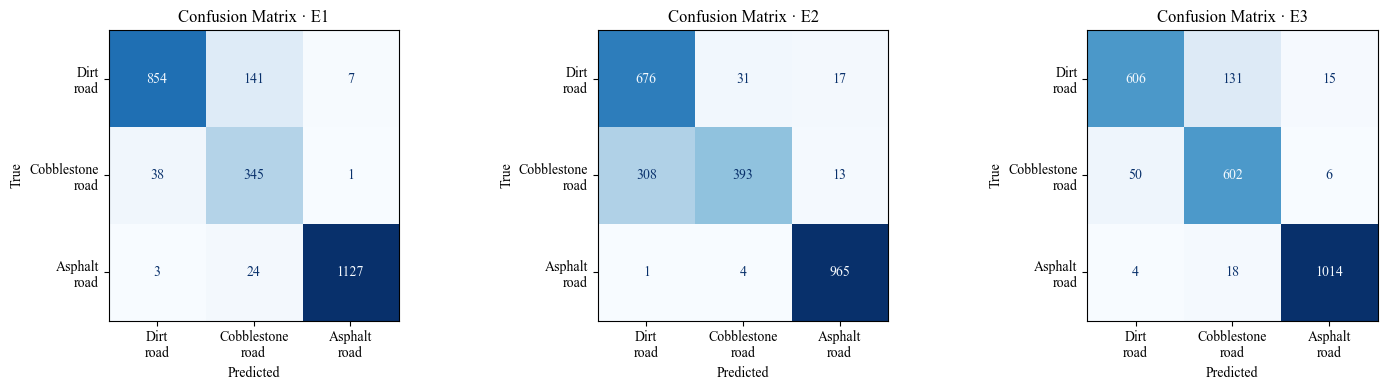

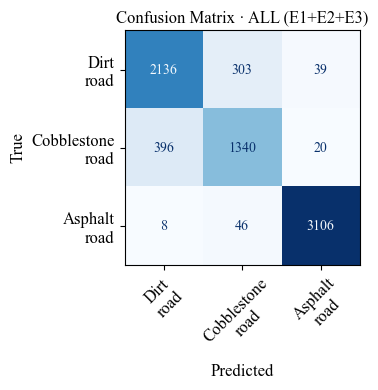

In [14]:
# Cell 11: Confusion matrices (per-exp và tổng)

LABEL_NAMES = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]
CLASS_IDS   = [0, 1, 2]

exps = ["E1", "E2", "E3"]
y_tests, y_preds = {}, {}

# Tái huấn luyện + dự đoán trên test cho từng exp để vẽ CM
for exp in exps:
    print(f"[CM] Refit & predict on {exp}")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = LGBMClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_tests[exp] = y_test
    y_preds[exp] = y_pred

# --- Hình 1: 1 hàng 3 cột (E1/E2/E3) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, exp in enumerate(exps):
    ax = axes[idx]
    cm = confusion_matrix(y_tests[exp], y_preds[exp], labels=CLASS_IDS)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix · {exp}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# --- Hình 2: Tổng (gộp E1+E2+E3) ---
y_all_true = np.concatenate([y_tests[e] for e in exps], axis=0)
y_all_pred = np.concatenate([y_preds[e] for e in exps], axis=0)
cm_all = confusion_matrix(y_all_true, y_all_pred, labels=CLASS_IDS)

fig2, ax2 = plt.subplots(1, 1, figsize=(4, 4))
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=LABEL_NAMES)
disp_all.plot(ax=ax2, values_format='d', cmap="Blues", colorbar=False)
ax2.set_title("Confusion Matrix · ALL (E1+E2+E3)")
ax2.set_xlabel("Predicted", fontsize=12)
ax2.set_ylabel("True", fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 12 — Classification report

In [15]:
# Cell 12: Classification reports (per-exp và tổng)

exps = ["E1", "E2", "E3"]

# for exp in exps:
#     print(f"\n===== Classification Report · {exp} =====")
#     print(classification_report(
#         y_tests[exp],
#         y_preds[exp],
#         labels=[0,1,2],
#         target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
#         digits=4
#     ))

print("\n===== Classification Report · ALL (E1+E2+E3) =====")
print(classification_report(
    y_all_true,
    y_all_pred,
    labels=[0,1,2],
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))



===== Classification Report · ALL (E1+E2+E3) =====
                  precision    recall  f1-score   support

       Dirt road     0.8409    0.8620    0.8513      2478
Cobblestone road     0.7934    0.7631    0.7779      1756
    Asphalt road     0.9814    0.9829    0.9821      3160

        accuracy                         0.8902      7394
       macro avg     0.8719    0.8693    0.8705      7394
    weighted avg     0.8897    0.8902    0.8898      7394



## Cell 13 — Huấn luyện trên toàn bộ PVS và xuất mã C

In [16]:
# Cell 13: Huấn luyện trên toàn bộ PVS và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_LGBM = LGBMClassifier(**BEST_PARAMS, random_state=42)
final_clf_LGBM.fit(X_all, y_all)

# Xuất mô hình sang header C/C++ bằng m2cgen
header_file = "m2cgen_PVS_LGBM.h"

try:
    c_cpp_code = export_to_c(final_clf_LGBM)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 7180, number of used features: 80
[LightGBM] [Info] Start training from score -1.280154
[LightGBM] [Info] Start training from score -1.231269
[LightGBM] [Info] Start training from score -0.843776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


✅ Exported to 'm2cgen_PVS_LGBM.h'
📦 Header size: 770.44 KB (0.752 MB)


# 1 vị trí riêng lẻ - above

## Cell 1 — Imports, cấu hình & định nghĩa Experiments 1–3

In [17]:
# Cell 1: Imports, constants, experiments
import os, json, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from m2cgen.exporters import export_to_c

# Thiết lập font mặc định Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Gốc thư mục PVS
BASE_DIR = r"D:\BVHoan\Spiiras Proceedings\Passive Vehicular Sensors Datasets"
PVS_FOLDERS = [os.path.join(BASE_DIR, f"PVS {i}") for i in range(1, 10)]

# Cấu hình phân đoạn
WINDOW_SIZE = 600
STRIDE = 300

# =========================
# Chọn thủ công cấu hình sensor
# =========================
# Hỗ trợ: "dashboard","above","below",
#         "dashboard+above", "dashboard+below", "above+below",
#         "dashboard+above+below"
ACTIVE_PRESET = "above"  # <-- chỉnh tại đây khi muốn thử cấu hình khác

# Định nghĩa các kênh IMU cho từng vị trí (mỗi vị trí có cả L/R; tên cột giống nhau giữa left/right CSV)
DASH_IMU = [
    "acc_x_dashboard", "acc_y_dashboard", "acc_z_dashboard",
    "gyro_x_dashboard", "gyro_y_dashboard", "gyro_z_dashboard",
]
ABOVE_IMU = [
    "acc_x_above_suspension", "acc_y_above_suspension", "acc_z_above_suspension",
    "gyro_x_above_suspension", "gyro_y_above_suspension", "gyro_z_above_suspension",
]
BELOW_IMU = [
    "acc_x_below_suspension", "acc_y_below_suspension", "acc_z_below_suspension",
    "gyro_x_below_suspension", "gyro_y_below_suspension", "gyro_z_below_suspension",
]

# Bảng preset (chỉ liệt kê kênh IMU; cột speed sẽ được thêm một lần ở cuối)
SENSOR_PRESETS = {
    "dashboard": DASH_IMU,
    "above": ABOVE_IMU,
    "below": BELOW_IMU,
    "dashboard+above": DASH_IMU + ABOVE_IMU,
    "dashboard+below": DASH_IMU + BELOW_IMU,
    "above+below": ABOVE_IMU + BELOW_IMU,
    "dashboard+above+below": DASH_IMU + ABOVE_IMU + BELOW_IMU,
}

def choose_active_preset(name: str, include_speed: bool = True):
    if name not in SENSOR_PRESETS:
        raise ValueError(f"Unknown preset '{name}'. Allowed: {list(SENSOR_PRESETS.keys())}")
    cols = list(SENSOR_PRESETS[name])  # copy
    if include_speed:
        cols = cols + ["speed"]  # chỉ một cột speed dùng chung cho toàn cấu hình
    return cols

# Danh sách cột đầu vào cho run hiện tại
SENSOR_COLUMNS = choose_active_preset(ACTIVE_PRESET, include_speed=True)

print(f"✅ Using preset: {ACTIVE_PRESET}")
print(f"   → #IMU channels (không tính speed): {len(SENSOR_COLUMNS) - 1}")
print(f"   → Tổng số kênh (đã gồm speed):      {len(SENSOR_COLUMNS)}")

# Nhãn tác vụ chính (mutually exclusive)
LABEL_COLUMNS = ["dirt_road", "cobblestone_road", "asphalt_road"]

# Cấu hình chia theo Menegazzo
EXPERIMENTS = {
    1: {"train": ["PVS 1", "PVS 3", "PVS 4", "PVS 6", "PVS 7", "PVS 9"],
        "test":  ["PVS 2", "PVS 5", "PVS 8"]},
    2: {"train": ["PVS 1", "PVS 2", "PVS 3", "PVS 7", "PVS 8", "PVS 9"],
        "test":  ["PVS 4", "PVS 5", "PVS 6"]},
    3: {"train": ["PVS 1", "PVS 2", "PVS 4", "PVS 6", "PVS 8", "PVS 9"],
        "test":  ["PVS 3", "PVS 5", "PVS 7"]},
}


✅ Using preset: above
   → #IMU channels (không tính speed): 6
   → Tổng số kênh (đã gồm speed):      7


## Cell 2 — I/O & kiểm tra: đọc 3 file trong 1 PVS, cửa sổ, majority label

In [18]:
# Cell 2: IO, validation, windowing, majority label

def load_pvs_triplet(pvs_dir: str):
    """
    Đọc 3 file trong một thư mục PVS:
      - dataset_gps_mpu_left.csv
      - dataset_gps_mpu_right.csv
      - dataset_labels.csv
    Trả về (left_df, right_df, labels_df) và kiểm tra cấu trúc tối thiểu
    theo cấu hình cột hiện hành (SENSOR_COLUMNS từ Cell 1).
    """
    left_path  = os.path.join(pvs_dir, "dataset_gps_mpu_left.csv")
    right_path = os.path.join(pvs_dir, "dataset_gps_mpu_right.csv")
    label_path = os.path.join(pvs_dir, "dataset_labels.csv")

    if not (os.path.exists(left_path) and os.path.exists(right_path) and os.path.exists(label_path)):
        raise FileNotFoundError(f"Missing one of required files in: {pvs_dir}")

    left_df  = pd.read_csv(left_path)
    right_df = pd.read_csv(right_path)
    labels_df= pd.read_csv(label_path)

    # Hàng phải khớp 1–1 giữa 3 file (đồng bộ theo chỉ số dòng)
    if not (len(left_df) == len(right_df) == len(labels_df)):
        raise ValueError(
            f"Row mismatch in {pvs_dir}: left={len(left_df)}, right={len(right_df)}, labels={len(labels_df)}"
        )

    # --- Kiểm tra cột theo preset hiện hành ---
    # Tất cả kênh trừ 'speed' phải có ở cả left và right.
    imu_cols = [c for c in SENSOR_COLUMNS if c != "speed"]
    missing_imu = [c for c in imu_cols if (c not in left_df.columns or c not in right_df.columns)]
    if missing_imu:
        raise KeyError(f"Missing IMU columns {missing_imu} in {pvs_dir} (left/right)")

    # 'speed' phải có ít nhất ở một trong hai file (giá trị hai phía giống nhau là mong đợi)
    if "speed" in SENSOR_COLUMNS:
        has_speed_left  = "speed" in left_df.columns
        has_speed_right = "speed" in right_df.columns
        if not (has_speed_left or has_speed_right):
            raise KeyError(f"Missing column 'speed' in {pvs_dir} (neither left nor right)")

        # Nếu có ở cả hai, kiểm tra gần như nhau (sanity check, không dừng nếu lệch rất nhỏ do làm tròn)
        if has_speed_left and has_speed_right:
            try:
                if not np.allclose(left_df["speed"].values, right_df["speed"].values, atol=1e-6, rtol=1e-6):
                    print(f"[Warn] 'speed' differs between left/right in {pvs_dir}. "
                          f"Values should be identical (GPS shared). Proceeding with files as-is.")
            except Exception:
                # Trường hợp dtype lạ hoặc NaN; chỉ cảnh báo nhẹ
                print(f"[Warn] Could not compare 'speed' columns in {pvs_dir} due to dtype/NaN issues.")

    # Cột nhãn one-hot bắt buộc
    for col in LABEL_COLUMNS:
        if col not in labels_df.columns:
            raise KeyError(f"Label column '{col}' missing in {pvs_dir}/dataset_labels.csv")

    return left_df, right_df, labels_df

def window_indices(n_samples: int, window: int, stride: int):
    """Sinh danh sách (start, end) cho các cửa sổ trượt."""
    idx = []
    start = 0
    while start + window <= n_samples:
        idx.append((start, start + window))
        start += stride
    return idx

def majority_label_onehot(block_labels, label_cols=LABEL_COLUMNS):
    """
    Lấy nhãn majority trong cửa sổ theo tổng one-hot; khi hòa,
    dùng mode() giống Menegazzo.
    """
    sums = block_labels[label_cols].sum(axis=0)
    max_sum = sums.max()
    tied = [cls for cls, val in sums.items() if val == max_sum]
    if len(tied) == 1:
        return tied[0]
    # dùng mode() giống Menegazzo
    mode_label = block_labels[label_cols].mode().iloc[0]
    for cls in label_cols:
        if mode_label[cls] == 1:
            return cls
    return tied[0]


## Cell 3 — Phân đoạn một lần duy nhất và gắn provenance PVS

In [19]:
# Cell 3: Single-pass segmentation with provenance (both sides as independent samples)

def build_windows_by_pvs(pvs_folders):
    """
    Trả về:
      windows_by_pvs = {
        'PVS 1': {'dirt_road': [np.array(WINDOW_SIZE, n_channels), ...],
                  'cobblestone_road': [...],
                  'asphalt_road': [...]},
        ...
      }
    Mỗi cửa sổ là một mẫu; left/right được coi là 2 mẫu độc lập (đúng Menegazzo).
    """
    windows_by_pvs = {}
    global_summary = Counter()

    for pvs_dir in pvs_folders:
        pvs_name = os.path.basename(pvs_dir)  # "PVS i"
        try:
            left_df, right_df, labels_df = load_pvs_triplet(pvs_dir)
        except Exception as e:
            print(f"[WARN] Skip {pvs_name}: {e}")
            continue

        # -----------------------------
        # 1) Chuẩn bị tín hiệu đầu vào
        # -----------------------------
        # Sao chép SENSOR_COLUMNS để tách speed riêng
        cols_no_speed = [c for c in SENSOR_COLUMNS if c != "speed"]
        include_speed = "speed" in SENSOR_COLUMNS

        # Các cột IMU phải có ở cả left & right
        left_sig_imu  = left_df[cols_no_speed].to_numpy(dtype=np.float32)
        right_sig_imu = right_df[cols_no_speed].to_numpy(dtype=np.float32)

        # Speed: chỉ lấy một nguồn (left ưu tiên)
        if include_speed:
            if "speed" in left_df.columns:
                speed_vec = left_df["speed"].to_numpy(dtype=np.float32)
            else:
                speed_vec = right_df["speed"].to_numpy(dtype=np.float32)
            speed_vec = speed_vec.reshape(-1, 1)
            # Ghép speed thành cột cuối
            left_sig  = np.hstack([left_sig_imu,  speed_vec])
            right_sig = np.hstack([right_sig_imu, speed_vec])
        else:
            left_sig, right_sig = left_sig_imu, right_sig_imu

        # -----------------------------
        # 2) Xử lý nhãn
        # -----------------------------
        labels_main = labels_df[LABEL_COLUMNS].astype(int)
        n = len(labels_main)
        win_idxs = window_indices(n, WINDOW_SIZE, STRIDE)
        if not win_idxs:
            print(f"[INFO] {pvs_name}: not enough samples for one window ({n} < {WINDOW_SIZE})")
            continue

        # -----------------------------
        # 3) Tạo kho lưu kết quả
        # -----------------------------
        windows_by_pvs.setdefault(pvs_name, {k: [] for k in LABEL_COLUMNS})

        # -----------------------------
        # 4) Cắt cửa sổ và gán nhãn
        # -----------------------------
        for (s, e) in win_idxs:
            cls = majority_label_onehot(labels_main.iloc[s:e], LABEL_COLUMNS)

            # Mỗi bên là một mẫu độc lập
            wL = left_sig[s:e, :]
            wR = right_sig[s:e, :]

            windows_by_pvs[pvs_name][cls].append(wL)
            windows_by_pvs[pvs_name][cls].append(wR)
            global_summary[cls] += 2

    # -----------------------------
    # 5) Log thống kê
    # -----------------------------
    print(f"=== Windows per PVS (preset: {ACTIVE_PRESET}) ===")
    for pvs_name in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
        line = [f"{cls}:{len(windows_by_pvs[pvs_name][cls])}" for cls in LABEL_COLUMNS]
        print(f"{pvs_name} -> " + " | ".join(line))

    print("\n=== Global class totals ===")
    for cls in LABEL_COLUMNS:
        print(f"{cls:17s}: {global_summary[cls]}")

    return windows_by_pvs

# Thực thi để sinh dữ liệu phân đoạn
windows_by_pvs = build_windows_by_pvs(PVS_FOLDERS)


=== Windows per PVS (preset: above) ===
PVS 1 -> dirt_road:172 | cobblestone_road:412 | asphalt_road:374
PVS 2 -> dirt_road:298 | cobblestone_road:138 | asphalt_road:392
PVS 3 -> dirt_road:190 | cobblestone_road:176 | asphalt_road:336
PVS 4 -> dirt_road:160 | cobblestone_road:384 | asphalt_road:336
PVS 5 -> dirt_road:404 | cobblestone_road:120 | asphalt_road:366
PVS 6 -> dirt_road:160 | cobblestone_road:210 | asphalt_road:268
PVS 7 -> dirt_road:158 | cobblestone_road:362 | asphalt_road:334
PVS 8 -> dirt_road:300 | cobblestone_road:126 | asphalt_road:396
PVS 9 -> dirt_road:154 | cobblestone_road:168 | asphalt_road:286

=== Global class totals ===
dirt_road        : 1996
cobblestone_road : 2096
asphalt_road     : 3088


## Cell 4 — Tạo đủ 3 splits theo Menegazzo và in thống kê

In [20]:
# Cell 4: Build ALL 3 Menegazzo splits + stats

def _collect_from_pvs(pvs_list, windows_by_pvs, label_cols=LABEL_COLUMNS):
    bucket = {c: [] for c in label_cols}
    for pvs in pvs_list:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing; skipping.")
            continue
        for cls in label_cols:
            bucket[cls].extend(windows_by_pvs[pvs][cls])
    return bucket

def _print_split_stats(exp_id, split_name, lists_by_class, label_cols=LABEL_COLUMNS):
    total = sum(len(v) for v in lists_by_class.values())
    print(f"[Experiment {exp_id} · {split_name.upper()}] Total windows: {total}")
    for cls in label_cols:
        print(f"  {cls:17s}: {len(lists_by_class[cls])}")

def make_all_splits(windows_by_pvs, experiments=EXPERIMENTS):
    """
    Trả về:
      splits = {
        1: {"train": {"dirt_road":[...], ...}, "test": {...}},
        2: {...},
        3: {...}
      }
    """
    splits = {}
    for exp_id, conf in experiments.items():
        tr_pvs, te_pvs = conf["train"], conf["test"]
        train_lists = _collect_from_pvs(tr_pvs, windows_by_pvs)
        test_lists  = _collect_from_pvs(te_pvs, windows_by_pvs)

        splits[exp_id] = {"train": train_lists, "test": test_lists}

        print(f"=== Experiment {exp_id} ===")
        _print_split_stats(exp_id, "train", train_lists)
        _print_split_stats(exp_id, "test",  test_lists)

    return splits

splits = make_all_splits(windows_by_pvs)


=== Experiment 1 ===
[Experiment 1 · TRAIN] Total windows: 4640
  dirt_road        : 994
  cobblestone_road : 1712
  asphalt_road     : 1934
[Experiment 1 · TEST] Total windows: 2540
  dirt_road        : 1002
  cobblestone_road : 384
  asphalt_road     : 1154
=== Experiment 2 ===
[Experiment 2 · TRAIN] Total windows: 4772
  dirt_road        : 1272
  cobblestone_road : 1382
  asphalt_road     : 2118
[Experiment 2 · TEST] Total windows: 2408
  dirt_road        : 724
  cobblestone_road : 714
  asphalt_road     : 970
=== Experiment 3 ===
[Experiment 3 · TRAIN] Total windows: 4734
  dirt_road        : 1244
  cobblestone_road : 1438
  asphalt_road     : 2052
[Experiment 3 · TEST] Total windows: 2446
  dirt_road        : 752
  cobblestone_road : 658
  asphalt_road     : 1036


## Cell 5 — Sinh biến cho cả 3 experiment (không ghi đè nhau)

In [21]:
# Cell 5: Variables for all 3 experiments with suffixes _E1/_E2/_E3

def _vars_for_all_experiments(splits_dict):
    for exp_id in (1, 2, 3):
        sd = splits_dict[exp_id]

        globals()[f"train_dirt_road_E{exp_id}"]         = sd["train"]["dirt_road"]
        globals()[f"train_cobblestone_road_E{exp_id}"]  = sd["train"]["cobblestone_road"]
        globals()[f"train_asphalt_road_E{exp_id}"]      = sd["train"]["asphalt_road"]

        globals()[f"test_dirt_road_E{exp_id}"]          = sd["test"]["dirt_road"]
        globals()[f"test_cobblestone_road_E{exp_id}"]   = sd["test"]["cobblestone_road"]
        globals()[f"test_asphalt_road_E{exp_id}"]       = sd["test"]["asphalt_road"]

_vars_for_all_experiments(splits)

# peek a few counts so you can sanity-check at a glance
for k in ("train_dirt_road", "train_cobblestone_road", "train_asphalt_road",
          "test_dirt_road", "test_cobblestone_road", "test_asphalt_road"):
    for e in (1, 2, 3):
        v = globals()[f"{k}_E{e}"]
        print(f"{k}_E{e:1d}: {len(v)} windows")


train_dirt_road_E1: 994 windows
train_dirt_road_E2: 1272 windows
train_dirt_road_E3: 1244 windows
train_cobblestone_road_E1: 1712 windows
train_cobblestone_road_E2: 1382 windows
train_cobblestone_road_E3: 1438 windows
train_asphalt_road_E1: 1934 windows
train_asphalt_road_E2: 2118 windows
train_asphalt_road_E3: 2052 windows
test_dirt_road_E1: 1002 windows
test_dirt_road_E2: 724 windows
test_dirt_road_E3: 752 windows
test_cobblestone_road_E1: 384 windows
test_cobblestone_road_E2: 714 windows
test_cobblestone_road_E3: 658 windows
test_asphalt_road_E1: 1154 windows
test_asphalt_road_E2: 970 windows
test_asphalt_road_E3: 1036 windows


## Cell 6 — Tạo data_train/data_test + label_train/label_test cho từng experiment

In [22]:
# Cell 6: Build data_/label_ arrays for EACH experiment,
# groups cho mỗi cửa sổ (train/test) theo PVS (để dùng Group-aware CV)

def _vars_with_groups_for_experiment(exp_id):
    """
    Sinh data_/label_ + groups_ cho exp_id.
    Group = tên PVS của cửa sổ đó.
    Dùng danh sách cột linh hoạt SENSOR_COLUMNS (theo preset đã chọn).
    """
    data_train, label_train, groups_train = [], [], []

    # --- Build TRAIN ---
    for pvs in EXPERIMENTS[exp_id]["train"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TRAIN")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                # mỗi acts là np.array(window_size, n_channels)
                data_train.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_train.append(lab)
                groups_train.append(pvs)

    # --- Build TEST ---
    data_test, label_test, groups_test = [], [], []
    for pvs in EXPERIMENTS[exp_id]["test"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TEST")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                data_test.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_test.append(lab)
                groups_test.append(pvs)

    # --- Lưu vào biến toàn cục ---
    globals()[f"data_train_E{exp_id}"]   = data_train
    globals()[f"label_train_E{exp_id}"]  = label_train
    globals()[f"groups_train_E{exp_id}"] = groups_train

    globals()[f"data_test_E{exp_id}"]    = data_test
    globals()[f"label_test_E{exp_id}"]   = label_test
    globals()[f"groups_test_E{exp_id}"]  = groups_test

# Rebuild để có groups (E1–E3)
_vars_with_groups_for_experiment(1)
_vars_with_groups_for_experiment(2)
_vars_with_groups_for_experiment(3)

print("E1:", len(data_train_E1), "train /", len(data_test_E1), "test | #groups(train) =", len(set(groups_train_E1)))
print("E2:", len(data_train_E2), "train /", len(data_test_E2), "test | #groups(train) =", len(set(groups_train_E2)))
print("E3:", len(data_train_E3), "train /", len(data_test_E3), "test | #groups(train) =", len(set(groups_train_E3)))


E1: 4640 train / 2540 test | #groups(train) = 6
E2: 4772 train / 2408 test | #groups(train) = 6
E3: 4734 train / 2446 test | #groups(train) = 6


## Cell 7 — Feature extraction

In [23]:
# # Cell 7: Trích xuất đặc trưng

# def featuresFromBuffer(at):
#     feat = np.zeros(80, dtype=np.float32)
    
#     # ---- ABOVE ----
#     ax_above = np.array(at['acc_x_above_suspension'],  dtype=np.float32)
#     ay_above = np.array(at['acc_y_above_suspension'],  dtype=np.float32)
#     az_above = np.array(at['acc_z_above_suspension'],  dtype=np.float32)
#     gx_above = np.array(at['gyro_x_above_suspension'], dtype=np.float32)
#     gy_above = np.array(at['gyro_y_above_suspension'], dtype=np.float32)
#     gz_above = np.array(at['gyro_z_above_suspension'], dtype=np.float32)
    
#     # ---- SPEED (chung) ----
#     sp = np.array(at['speed'], dtype=np.float32)
    
#     # Đặc trưng thống kê
#     feat[0:7] = [np.mean(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above, sp]] # mean
#     feat[7:14] = [np.std(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above, sp]] # sd
#     feat[14:20] = [np.sqrt(np.mean(i**2)) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # rms
#     feat[20:26] = [np.max(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # max
#     feat[26:32] = [np.min(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # min
#     feat[32:38] = [np.amax(i) - np.amin(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # range
#     feat[38:44] = [np.median(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # median
#     feat[44:50] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # interquartile range
#     feat[50:56] = [skew(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # skewness
#     feat[56:62] = [kurtosis(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # kurtosis
#     feat[62:68] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # hjorth mobility
#     feat[68:74] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # hjorth complexity
#     feat[74:80] = [acf(i, nlags=1)[1] for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # autocorrelation
    
#     return feat

# # Trích xuất đặc trưng cho từng cửa sổ
# train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
# test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
# train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
# test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
# train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
# test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

# # Ép sang numpy array
# train_features_E1 = np.array(train_features_E1, dtype=np.float32)
# test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
# train_features_E2 = np.array(train_features_E2, dtype=np.float32)
# test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
# train_features_E3 = np.array(train_features_E3, dtype=np.float32)
# test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

# print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
# print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
# print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
# print('Feature dimension:', train_features_E1.shape[1])

# # Gom toàn bộ dữ liệu từ PVS 1..9 (tránh dùng E1/E2/E3 để không đếm trùng)
# cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
# X_all, y_all = [], []

# # Đảm bảo thứ tự PVS 1..9 ổn định
# for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#     for cls_name, cls_id in cls_map:
#         for buf in windows_by_pvs[pvs][cls_name]:
#             # buf là ndarray (WINDOW_SIZE x len(SENSOR_COLUMNS))
#             at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#             feat = featuresFromBuffer(at)
#             X_all.append(feat)
#             y_all.append(cls_id)

# X_all = np.asarray(X_all, dtype=np.float32)
# y_all = np.asarray(y_all, dtype=np.int32)
# print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))


## Cell 7A — Tính & Lưu cache

In [24]:
# # Cell 7A: Compute & cache features for the current ACTIVE_PRESET

# def _extract_features_for_splits():
#     # y nguyên format Cell 7: tạo các mảng đặc trưng cho E1/E2/E3
#     train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
#     test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
#     train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
#     test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
#     train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
#     test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

#     # Ép sang numpy array
#     train_features_E1 = np.array(train_features_E1, dtype=np.float32)
#     test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
#     train_features_E2 = np.array(train_features_E2, dtype=np.float32)
#     test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
#     train_features_E3 = np.array(train_features_E3, dtype=np.float32)
#     test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

#     return (train_features_E1, test_features_E1,
#             train_features_E2, test_features_E2,
#             train_features_E3, test_features_E3)

# def _extract_features_all_pvs():
#     # Y nguyên logic gom ALL PVS (tránh đếm trùng E1/E2/E3)
#     cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
#     X_all, y_all = [], []

#     for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#         for cls_name, cls_id in cls_map:
#             for buf in windows_by_pvs[pvs][cls_name]:
#                 at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#                 feat = featuresFromBuffer(at)
#                 X_all.append(feat)
#                 y_all.append(cls_id)

#     X_all = np.asarray(X_all, dtype=np.float32)
#     y_all = np.asarray(y_all, dtype=np.int32)
#     return X_all, y_all

# def _save_feature_cache(fname,
#                         train_features_E1, test_features_E1,
#                         train_features_E2, test_features_E2,
#                         train_features_E3, test_features_E3,
#                         X_all, y_all):
#     # Lưu gọn bằng NPZ nén
#     np.savez_compressed(
#         fname,
#         ACTIVE_PRESET=np.array([ACTIVE_PRESET]),
#         SENSOR_COLUMNS=np.array(SENSOR_COLUMNS),
#         WINDOW_SIZE=np.array([WINDOW_SIZE], dtype=np.int32),
#         STRIDE=np.array([STRIDE], dtype=np.int32),
#         LABEL_COLUMNS=np.array(LABEL_COLUMNS),

#         train_features_E1=train_features_E1,
#         test_features_E1=test_features_E1,
#         train_features_E2=train_features_E2,
#         test_features_E2=test_features_E2,
#         train_features_E3=train_features_E3,
#         test_features_E3=test_features_E3,

#         X_all=X_all,
#         y_all=y_all
#     )

# # ---- Thực thi: tính & lưu ----
# cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
# print(f"⏳ Computing features for preset: {ACTIVE_PRESET} ...")

# (train_features_E1, test_features_E1,
#  train_features_E2, test_features_E2,
#  train_features_E3, test_features_E3) = _extract_features_for_splits()

# print("   • Splits done:",
#       f"E1: {train_features_E1.shape} / {test_features_E1.shape} |",
#       f"E2: {train_features_E2.shape} / {test_features_E2.shape} |",
#       f"E3: {train_features_E3.shape} / {test_features_E3.shape}")

# X_all, y_all = _extract_features_all_pvs()
# print("   • ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))

# _save_feature_cache(cache_name,
#                     train_features_E1, test_features_E1,
#                     train_features_E2, test_features_E2,
#                     train_features_E3, test_features_E3,
#                     X_all, y_all)

# size_bytes = os.path.getsize(cache_name)
# print(f"✅ Saved cache to '{cache_name}' ({size_bytes/1024/1024:.3f} MB)")


## Cell 7B — Nạp cache (dùng cho chạy nhanh về sau)

In [25]:
# Cell 7B: Load cached feature set for the current ACTIVE_PRESET

cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
if not os.path.exists(cache_name):
    raise FileNotFoundError(f"Feature cache not found: {cache_name}. Hãy chạy Cell 7A trước để tạo cache.")

data = np.load(cache_name, allow_pickle=True)

# Khôi phục biến đúng tên như Cell 7 gốc
train_features_E1 = data["train_features_E1"]
test_features_E1  = data["test_features_E1"]
train_features_E2 = data["train_features_E2"]
test_features_E2  = data["test_features_E2"]
train_features_E3 = data["train_features_E3"]
test_features_E3  = data["test_features_E3"]

X_all = data["X_all"]
y_all = data["y_all"]

# (tuỳ chọn) kiểm tra meta để cảnh báo nếu lệch preset
_cached_preset = str(data["ACTIVE_PRESET"][0])
if _cached_preset != ACTIVE_PRESET:
    print(f"[WARN] Cache preset = '{_cached_preset}' khác với ACTIVE_PRESET hiện tại = '{ACTIVE_PRESET}'")

# In thống kê giống Cell 7 gốc
print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
print('Feature dimension:', train_features_E1.shape[1])
print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))
print(f"✅ Loaded cache from '{cache_name}'")


E1: 4640 train samples / 2540 test samples
E2: 4772 train samples / 2408 test samples
E3: 4734 train samples / 2446 test samples
Feature dimension: 80
ALL PVS: (7180, 80) | class dist: [1996 2096 3088]
✅ Loaded cache from 'feature_set_above.npz'


## Cell 8 — Find candidates

In [26]:
# Cell 8: Find candidates, LOGO trên 3 experiment → lấy 3 bộ tham số ứng viên (Accuracy), kèm kiểm tra model size ≤ 1.00 MB
print(f"✅ Using preset: {ACTIVE_PRESET}")

# Định nghĩa grid riêng cho từng exp
param_grids = {
    "E1": {
        "n_estimators": list(range(40, 41)),
        "max_depth": list(range(10, 12))
    },
    "E2": {
        "n_estimators": list(range(49, 50)),
        "max_depth": list(range(9, 10))
    },
    "E3": {
        "n_estimators": list(range(49, 50)),
        "max_depth": list(range(7, 8))
    }
}

# ---------------------- HÀM ĐO SIZE ----------------------
def measure_model_size_mb(params, X_full, y_full):
    """
    Train LGBMClassifier trên toàn bộ dữ liệu với 'params',
    export C/C++ header bằng m2cgen.exporters.export_to_c() rồi đo kích thước (MB).
    Trả về (size_mb, error_msg, c_code).
    """
    clf = LGBMClassifier(**params, random_state=42)
    clf.fit(X_full, y_full)

    tmp_header = None
    c_code = None
    err = ""
    size_mb = None
    try:
        c_code = export_to_c(clf)
        with tempfile.NamedTemporaryFile(mode="w", suffix=".h", delete=False, encoding="utf-8") as f:
            tmp_header = f.name
            f.write(c_code)

        size_bytes = os.path.getsize(tmp_header)
        size_mb = size_bytes / (1024 * 1024)
    except Exception as e:
        err = str(e)
    finally:
        if tmp_header and os.path.exists(tmp_header):
            os.remove(tmp_header)

    return size_mb, err, c_code

# ---------------------- HÀM LOGO + GRIDSEARCH CHO 1 EXP ----------------------
def run_logo_for_experiment(exp_name, X_train, y_train, groups, X_full_for_size, y_full_for_size,
                            param_grid, size_limit_mb=1.00):
    """
    - Chạy GridSearchCV với LOGO (Accuracy) trên (X_train, y_train, groups).
    - Với từng bộ params trong kết quả, train lại trên toàn bộ PVS 1–9 để đo size.
    - Chọn bộ params có:
        * size ≤ size_limit_mb
        * điểm cv (mean test Accuracy) cao nhất
      Tie-break: model nhỏ hơn → depth thấp hơn → số cây ít hơn.
    - Trả về dict ứng viên cho exp này.
    """
    print(f"\n===== EXP {exp_name}: START LOGO GRID (Accuracy) + SIZE CHECK ≤ {size_limit_mb:.2f} MB =====")
    logo = LeaveOneGroupOut()
    gs = GridSearchCV(
        estimator=LGBMClassifier(random_state=42),
        param_grid=param_grid,
        cv=logo.split(X_train, y_train, groups=groups),
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    best_cv = -np.inf
    best = None

    for i, params in enumerate(gs.cv_results_["params"], 1):
        cv_mean = gs.cv_results_["mean_test_score"][i-1]
        print(f"[{exp_name}] Check {i}/{len(gs.cv_results_['params'])}: {params} | CV Accuracy={cv_mean*100:.2f}")

        size_mb, err, _ = measure_model_size_mb(params, X_full_for_size, y_full_for_size)
        status = "ok"
        if err:
            status = f"error: {err}"
        elif size_mb is None:
            status = "error: size_none"
        elif size_mb > size_limit_mb:
            status = "oversize"

        print(f"   -> size={None if size_mb is None else f'{size_mb:.3f} MB'} | status={status}")

        if status == "ok":
            # update theo tiêu chí: cv cao nhất → size nhỏ hơn → depth thấp hơn → n_estimators ít hơn
            if (cv_mean > best_cv or
                (np.isclose(cv_mean, best_cv) and size_mb < best["size_mb"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] < best["params"]["max_depth"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] == best["params"]["max_depth"] and params["n_estimators"] < best["params"]["n_estimators"])
               ):
                best_cv = cv_mean
                best = {
                    "exp": exp_name,
                    "params": dict(params),
                    "cv_accuracy": float(cv_mean),
                    "size_mb": float(size_mb)
                }

    if best is None:
        best = {
            "exp": exp_name,
            "params": None,
            "cv_accuracy": None,
            "size_mb": None,
            "note": f"No feasible params ≤ {size_limit_mb:.2f} MB (or export error)"
        }
        print(f"[{exp_name}] WARNING: Không tìm thấy cấu hình khả thi (≤ {size_limit_mb:.2f} MB).")

    print(f"[{exp_name}] BEST CANDIDATE:", best)
    return best

candidates = []
candidates.append(run_logo_for_experiment("E1", train_features_E1, label_train_E1, groups_train_E1, X_all, y_all, param_grids["E1"]))
candidates.append(run_logo_for_experiment("E2", train_features_E2, label_train_E2, groups_train_E2, X_all, y_all, param_grids["E2"]))
candidates.append(run_logo_for_experiment("E3", train_features_E3, label_train_E3, groups_train_E3, X_all, y_all, param_grids["E3"]))

print("\n===== 3 ỨNG VIÊN LOGO (Accuracy, size≤1.00MB) =====")
for c in candidates:
    print(c)

# Lưu lại để dùng cho bước “chốt cuối”
with open("logo_candidates_LGBM.json", "w", encoding="utf-8") as f:
    json.dump(candidates, f, indent=2, ensure_ascii=False)

print("Đã lưu 3 ứng viên vào 'logo_candidates_LGBM.json'.")


✅ Using preset: above

===== EXP E1: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 80
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[E1] Check 1/2: {'max_depth': 10, 'n_estimators': 40} | CV Accuracy=88.35
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 7180, number of used features: 80
[LightGBM] [Info] Start training from score -1.280154
[LightGBM] [Info] Start training from score -1.231269
[Li

In [27]:
# mean, sd, rms, max, min, range, median, iqr, skew, kurt, hm, hc, acf
# {'exp': 'E1', 'params': {'max_depth': 10, 'n_estimators': 40}, 'cv_accuracy': 0.8834, 'size_mb': 0.631} -> 89.90
# {'exp': 'E2', 'params': {'max_depth': 09, 'n_estimators': 49}, 'cv_accuracy': 0.8916, 'size_mb': 0.766} -> 90.01 Maximin, Borda rank, Minimax regret, Mean - λ·Std
# {'exp': 'E3', 'params': {'max_depth': 07, 'n_estimators': 49}, 'cv_accuracy': 0.8860, 'size_mb': 0.730} -> 90.03

## Cell 9 — Select candidates

In [28]:
# Cell 9: Select candidates, thử 4 tiêu chí trên bộ ba ứng viên (train-only, LOGO)

# ========= NẠP 3 ỨNG VIÊN =========
with open("logo_candidates_LGBM.json", "r", encoding="utf-8") as f:
    candidates = json.load(f)

# Đặt tên ngắn gọn cho ứng viên theo exp gốc của nó: 'cand_E1', 'cand_E2', 'cand_E3'
for c in candidates:
    c["name"] = f"cand_{c['exp']}"

# ========= CHUẨN BỊ DỮ LIỆU TRAIN+GROUPS CHO 3 EXP =========
X_train_dict = {
    "E1": train_features_E1,
    "E2": train_features_E2,
    "E3": train_features_E3,
}
y_train_dict = {
    "E1": np.asarray(label_train_E1),
    "E2": np.asarray(label_train_E2),
    "E3": np.asarray(label_train_E3),
}
groups_dict = {
    "E1": np.asarray(groups_train_E1),
    "E2": np.asarray(groups_train_E2),
    "E3": np.asarray(groups_train_E3),
}

# ========= HÀM LOGO SCORE (Accuracy, train-only) =========
def logo_cv_accuracy_for_exp(params, X, y, groups):
    """
    Cố định bộ tham số 'params' => chạy LOGO trên (X,y,groups) => trả về mean Accuracy.
    """
    logo = LeaveOneGroupOut()
    f1s = []
    # Duyệt từng split LOGO
    for tr_idx, va_idx in logo.split(X, y, groups=groups):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        clf = LGBMClassifier(**params, random_state=42)
        clf.fit(X_tr, y_tr)
        y_hat = clf.predict(X_va)
        f1s.append(accuracy_score(y_va, y_hat))
    return float(np.mean(f1s))

# ========= TÍNH MA TRẬN ĐIỂM S_k(h) (k ∈ {E1,E2,E3}, h ∈ 3 ứng viên) =========
exps = ["E1", "E2", "E3"]
H = len(candidates)
K = len(exps)

scores = np.zeros((H, K), dtype=float)  # S[h,k] = Accuracy của ứng viên h trên exp k
for h, cand in enumerate(candidates):
    params = cand["params"]
    print(f"\n>>> Scoring {cand['name']} with params={params}")
    for k, ek in enumerate(exps):
        S_hk = logo_cv_accuracy_for_exp(params, X_train_dict[ek], y_train_dict[ek], groups_dict[ek])
        scores[h, k] = S_hk
        print(f"   {ek}: Accuracy(LOGO) = {S_hk*100:.2f}")

# ========= TIỆN ÍCH: TIE-BREAK =========
def tie_break_key(h):
    # size nhỏ hơn → depth nhỏ hơn → n_estimators ít hơn
    size = candidates[h].get("size_mb", np.inf)
    depth = candidates[h]["params"]["max_depth"]
    trees = candidates[h]["params"]["n_estimators"]
    return (size, depth, trees)

# ========= 1) MAXIMIN =========
worst_case = scores.min(axis=1)             # min_k S_k(h)
best_h_maximin = max(range(H), key=lambda h: (worst_case[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= 2) BORDA RANK =========
def ranks_desc(vals):
    """
    Trả về rank (1 = tốt nhất) theo thứ tự giảm dần của vals.
    Ties => average-rank.
    """
    vals = np.asarray(vals)
    # sắp xếp giảm dần
    order = np.argsort(-vals)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(vals) + 1, dtype=float)
    # xử lý ties (average rank)
    for v in np.unique(vals):
        idx = np.where(vals == v)[0]
        if len(idx) > 1:
            avg = ranks[idx].mean()
            ranks[idx] = avg
    return ranks

borda = np.zeros(H, dtype=float)
for k in range(K):
    borda += ranks_desc(scores[:, k])
best_h_borda = min(range(H), key=lambda h: (borda[h], tie_break_key(h)))

# ========= 3) MINIMAX REGRET =========
best_per_exp = scores.max(axis=0)           # S*_k
regret = best_per_exp - scores              # Reg_k(h) = S*_k - S_k(h)
max_regret = regret.max(axis=1)             # max_k Reg_k(h)
best_h_regret = min(range(H), key=lambda h: (max_regret[h], tie_break_key(h)))

# ========= 4) MEAN − λ·STD (λ suy từ dữ liệu) =========
means = scores.mean(axis=1)
stds  = scores.std(axis=1, ddof=0)

sigma_typ = float(np.median(stds))
c_pp = 0.01  # 1.0 điểm phần trăm F1  => 0.01 theo thang [0,1]
# Nếu bạn thích 0.5–1.5 pp, đổi c_pp = 0.005 ~ 0.015
if sigma_typ > 0:
    lam = c_pp / sigma_typ
else:
    lam = 0.1
lam = float(np.clip(lam, 0.1, 1.0))

risk_adj = means - lam * stds
best_h_mean_std = max(range(H), key=lambda h: (risk_adj[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= IN KẾT QUẢ =========
def pretty_candidate(h):
    c = candidates[h]
    return {
        "name": c["name"],
        "params": c["params"],
        "size_mb": round(float(c.get("size_mb", np.nan)), 3),
        "S_E1": round(scores[h,0]*100, 2),
        "S_E2": round(scores[h,1]*100, 2),
        "S_E3": round(scores[h,2]*100, 2),
        "mean": round(means[h]*100, 2),
        "std": round(stds[h], 2)
    }

print("\n===== SCORE MATRIX (Accuracy, train-only LOGO) =====")
for h in range(H):
    print(pretty_candidate(h))

print("\n===== SELECTIONS (4 tiêu chí) =====")
print(f"Maximin         -> {pretty_candidate(best_h_maximin)}")
print(f"Borda rank      -> {pretty_candidate(best_h_borda)}")
print(f"Minimax regret  -> {pretty_candidate(best_h_regret)}")
print(f"Mean - λ·Std    -> {pretty_candidate(best_h_mean_std)}  (λ = {lam:.4f}, c_pp={c_pp})")



>>> Scoring cand_E1 with params={'max_depth': 10, 'n_estimators': 40}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 80
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3938, number of used features: 80
[LightGBM] [Info] Start training from score -1.588829
[LightGBM] [Info] Start training from score -0.941491
[LightGBM] [Info] Start training from score -0.901920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 80
[LightGBM] [Info] Start training from score -1.505941
[LightGBM] [Info] Start training from score -1.040745
[LightGBM] [Info] Start training from score -0.855666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4002, number of used features: 80
[LightGBM] [Info] Start training from score -1.568316
[LightGBM] [Info] Start training from score -0.979997
[LightGBM] [Info] Start training from score -0.876369
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4032, number of used features: 80
[LightGBM] [Info] Start training from score -1.568616
[LightGBM] [Info] Start training from score -0.959886
[LightGBM] [Info] Start training from score -0.894700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E1: Accuracy(LOGO) = 88.35
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3814, number of used features: 80
[LightGBM] [Info] Start training from score -1.243368
[LightGBM] [Info] Start training from score -1.369138
[LightGBM] [Info] Start training from score -0.782497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 80
[LightGBM] [Info] Start training from score -1.398539
[LightGBM] [Info] Start training from score -1.153863
[LightGBM] [Info] Start training from score -0.

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 80
[LightGBM] [Info] Start training from score -1.257624
[LightGBM] [Info] Start training from score -1.345779
[LightGBM] [Info] Start training from score -0.786723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 80
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4164, number of used features: 80
[LightGBM] [Info] Start training from score -1.314935
[LightGBM] [Info] Start training from score -1.232555
[LightGBM] [Info] Start training from score -0.821068
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E2: Accuracy(LOGO) = 88.66
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 80
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3906, number of used features: 80
[LightGBM] [Info] Start training from score -1.418027
[LightGBM] [Info] Start training from score -1.100150
[LightGBM] [Info] Start training from score -0.

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3854, number of used features: 80
[LightGBM] [Info] Start training from score -1.268454
[LightGBM] [Info] Start training from score -1.296519
[LightGBM] [Info] Start training from score -0.809116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 80
[LightGBM] [Info] Start training from score -1.329353
[LightGBM] [Info] Start training from score -1.204624
[L

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4126, number of used features: 80
[LightGBM] [Info] Start training from score -1.331131
[LightGBM] [Info] Start training from score -1.178292
[LightGBM] [Info] Start training from score -0.848591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E3: Accuracy(LOGO) = 88.11

>>> Scoring cand_E2 with params={'max_depth': 9, 'n_estimators': 49}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 80
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start trainin

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3938, number of used features: 80
[LightGBM] [Info] Start training from score -1.588829
[LightGBM] [Info] Start training from score -0.941491
[LightGBM] [Info] Start training from score -0.901920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 80
[LightGBM] [Info] Start training from score -1.505941
[LightGBM] [Info] Start training from score -1.040745
[LightGBM] [Info] Start training from score -0.855666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4002, number of used features: 80
[LightGBM] [Info] Start training from score -1.568316
[LightGBM] [Info] Start training from score -0.979997
[LightGBM] [Info] Start training from score -0.876369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3786, number of used features: 80
[LightGBM] [Info] Start training from score -1.510437
[LightGBM] [Info] Start training from score -1.031205
[LightGBM] [Info] Start training from score -0.861306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4032, number of used features: 80
[LightGBM] [Info] Start training from score -1.568616
[LightGBM] [Info] Start training from score -0.959886
[LightGBM] [Info] Start training from score -0.894700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E1: Accuracy(LOGO) = 88.29


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3814, number of used features: 80
[LightGBM] [Info] Start training from score -1.243368
[LightGBM] [Info] Start training from score -1.369138
[LightGBM] [Info] Start training from score -0.782497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 80
[LightGBM] [Info] Start training from score -1.398539
[LightGBM] [Info] Start training from score -1.153863
[LightGBM] [Info] Start training from score -0.826389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4070, number of used features: 80
[LightGBM] [Info] Start training from score -1.324832
[LightGBM] [Info] Start training from score -1.216334
[LightGBM] [Info] Start training from score -0.825907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 80
[LightGBM] [Info] Start training from score -1.257624
[LightGBM] [Info] Start training from score -1.345779
[LightGBM] [Info] Start training from score -0.786723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 80
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4164, number of used features: 80
[LightGBM] [Info] Start training from score -1.314935
[LightGBM] [Info] Start training from score -1.232555
[LightGBM] [Info] Start training from score -0.821068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E2: Accuracy(LOGO) = 89.17


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 80
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3906, number of used features: 80
[LightGBM] [Info] Start training from score -1.418027
[LightGBM] [Info] Start training from score -1.100150
[LightGBM] [Info] Start training from score -0.855696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3854, number of used features: 80
[LightGBM] [Info] Start training from score -1.268454
[LightGBM] [Info] Start training from score -1.296519
[LightGBM] [Info] Start training from score -0.809116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 80
[LightGBM] [Info] Start training from score -1.329353
[LightGBM] [Info] Start training from score -1.204624
[LightGBM] [Info] Start training from score -0.831153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 80
[LightGBM] [Info] Start training from score -1.421678
[LightGBM] [Info] Start training from score -1.092496
[LightGBM] [Info] Start training from score -0.859644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4126, number of used features: 80
[LightGBM] [Info] Start training from score -1.331131
[LightGBM] [Info] Start training from score -1.178292
[LightGBM] [Info] Start training from score -0.848591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E3: Accuracy(LOGO) = 88.51

>>> Scoring cand_E3 with params={'max_depth': 7, 'n_estimators': 49}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 80
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Start training from score -1.505941
[LightGBM] [Info] Start training from score -1.040745
[LightGBM] [Info] Start training from score -0.855666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4070, number of used features: 80
[LightGBM] [Info] Start training from score -1.324832
[LightGBM] [Info] Start training from score -1.216334
[LightGBM] [Info] Start training from score -0.825907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 80
[LightGBM] [Info] Start training from score -1.257624
[LightGBM] [Info] Start training from score -1.345779
[LightGBM] [Info] Start training from score -0.786723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 80
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4164, number of used features: 80
[LightGBM] [Info] Start training from score -1.314935
[LightGBM] [Info] Start training from score -1.232555
[LightGBM] [Info] Start training from score -0.821068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E2: Accuracy(LOGO) = 89.10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 80
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3854, number of used features: 80
[LightGBM] [Info] Start training from score -1.268454
[LightGBM] [Info] Start training from score -1.296519
[LightGBM] [Info] Start training from score -0.809116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Cell 10 — Đánh giá độc lập trên test_E1/E2/E3

In [29]:
# Cell 10: Đánh giá độc lập trên test_E1/E2/E3

BEST_PARAMS = {"max_depth": 9, "n_estimators": 49}

exps = ["E1", "E2", "E3"]
train_results = []
test_results  = []

for exp in exps:
    print(f"\n===== Evaluation on {exp} =====")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = LGBMClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)

    # --- TRAINING (Menegazzo: "Training") ---
    y_pred_tr = clf.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)

    # --- TESTING (Menegazzo: "Validation") ---
    y_pred_te = clf.predict(X_test)
    acc_te = accuracy_score(y_test, y_pred_te)

    print(f"Training   -> Acc = {acc_tr*100:6.2f}")
    print(f"Validation -> Acc = {acc_te*100:6.2f}")

    train_results.append({"exp": exp, "acc": acc_tr})
    test_results.append( {"exp": exp, "acc": acc_te})

# ----- Tổng hợp kiểu Menegazzo -----
def _summarize(rows, key):
    vals = [r[key] for r in rows]
    return np.mean(vals), np.std(vals)

m_acc_tr, s_acc_tr = _summarize(train_results, "acc")
m_acc_te, s_acc_te = _summarize(test_results, "acc")

print("\n===== FINAL SUMMARY =====")
print(f"[Training]    Accuracy    : {m_acc_tr*100:.2f} ± {s_acc_tr*100:.2f}")
print(f"[Validation]  Accuracy    : {m_acc_te*100:.2f} ± {s_acc_te*100:.2f}")



===== Evaluation on E1 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 80
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training   -> Acc = 100.00
Validation -> Acc =  89.21

===== Evaluation on E2 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 80
[LightGBM] [Info] Start training from score -1.322175
[LightGBM] [Info] Start training from score -1.239234
[LightGBM] [Info] Start training from score -0.812293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training   -> Acc = 100.00
Validation -> Acc =  90.86

===== Evaluation on E3 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 80
[LightGBM] [Info] Start training from score -1.336439
[LightGBM] [Info] Start training from score -1.191517
[LightGBM] [Info] Start training from score -0.835956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training   -> Acc = 100.00
Validation -> Acc =  89.94

===== FINAL SUMMARY =====
[Training]    Accuracy    : 100.00 ± 0.00
[Validation]  Accuracy    : 90.01 ± 0.68


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Cell 11 — Confusion matrix

[CM] Refit & predict on E1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 80
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CM] Refit & predict on E2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 80
[LightGBM] [Info] Start training from score -1.322175
[LightGBM] [Info] Start training from score -1.239234
[LightGBM] [Info] Start training from score -0.812293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CM] Refit & predict on E3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 80
[LightGBM] [Info] Start training from score -1.336439
[LightGBM] [Info] Start training from score -1.191517
[LightGBM] [Info] Start training from score -0.835956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


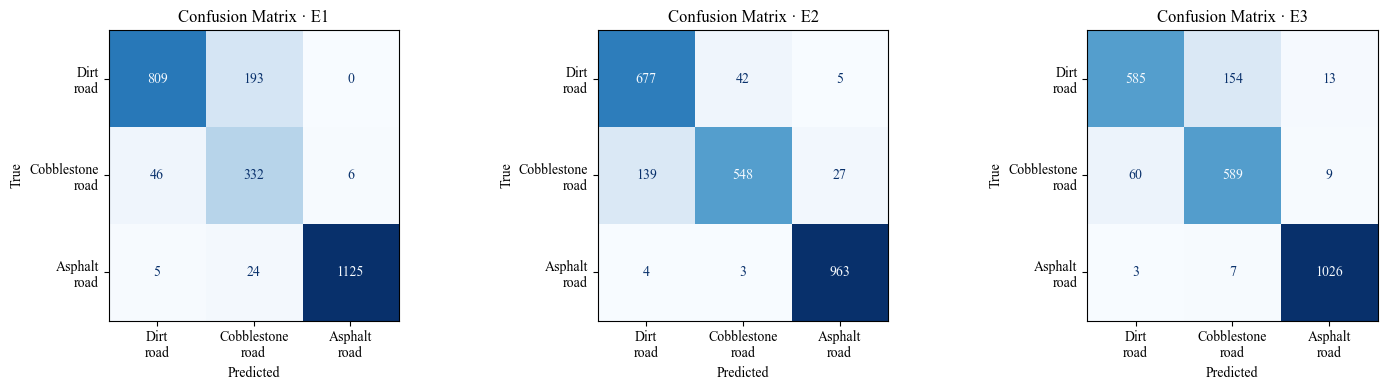

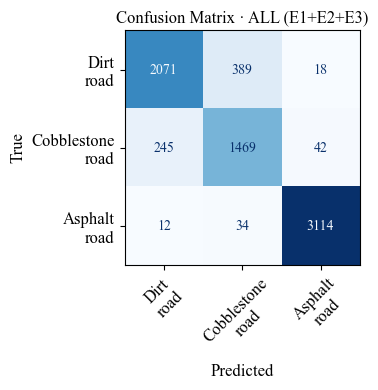

In [30]:
# Cell 11: Confusion matrices (per-exp và tổng)

LABEL_NAMES = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]
CLASS_IDS   = [0, 1, 2]

exps = ["E1", "E2", "E3"]
y_tests, y_preds = {}, {}

# Tái huấn luyện + dự đoán trên test cho từng exp để vẽ CM
for exp in exps:
    print(f"[CM] Refit & predict on {exp}")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = LGBMClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_tests[exp] = y_test
    y_preds[exp] = y_pred

# --- Hình 1: 1 hàng 3 cột (E1/E2/E3) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, exp in enumerate(exps):
    ax = axes[idx]
    cm = confusion_matrix(y_tests[exp], y_preds[exp], labels=CLASS_IDS)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix · {exp}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# --- Hình 2: Tổng (gộp E1+E2+E3) ---
y_all_true = np.concatenate([y_tests[e] for e in exps], axis=0)
y_all_pred = np.concatenate([y_preds[e] for e in exps], axis=0)
cm_all = confusion_matrix(y_all_true, y_all_pred, labels=CLASS_IDS)

fig2, ax2 = plt.subplots(1, 1, figsize=(4, 4))
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=LABEL_NAMES)
disp_all.plot(ax=ax2, values_format='d', cmap="Blues", colorbar=False)
ax2.set_title("Confusion Matrix · ALL (E1+E2+E3)")
ax2.set_xlabel("Predicted", fontsize=12)
ax2.set_ylabel("True", fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 12 — Classification report

In [31]:
# Cell 12: Classification reports (per-exp và tổng)

exps = ["E1", "E2", "E3"]

# for exp in exps:
#     print(f"\n===== Classification Report · {exp} =====")
#     print(classification_report(
#         y_tests[exp],
#         y_preds[exp],
#         labels=[0,1,2],
#         target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
#         digits=4
#     ))

print("\n===== Classification Report · ALL (E1+E2+E3) =====")
print(classification_report(
    y_all_true,
    y_all_pred,
    labels=[0,1,2],
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))



===== Classification Report · ALL (E1+E2+E3) =====
                  precision    recall  f1-score   support

       Dirt road     0.8896    0.8358    0.8618      2478
Cobblestone road     0.7764    0.8366    0.8054      1756
    Asphalt road     0.9811    0.9854    0.9833      3160

        accuracy                         0.8999      7394
       macro avg     0.8824    0.8859    0.8835      7394
    weighted avg     0.9018    0.8999    0.9003      7394



## Cell 13 — Huấn luyện trên toàn bộ PVS và xuất mã C

In [32]:
# Cell 13: Huấn luyện trên toàn bộ PVS và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_LGBM = LGBMClassifier(**BEST_PARAMS, random_state=42)
final_clf_LGBM.fit(X_all, y_all)

# Xuất mô hình sang header C/C++ bằng m2cgen
header_file = "m2cgen_PVS_LGBM.h"

try:
    c_cpp_code = export_to_c(final_clf_LGBM)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 7180, number of used features: 80
[LightGBM] [Info] Start training from score -1.280154
[LightGBM] [Info] Start training from score -1.231269
[LightGBM] [Info] Start training from score -0.843776


✅ Exported to 'm2cgen_PVS_LGBM.h'
📦 Header size: 785.08 KB (0.767 MB)


# 1 vị trí riêng lẻ - below

## Cell 1 — Imports, cấu hình & định nghĩa Experiments 1–3

In [33]:
# Cell 1: Imports, constants, experiments
import os, json, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from m2cgen.exporters import export_to_c

# Thiết lập font mặc định Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Gốc thư mục PVS
BASE_DIR = r"D:\BVHoan\Spiiras Proceedings\Passive Vehicular Sensors Datasets"
PVS_FOLDERS = [os.path.join(BASE_DIR, f"PVS {i}") for i in range(1, 10)]

# Cấu hình phân đoạn
WINDOW_SIZE = 600
STRIDE = 300

# =========================
# Chọn thủ công cấu hình sensor
# =========================
# Hỗ trợ: "dashboard","above","below",
#         "dashboard+above", "dashboard+below", "above+below",
#         "dashboard+above+below"
ACTIVE_PRESET = "below"  # <-- chỉnh tại đây khi muốn thử cấu hình khác

# Định nghĩa các kênh IMU cho từng vị trí (mỗi vị trí có cả L/R; tên cột giống nhau giữa left/right CSV)
DASH_IMU = [
    "acc_x_dashboard", "acc_y_dashboard", "acc_z_dashboard",
    "gyro_x_dashboard", "gyro_y_dashboard", "gyro_z_dashboard",
]
ABOVE_IMU = [
    "acc_x_above_suspension", "acc_y_above_suspension", "acc_z_above_suspension",
    "gyro_x_above_suspension", "gyro_y_above_suspension", "gyro_z_above_suspension",
]
BELOW_IMU = [
    "acc_x_below_suspension", "acc_y_below_suspension", "acc_z_below_suspension",
    "gyro_x_below_suspension", "gyro_y_below_suspension", "gyro_z_below_suspension",
]

# Bảng preset (chỉ liệt kê kênh IMU; cột speed sẽ được thêm một lần ở cuối)
SENSOR_PRESETS = {
    "dashboard": DASH_IMU,
    "above": ABOVE_IMU,
    "below": BELOW_IMU,
    "dashboard+above": DASH_IMU + ABOVE_IMU,
    "dashboard+below": DASH_IMU + BELOW_IMU,
    "above+below": ABOVE_IMU + BELOW_IMU,
    "dashboard+above+below": DASH_IMU + ABOVE_IMU + BELOW_IMU,
}

def choose_active_preset(name: str, include_speed: bool = True):
    if name not in SENSOR_PRESETS:
        raise ValueError(f"Unknown preset '{name}'. Allowed: {list(SENSOR_PRESETS.keys())}")
    cols = list(SENSOR_PRESETS[name])  # copy
    if include_speed:
        cols = cols + ["speed"]  # chỉ một cột speed dùng chung cho toàn cấu hình
    return cols

# Danh sách cột đầu vào cho run hiện tại
SENSOR_COLUMNS = choose_active_preset(ACTIVE_PRESET, include_speed=True)

print(f"✅ Using preset: {ACTIVE_PRESET}")
print(f"   → #IMU channels (không tính speed): {len(SENSOR_COLUMNS) - 1}")
print(f"   → Tổng số kênh (đã gồm speed):      {len(SENSOR_COLUMNS)}")

# Nhãn tác vụ chính (mutually exclusive)
LABEL_COLUMNS = ["dirt_road", "cobblestone_road", "asphalt_road"]

# Cấu hình chia theo Menegazzo
EXPERIMENTS = {
    1: {"train": ["PVS 1", "PVS 3", "PVS 4", "PVS 6", "PVS 7", "PVS 9"],
        "test":  ["PVS 2", "PVS 5", "PVS 8"]},
    2: {"train": ["PVS 1", "PVS 2", "PVS 3", "PVS 7", "PVS 8", "PVS 9"],
        "test":  ["PVS 4", "PVS 5", "PVS 6"]},
    3: {"train": ["PVS 1", "PVS 2", "PVS 4", "PVS 6", "PVS 8", "PVS 9"],
        "test":  ["PVS 3", "PVS 5", "PVS 7"]},
}


✅ Using preset: below
   → #IMU channels (không tính speed): 6
   → Tổng số kênh (đã gồm speed):      7


## Cell 2 — I/O & kiểm tra: đọc 3 file trong 1 PVS, cửa sổ, majority label

In [34]:
# Cell 2: IO, validation, windowing, majority label

def load_pvs_triplet(pvs_dir: str):
    """
    Đọc 3 file trong một thư mục PVS:
      - dataset_gps_mpu_left.csv
      - dataset_gps_mpu_right.csv
      - dataset_labels.csv
    Trả về (left_df, right_df, labels_df) và kiểm tra cấu trúc tối thiểu
    theo cấu hình cột hiện hành (SENSOR_COLUMNS từ Cell 1).
    """
    left_path  = os.path.join(pvs_dir, "dataset_gps_mpu_left.csv")
    right_path = os.path.join(pvs_dir, "dataset_gps_mpu_right.csv")
    label_path = os.path.join(pvs_dir, "dataset_labels.csv")

    if not (os.path.exists(left_path) and os.path.exists(right_path) and os.path.exists(label_path)):
        raise FileNotFoundError(f"Missing one of required files in: {pvs_dir}")

    left_df  = pd.read_csv(left_path)
    right_df = pd.read_csv(right_path)
    labels_df= pd.read_csv(label_path)

    # Hàng phải khớp 1–1 giữa 3 file (đồng bộ theo chỉ số dòng)
    if not (len(left_df) == len(right_df) == len(labels_df)):
        raise ValueError(
            f"Row mismatch in {pvs_dir}: left={len(left_df)}, right={len(right_df)}, labels={len(labels_df)}"
        )

    # --- Kiểm tra cột theo preset hiện hành ---
    # Tất cả kênh trừ 'speed' phải có ở cả left và right.
    imu_cols = [c for c in SENSOR_COLUMNS if c != "speed"]
    missing_imu = [c for c in imu_cols if (c not in left_df.columns or c not in right_df.columns)]
    if missing_imu:
        raise KeyError(f"Missing IMU columns {missing_imu} in {pvs_dir} (left/right)")

    # 'speed' phải có ít nhất ở một trong hai file (giá trị hai phía giống nhau là mong đợi)
    if "speed" in SENSOR_COLUMNS:
        has_speed_left  = "speed" in left_df.columns
        has_speed_right = "speed" in right_df.columns
        if not (has_speed_left or has_speed_right):
            raise KeyError(f"Missing column 'speed' in {pvs_dir} (neither left nor right)")

        # Nếu có ở cả hai, kiểm tra gần như nhau (sanity check, không dừng nếu lệch rất nhỏ do làm tròn)
        if has_speed_left and has_speed_right:
            try:
                if not np.allclose(left_df["speed"].values, right_df["speed"].values, atol=1e-6, rtol=1e-6):
                    print(f"[Warn] 'speed' differs between left/right in {pvs_dir}. "
                          f"Values should be identical (GPS shared). Proceeding with files as-is.")
            except Exception:
                # Trường hợp dtype lạ hoặc NaN; chỉ cảnh báo nhẹ
                print(f"[Warn] Could not compare 'speed' columns in {pvs_dir} due to dtype/NaN issues.")

    # Cột nhãn one-hot bắt buộc
    for col in LABEL_COLUMNS:
        if col not in labels_df.columns:
            raise KeyError(f"Label column '{col}' missing in {pvs_dir}/dataset_labels.csv")

    return left_df, right_df, labels_df

def window_indices(n_samples: int, window: int, stride: int):
    """Sinh danh sách (start, end) cho các cửa sổ trượt."""
    idx = []
    start = 0
    while start + window <= n_samples:
        idx.append((start, start + window))
        start += stride
    return idx

def majority_label_onehot(block_labels, label_cols=LABEL_COLUMNS):
    """
    Lấy nhãn majority trong cửa sổ theo tổng one-hot; khi hòa,
    dùng mode() giống Menegazzo.
    """
    sums = block_labels[label_cols].sum(axis=0)
    max_sum = sums.max()
    tied = [cls for cls, val in sums.items() if val == max_sum]
    if len(tied) == 1:
        return tied[0]
    # dùng mode() giống Menegazzo
    mode_label = block_labels[label_cols].mode().iloc[0]
    for cls in label_cols:
        if mode_label[cls] == 1:
            return cls
    return tied[0]


## Cell 3 — Phân đoạn một lần duy nhất và gắn provenance PVS

In [35]:
# Cell 3: Single-pass segmentation with provenance (both sides as independent samples)

def build_windows_by_pvs(pvs_folders):
    """
    Trả về:
      windows_by_pvs = {
        'PVS 1': {'dirt_road': [np.array(WINDOW_SIZE, n_channels), ...],
                  'cobblestone_road': [...],
                  'asphalt_road': [...]},
        ...
      }
    Mỗi cửa sổ là một mẫu; left/right được coi là 2 mẫu độc lập (đúng Menegazzo).
    """
    windows_by_pvs = {}
    global_summary = Counter()

    for pvs_dir in pvs_folders:
        pvs_name = os.path.basename(pvs_dir)  # "PVS i"
        try:
            left_df, right_df, labels_df = load_pvs_triplet(pvs_dir)
        except Exception as e:
            print(f"[WARN] Skip {pvs_name}: {e}")
            continue

        # -----------------------------
        # 1) Chuẩn bị tín hiệu đầu vào
        # -----------------------------
        # Sao chép SENSOR_COLUMNS để tách speed riêng
        cols_no_speed = [c for c in SENSOR_COLUMNS if c != "speed"]
        include_speed = "speed" in SENSOR_COLUMNS

        # Các cột IMU phải có ở cả left & right
        left_sig_imu  = left_df[cols_no_speed].to_numpy(dtype=np.float32)
        right_sig_imu = right_df[cols_no_speed].to_numpy(dtype=np.float32)

        # Speed: chỉ lấy một nguồn (left ưu tiên)
        if include_speed:
            if "speed" in left_df.columns:
                speed_vec = left_df["speed"].to_numpy(dtype=np.float32)
            else:
                speed_vec = right_df["speed"].to_numpy(dtype=np.float32)
            speed_vec = speed_vec.reshape(-1, 1)
            # Ghép speed thành cột cuối
            left_sig  = np.hstack([left_sig_imu,  speed_vec])
            right_sig = np.hstack([right_sig_imu, speed_vec])
        else:
            left_sig, right_sig = left_sig_imu, right_sig_imu

        # -----------------------------
        # 2) Xử lý nhãn
        # -----------------------------
        labels_main = labels_df[LABEL_COLUMNS].astype(int)
        n = len(labels_main)
        win_idxs = window_indices(n, WINDOW_SIZE, STRIDE)
        if not win_idxs:
            print(f"[INFO] {pvs_name}: not enough samples for one window ({n} < {WINDOW_SIZE})")
            continue

        # -----------------------------
        # 3) Tạo kho lưu kết quả
        # -----------------------------
        windows_by_pvs.setdefault(pvs_name, {k: [] for k in LABEL_COLUMNS})

        # -----------------------------
        # 4) Cắt cửa sổ và gán nhãn
        # -----------------------------
        for (s, e) in win_idxs:
            cls = majority_label_onehot(labels_main.iloc[s:e], LABEL_COLUMNS)

            # Mỗi bên là một mẫu độc lập
            wL = left_sig[s:e, :]
            wR = right_sig[s:e, :]

            windows_by_pvs[pvs_name][cls].append(wL)
            windows_by_pvs[pvs_name][cls].append(wR)
            global_summary[cls] += 2

    # -----------------------------
    # 5) Log thống kê
    # -----------------------------
    print(f"=== Windows per PVS (preset: {ACTIVE_PRESET}) ===")
    for pvs_name in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
        line = [f"{cls}:{len(windows_by_pvs[pvs_name][cls])}" for cls in LABEL_COLUMNS]
        print(f"{pvs_name} -> " + " | ".join(line))

    print("\n=== Global class totals ===")
    for cls in LABEL_COLUMNS:
        print(f"{cls:17s}: {global_summary[cls]}")

    return windows_by_pvs

# Thực thi để sinh dữ liệu phân đoạn
windows_by_pvs = build_windows_by_pvs(PVS_FOLDERS)


=== Windows per PVS (preset: below) ===
PVS 1 -> dirt_road:172 | cobblestone_road:412 | asphalt_road:374
PVS 2 -> dirt_road:298 | cobblestone_road:138 | asphalt_road:392
PVS 3 -> dirt_road:190 | cobblestone_road:176 | asphalt_road:336
PVS 4 -> dirt_road:160 | cobblestone_road:384 | asphalt_road:336
PVS 5 -> dirt_road:404 | cobblestone_road:120 | asphalt_road:366
PVS 6 -> dirt_road:160 | cobblestone_road:210 | asphalt_road:268
PVS 7 -> dirt_road:158 | cobblestone_road:362 | asphalt_road:334
PVS 8 -> dirt_road:300 | cobblestone_road:126 | asphalt_road:396
PVS 9 -> dirt_road:154 | cobblestone_road:168 | asphalt_road:286

=== Global class totals ===
dirt_road        : 1996
cobblestone_road : 2096
asphalt_road     : 3088


## Cell 4 — Tạo đủ 3 splits theo Menegazzo và in thống kê

In [36]:
# Cell 4: Build ALL 3 Menegazzo splits + stats

def _collect_from_pvs(pvs_list, windows_by_pvs, label_cols=LABEL_COLUMNS):
    bucket = {c: [] for c in label_cols}
    for pvs in pvs_list:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing; skipping.")
            continue
        for cls in label_cols:
            bucket[cls].extend(windows_by_pvs[pvs][cls])
    return bucket

def _print_split_stats(exp_id, split_name, lists_by_class, label_cols=LABEL_COLUMNS):
    total = sum(len(v) for v in lists_by_class.values())
    print(f"[Experiment {exp_id} · {split_name.upper()}] Total windows: {total}")
    for cls in label_cols:
        print(f"  {cls:17s}: {len(lists_by_class[cls])}")

def make_all_splits(windows_by_pvs, experiments=EXPERIMENTS):
    """
    Trả về:
      splits = {
        1: {"train": {"dirt_road":[...], ...}, "test": {...}},
        2: {...},
        3: {...}
      }
    """
    splits = {}
    for exp_id, conf in experiments.items():
        tr_pvs, te_pvs = conf["train"], conf["test"]
        train_lists = _collect_from_pvs(tr_pvs, windows_by_pvs)
        test_lists  = _collect_from_pvs(te_pvs, windows_by_pvs)

        splits[exp_id] = {"train": train_lists, "test": test_lists}

        print(f"=== Experiment {exp_id} ===")
        _print_split_stats(exp_id, "train", train_lists)
        _print_split_stats(exp_id, "test",  test_lists)

    return splits

splits = make_all_splits(windows_by_pvs)


=== Experiment 1 ===
[Experiment 1 · TRAIN] Total windows: 4640
  dirt_road        : 994
  cobblestone_road : 1712
  asphalt_road     : 1934
[Experiment 1 · TEST] Total windows: 2540
  dirt_road        : 1002
  cobblestone_road : 384
  asphalt_road     : 1154
=== Experiment 2 ===
[Experiment 2 · TRAIN] Total windows: 4772
  dirt_road        : 1272
  cobblestone_road : 1382
  asphalt_road     : 2118
[Experiment 2 · TEST] Total windows: 2408
  dirt_road        : 724
  cobblestone_road : 714
  asphalt_road     : 970
=== Experiment 3 ===
[Experiment 3 · TRAIN] Total windows: 4734
  dirt_road        : 1244
  cobblestone_road : 1438
  asphalt_road     : 2052
[Experiment 3 · TEST] Total windows: 2446
  dirt_road        : 752
  cobblestone_road : 658
  asphalt_road     : 1036


## Cell 5 — Sinh biến cho cả 3 experiment (không ghi đè nhau)

In [37]:
# Cell 5: Variables for all 3 experiments with suffixes _E1/_E2/_E3

def _vars_for_all_experiments(splits_dict):
    for exp_id in (1, 2, 3):
        sd = splits_dict[exp_id]

        globals()[f"train_dirt_road_E{exp_id}"]         = sd["train"]["dirt_road"]
        globals()[f"train_cobblestone_road_E{exp_id}"]  = sd["train"]["cobblestone_road"]
        globals()[f"train_asphalt_road_E{exp_id}"]      = sd["train"]["asphalt_road"]

        globals()[f"test_dirt_road_E{exp_id}"]          = sd["test"]["dirt_road"]
        globals()[f"test_cobblestone_road_E{exp_id}"]   = sd["test"]["cobblestone_road"]
        globals()[f"test_asphalt_road_E{exp_id}"]       = sd["test"]["asphalt_road"]

_vars_for_all_experiments(splits)

# peek a few counts so you can sanity-check at a glance
for k in ("train_dirt_road", "train_cobblestone_road", "train_asphalt_road",
          "test_dirt_road", "test_cobblestone_road", "test_asphalt_road"):
    for e in (1, 2, 3):
        v = globals()[f"{k}_E{e}"]
        print(f"{k}_E{e:1d}: {len(v)} windows")


train_dirt_road_E1: 994 windows
train_dirt_road_E2: 1272 windows
train_dirt_road_E3: 1244 windows
train_cobblestone_road_E1: 1712 windows
train_cobblestone_road_E2: 1382 windows
train_cobblestone_road_E3: 1438 windows
train_asphalt_road_E1: 1934 windows
train_asphalt_road_E2: 2118 windows
train_asphalt_road_E3: 2052 windows
test_dirt_road_E1: 1002 windows
test_dirt_road_E2: 724 windows
test_dirt_road_E3: 752 windows
test_cobblestone_road_E1: 384 windows
test_cobblestone_road_E2: 714 windows
test_cobblestone_road_E3: 658 windows
test_asphalt_road_E1: 1154 windows
test_asphalt_road_E2: 970 windows
test_asphalt_road_E3: 1036 windows


## Cell 6 — Tạo data_train/data_test + label_train/label_test cho từng experiment

In [38]:
# Cell 6: Build data_/label_ arrays for EACH experiment,
# groups cho mỗi cửa sổ (train/test) theo PVS (để dùng Group-aware CV)

def _vars_with_groups_for_experiment(exp_id):
    """
    Sinh data_/label_ + groups_ cho exp_id.
    Group = tên PVS của cửa sổ đó.
    Dùng danh sách cột linh hoạt SENSOR_COLUMNS (theo preset đã chọn).
    """
    data_train, label_train, groups_train = [], [], []

    # --- Build TRAIN ---
    for pvs in EXPERIMENTS[exp_id]["train"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TRAIN")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                # mỗi acts là np.array(window_size, n_channels)
                data_train.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_train.append(lab)
                groups_train.append(pvs)

    # --- Build TEST ---
    data_test, label_test, groups_test = [], [], []
    for pvs in EXPERIMENTS[exp_id]["test"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TEST")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                data_test.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_test.append(lab)
                groups_test.append(pvs)

    # --- Lưu vào biến toàn cục ---
    globals()[f"data_train_E{exp_id}"]   = data_train
    globals()[f"label_train_E{exp_id}"]  = label_train
    globals()[f"groups_train_E{exp_id}"] = groups_train

    globals()[f"data_test_E{exp_id}"]    = data_test
    globals()[f"label_test_E{exp_id}"]   = label_test
    globals()[f"groups_test_E{exp_id}"]  = groups_test

# Rebuild để có groups (E1–E3)
_vars_with_groups_for_experiment(1)
_vars_with_groups_for_experiment(2)
_vars_with_groups_for_experiment(3)

print("E1:", len(data_train_E1), "train /", len(data_test_E1), "test | #groups(train) =", len(set(groups_train_E1)))
print("E2:", len(data_train_E2), "train /", len(data_test_E2), "test | #groups(train) =", len(set(groups_train_E2)))
print("E3:", len(data_train_E3), "train /", len(data_test_E3), "test | #groups(train) =", len(set(groups_train_E3)))


E1: 4640 train / 2540 test | #groups(train) = 6
E2: 4772 train / 2408 test | #groups(train) = 6
E3: 4734 train / 2446 test | #groups(train) = 6


## Cell 7 — Feature extraction

In [39]:
# # Cell 7: Trích xuất đặc trưng

# def featuresFromBuffer(at):
#     feat = np.zeros(80, dtype=np.float32)
    
#     # ---- BELOW ----
#     ax_below = np.array(at['acc_x_below_suspension'],  dtype=np.float32)
#     ay_below = np.array(at['acc_y_below_suspension'],  dtype=np.float32)
#     az_below = np.array(at['acc_z_below_suspension'],  dtype=np.float32)
#     gx_below = np.array(at['gyro_x_below_suspension'], dtype=np.float32)
#     gy_below = np.array(at['gyro_y_below_suspension'], dtype=np.float32)
#     gz_below = np.array(at['gyro_z_below_suspension'], dtype=np.float32)    
    
#     # ---- SPEED (chung) ----
#     sp = np.array(at['speed'], dtype=np.float32)
    
#     # Đặc trưng thống kê    
#     feat[0:7] = [np.mean(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below, sp]] # mean
#     feat[7:14] = [np.std(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below, sp]] # sd
#     feat[14:20] = [np.sqrt(np.mean(i**2)) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # rms
#     feat[20:26] = [np.max(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # max
#     feat[26:32] = [np.min(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # min
#     feat[32:38] = [np.amax(i) - np.amin(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # range
#     feat[38:44] = [np.median(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # median
#     feat[44:50] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # interquartile range
#     feat[50:56] = [skew(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # skewness
#     feat[56:62] = [kurtosis(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # kurtosis
#     feat[62:68] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # hjorth mobility
#     feat[68:74] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # hjorth complexity
#     feat[74:80] = [acf(i, nlags=1)[1] for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # autocorrelation
    
#     return feat

# # Trích xuất đặc trưng cho từng cửa sổ
# train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
# test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
# train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
# test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
# train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
# test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

# # Ép sang numpy array
# train_features_E1 = np.array(train_features_E1, dtype=np.float32)
# test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
# train_features_E2 = np.array(train_features_E2, dtype=np.float32)
# test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
# train_features_E3 = np.array(train_features_E3, dtype=np.float32)
# test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

# print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
# print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
# print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
# print('Feature dimension:', train_features_E1.shape[1])

# # Gom toàn bộ dữ liệu từ PVS 1..9 (tránh dùng E1/E2/E3 để không đếm trùng)
# cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
# X_all, y_all = [], []

# # Đảm bảo thứ tự PVS 1..9 ổn định
# for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#     for cls_name, cls_id in cls_map:
#         for buf in windows_by_pvs[pvs][cls_name]:
#             # buf là ndarray (WINDOW_SIZE x len(SENSOR_COLUMNS))
#             at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#             feat = featuresFromBuffer(at)
#             X_all.append(feat)
#             y_all.append(cls_id)

# X_all = np.asarray(X_all, dtype=np.float32)
# y_all = np.asarray(y_all, dtype=np.int32)
# print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))


## Cell 7A — Tính & Lưu cache

In [40]:
# # Cell 7A: Compute & cache features for the current ACTIVE_PRESET

# def _extract_features_for_splits():
#     # y nguyên format Cell 7: tạo các mảng đặc trưng cho E1/E2/E3
#     train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
#     test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
#     train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
#     test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
#     train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
#     test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

#     # Ép sang numpy array
#     train_features_E1 = np.array(train_features_E1, dtype=np.float32)
#     test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
#     train_features_E2 = np.array(train_features_E2, dtype=np.float32)
#     test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
#     train_features_E3 = np.array(train_features_E3, dtype=np.float32)
#     test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

#     return (train_features_E1, test_features_E1,
#             train_features_E2, test_features_E2,
#             train_features_E3, test_features_E3)

# def _extract_features_all_pvs():
#     # Y nguyên logic gom ALL PVS (tránh đếm trùng E1/E2/E3)
#     cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
#     X_all, y_all = [], []

#     for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#         for cls_name, cls_id in cls_map:
#             for buf in windows_by_pvs[pvs][cls_name]:
#                 at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#                 feat = featuresFromBuffer(at)
#                 X_all.append(feat)
#                 y_all.append(cls_id)

#     X_all = np.asarray(X_all, dtype=np.float32)
#     y_all = np.asarray(y_all, dtype=np.int32)
#     return X_all, y_all

# def _save_feature_cache(fname,
#                         train_features_E1, test_features_E1,
#                         train_features_E2, test_features_E2,
#                         train_features_E3, test_features_E3,
#                         X_all, y_all):
#     # Lưu gọn bằng NPZ nén
#     np.savez_compressed(
#         fname,
#         ACTIVE_PRESET=np.array([ACTIVE_PRESET]),
#         SENSOR_COLUMNS=np.array(SENSOR_COLUMNS),
#         WINDOW_SIZE=np.array([WINDOW_SIZE], dtype=np.int32),
#         STRIDE=np.array([STRIDE], dtype=np.int32),
#         LABEL_COLUMNS=np.array(LABEL_COLUMNS),

#         train_features_E1=train_features_E1,
#         test_features_E1=test_features_E1,
#         train_features_E2=train_features_E2,
#         test_features_E2=test_features_E2,
#         train_features_E3=train_features_E3,
#         test_features_E3=test_features_E3,

#         X_all=X_all,
#         y_all=y_all
#     )

# # ---- Thực thi: tính & lưu ----
# cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
# print(f"⏳ Computing features for preset: {ACTIVE_PRESET} ...")

# (train_features_E1, test_features_E1,
#  train_features_E2, test_features_E2,
#  train_features_E3, test_features_E3) = _extract_features_for_splits()

# print("   • Splits done:",
#       f"E1: {train_features_E1.shape} / {test_features_E1.shape} |",
#       f"E2: {train_features_E2.shape} / {test_features_E2.shape} |",
#       f"E3: {train_features_E3.shape} / {test_features_E3.shape}")

# X_all, y_all = _extract_features_all_pvs()
# print("   • ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))

# _save_feature_cache(cache_name,
#                     train_features_E1, test_features_E1,
#                     train_features_E2, test_features_E2,
#                     train_features_E3, test_features_E3,
#                     X_all, y_all)

# size_bytes = os.path.getsize(cache_name)
# print(f"✅ Saved cache to '{cache_name}' ({size_bytes/1024/1024:.3f} MB)")


## Cell 7B — Nạp cache (dùng cho chạy nhanh về sau)

In [41]:
# Cell 7B: Load cached feature set for the current ACTIVE_PRESET

cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
if not os.path.exists(cache_name):
    raise FileNotFoundError(f"Feature cache not found: {cache_name}. Hãy chạy Cell 7A trước để tạo cache.")

data = np.load(cache_name, allow_pickle=True)

# Khôi phục biến đúng tên như Cell 7 gốc
train_features_E1 = data["train_features_E1"]
test_features_E1  = data["test_features_E1"]
train_features_E2 = data["train_features_E2"]
test_features_E2  = data["test_features_E2"]
train_features_E3 = data["train_features_E3"]
test_features_E3  = data["test_features_E3"]

X_all = data["X_all"]
y_all = data["y_all"]

# (tuỳ chọn) kiểm tra meta để cảnh báo nếu lệch preset
_cached_preset = str(data["ACTIVE_PRESET"][0])
if _cached_preset != ACTIVE_PRESET:
    print(f"[WARN] Cache preset = '{_cached_preset}' khác với ACTIVE_PRESET hiện tại = '{ACTIVE_PRESET}'")

# In thống kê giống Cell 7 gốc
print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
print('Feature dimension:', train_features_E1.shape[1])
print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))
print(f"✅ Loaded cache from '{cache_name}'")


E1: 4640 train samples / 2540 test samples
E2: 4772 train samples / 2408 test samples
E3: 4734 train samples / 2446 test samples
Feature dimension: 80
ALL PVS: (7180, 80) | class dist: [1996 2096 3088]
✅ Loaded cache from 'feature_set_below.npz'


## Cell 8 — Find candidates

In [42]:
# Cell 8: Find candidates, LOGO trên 3 experiment → lấy 3 bộ tham số ứng viên (Accuracy), kèm kiểm tra model size ≤ 1.00 MB
print(f"✅ Using preset: {ACTIVE_PRESET}")

# Định nghĩa grid riêng cho từng exp
param_grids = {
    "E1": {
        "n_estimators": list(range(47, 51)),
        "max_depth": list(range(10, 12))
    },
    "E2": {
        "n_estimators": list(range(49, 50)),
        "max_depth": list(range(7, 8))
    },
    "E3": {
        "n_estimators": list(range(50, 51)),
        "max_depth": list(range(5, 6))
    }
}

# ---------------------- HÀM ĐO SIZE ----------------------
def measure_model_size_mb(params, X_full, y_full):
    """
    Train LGBMClassifier trên toàn bộ dữ liệu với 'params',
    export C/C++ header bằng m2cgen.exporters.export_to_c() rồi đo kích thước (MB).
    Trả về (size_mb, error_msg, c_code).
    """
    clf = LGBMClassifier(**params, random_state=42)
    clf.fit(X_full, y_full)

    tmp_header = None
    c_code = None
    err = ""
    size_mb = None
    try:
        c_code = export_to_c(clf)
        with tempfile.NamedTemporaryFile(mode="w", suffix=".h", delete=False, encoding="utf-8") as f:
            tmp_header = f.name
            f.write(c_code)

        size_bytes = os.path.getsize(tmp_header)
        size_mb = size_bytes / (1024 * 1024)
    except Exception as e:
        err = str(e)
    finally:
        if tmp_header and os.path.exists(tmp_header):
            os.remove(tmp_header)

    return size_mb, err, c_code

# ---------------------- HÀM LOGO + GRIDSEARCH CHO 1 EXP ----------------------
def run_logo_for_experiment(exp_name, X_train, y_train, groups, X_full_for_size, y_full_for_size,
                            param_grid, size_limit_mb=1.00):
    """
    - Chạy GridSearchCV với LOGO (Accuracy) trên (X_train, y_train, groups).
    - Với từng bộ params trong kết quả, train lại trên toàn bộ PVS 1–9 để đo size.
    - Chọn bộ params có:
        * size ≤ size_limit_mb
        * điểm cv (mean test Accuracy) cao nhất
      Tie-break: model nhỏ hơn → depth thấp hơn → số cây ít hơn.
    - Trả về dict ứng viên cho exp này.
    """
    print(f"\n===== EXP {exp_name}: START LOGO GRID (Accuracy) + SIZE CHECK ≤ {size_limit_mb:.2f} MB =====")
    logo = LeaveOneGroupOut()
    gs = GridSearchCV(
        estimator=LGBMClassifier(random_state=42),
        param_grid=param_grid,
        cv=logo.split(X_train, y_train, groups=groups),
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    best_cv = -np.inf
    best = None

    for i, params in enumerate(gs.cv_results_["params"], 1):
        cv_mean = gs.cv_results_["mean_test_score"][i-1]
        print(f"[{exp_name}] Check {i}/{len(gs.cv_results_['params'])}: {params} | CV Accuracy={cv_mean*100:.2f}")

        size_mb, err, _ = measure_model_size_mb(params, X_full_for_size, y_full_for_size)
        status = "ok"
        if err:
            status = f"error: {err}"
        elif size_mb is None:
            status = "error: size_none"
        elif size_mb > size_limit_mb:
            status = "oversize"

        print(f"   -> size={None if size_mb is None else f'{size_mb:.3f} MB'} | status={status}")

        if status == "ok":
            # update theo tiêu chí: cv cao nhất → size nhỏ hơn → depth thấp hơn → n_estimators ít hơn
            if (cv_mean > best_cv or
                (np.isclose(cv_mean, best_cv) and size_mb < best["size_mb"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] < best["params"]["max_depth"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] == best["params"]["max_depth"] and params["n_estimators"] < best["params"]["n_estimators"])
               ):
                best_cv = cv_mean
                best = {
                    "exp": exp_name,
                    "params": dict(params),
                    "cv_accuracy": float(cv_mean),
                    "size_mb": float(size_mb)
                }

    if best is None:
        best = {
            "exp": exp_name,
            "params": None,
            "cv_accuracy": None,
            "size_mb": None,
            "note": f"No feasible params ≤ {size_limit_mb:.2f} MB (or export error)"
        }
        print(f"[{exp_name}] WARNING: Không tìm thấy cấu hình khả thi (≤ {size_limit_mb:.2f} MB).")

    print(f"[{exp_name}] BEST CANDIDATE:", best)
    return best

candidates = []
candidates.append(run_logo_for_experiment("E1", train_features_E1, label_train_E1, groups_train_E1, X_all, y_all, param_grids["E1"]))
candidates.append(run_logo_for_experiment("E2", train_features_E2, label_train_E2, groups_train_E2, X_all, y_all, param_grids["E2"]))
candidates.append(run_logo_for_experiment("E3", train_features_E3, label_train_E3, groups_train_E3, X_all, y_all, param_grids["E3"]))

print("\n===== 3 ỨNG VIÊN LOGO (Accuracy, size≤1.00MB) =====")
for c in candidates:
    print(c)

# Lưu lại để dùng cho bước “chốt cuối”
with open("logo_candidates_LGBM.json", "w", encoding="utf-8") as f:
    json.dump(candidates, f, indent=2, ensure_ascii=False)

print("Đã lưu 3 ứng viên vào 'logo_candidates_LGBM.json'.")


✅ Using preset: below

===== EXP E1: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 80
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[E1] Check 1/8: {'max_depth': 10, 'n_estimators': 47} | CV Accuracy=89.60
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 7180, number of used features: 80
[LightGBM] [Info] Start training from score -1.280154
[LightGBM] [Info] Start training from score -1.231269
[Li

In [43]:
# mean, sd, rms, max, min, range, median, iqr, skew, kurt, hm, hc, acf
# {'exp': 'E1', 'params': {'max_depth': 10, 'n_estimators': 47}, 'cv_accuracy': 0.8960, 'size_mb': 0.753} -> 91.56 Mean - λ·Std
# {'exp': 'E2', 'params': {'max_depth': 07, 'n_estimators': 49}, 'cv_accuracy': 0.9175, 'size_mb': 0.725} -> 90.82 Maximin, Borda rank, Minimax regret
# {'exp': 'E3', 'params': {'max_depth': 05, 'n_estimators': 50}, 'cv_accuracy': 0.8933, 'size_mb': 0.480} -> 90.27

## Cell 9 — Select candidates

In [44]:
# Cell 9: Select candidates, thử 4 tiêu chí trên bộ ba ứng viên (train-only, LOGO)

# ========= NẠP 3 ỨNG VIÊN =========
with open("logo_candidates_LGBM.json", "r", encoding="utf-8") as f:
    candidates = json.load(f)

# Đặt tên ngắn gọn cho ứng viên theo exp gốc của nó: 'cand_E1', 'cand_E2', 'cand_E3'
for c in candidates:
    c["name"] = f"cand_{c['exp']}"

# ========= CHUẨN BỊ DỮ LIỆU TRAIN+GROUPS CHO 3 EXP =========
X_train_dict = {
    "E1": train_features_E1,
    "E2": train_features_E2,
    "E3": train_features_E3,
}
y_train_dict = {
    "E1": np.asarray(label_train_E1),
    "E2": np.asarray(label_train_E2),
    "E3": np.asarray(label_train_E3),
}
groups_dict = {
    "E1": np.asarray(groups_train_E1),
    "E2": np.asarray(groups_train_E2),
    "E3": np.asarray(groups_train_E3),
}

# ========= HÀM LOGO SCORE (Accuracy, train-only) =========
def logo_cv_accuracy_for_exp(params, X, y, groups):
    """
    Cố định bộ tham số 'params' => chạy LOGO trên (X,y,groups) => trả về mean Accuracy.
    """
    logo = LeaveOneGroupOut()
    f1s = []
    # Duyệt từng split LOGO
    for tr_idx, va_idx in logo.split(X, y, groups=groups):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        clf = LGBMClassifier(**params, random_state=42)
        clf.fit(X_tr, y_tr)
        y_hat = clf.predict(X_va)
        f1s.append(accuracy_score(y_va, y_hat))
    return float(np.mean(f1s))

# ========= TÍNH MA TRẬN ĐIỂM S_k(h) (k ∈ {E1,E2,E3}, h ∈ 3 ứng viên) =========
exps = ["E1", "E2", "E3"]
H = len(candidates)
K = len(exps)

scores = np.zeros((H, K), dtype=float)  # S[h,k] = Accuracy của ứng viên h trên exp k
for h, cand in enumerate(candidates):
    params = cand["params"]
    print(f"\n>>> Scoring {cand['name']} with params={params}")
    for k, ek in enumerate(exps):
        S_hk = logo_cv_accuracy_for_exp(params, X_train_dict[ek], y_train_dict[ek], groups_dict[ek])
        scores[h, k] = S_hk
        print(f"   {ek}: Accuracy(LOGO) = {S_hk*100:.2f}")

# ========= TIỆN ÍCH: TIE-BREAK =========
def tie_break_key(h):
    # size nhỏ hơn → depth nhỏ hơn → n_estimators ít hơn
    size = candidates[h].get("size_mb", np.inf)
    depth = candidates[h]["params"]["max_depth"]
    trees = candidates[h]["params"]["n_estimators"]
    return (size, depth, trees)

# ========= 1) MAXIMIN =========
worst_case = scores.min(axis=1)             # min_k S_k(h)
best_h_maximin = max(range(H), key=lambda h: (worst_case[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= 2) BORDA RANK =========
def ranks_desc(vals):
    """
    Trả về rank (1 = tốt nhất) theo thứ tự giảm dần của vals.
    Ties => average-rank.
    """
    vals = np.asarray(vals)
    # sắp xếp giảm dần
    order = np.argsort(-vals)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(vals) + 1, dtype=float)
    # xử lý ties (average rank)
    for v in np.unique(vals):
        idx = np.where(vals == v)[0]
        if len(idx) > 1:
            avg = ranks[idx].mean()
            ranks[idx] = avg
    return ranks

borda = np.zeros(H, dtype=float)
for k in range(K):
    borda += ranks_desc(scores[:, k])
best_h_borda = min(range(H), key=lambda h: (borda[h], tie_break_key(h)))

# ========= 3) MINIMAX REGRET =========
best_per_exp = scores.max(axis=0)           # S*_k
regret = best_per_exp - scores              # Reg_k(h) = S*_k - S_k(h)
max_regret = regret.max(axis=1)             # max_k Reg_k(h)
best_h_regret = min(range(H), key=lambda h: (max_regret[h], tie_break_key(h)))

# ========= 4) MEAN − λ·STD (λ suy từ dữ liệu) =========
means = scores.mean(axis=1)
stds  = scores.std(axis=1, ddof=0)

sigma_typ = float(np.median(stds))
c_pp = 0.01  # 1.0 điểm phần trăm F1  => 0.01 theo thang [0,1]
# Nếu bạn thích 0.5–1.5 pp, đổi c_pp = 0.005 ~ 0.015
if sigma_typ > 0:
    lam = c_pp / sigma_typ
else:
    lam = 0.1
lam = float(np.clip(lam, 0.1, 1.0))

risk_adj = means - lam * stds
best_h_mean_std = max(range(H), key=lambda h: (risk_adj[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= IN KẾT QUẢ =========
def pretty_candidate(h):
    c = candidates[h]
    return {
        "name": c["name"],
        "params": c["params"],
        "size_mb": round(float(c.get("size_mb", np.nan)), 3),
        "S_E1": round(scores[h,0]*100, 2),
        "S_E2": round(scores[h,1]*100, 2),
        "S_E3": round(scores[h,2]*100, 2),
        "mean": round(means[h]*100, 2),
        "std": round(stds[h], 2)
    }

print("\n===== SCORE MATRIX (Accuracy, train-only LOGO) =====")
for h in range(H):
    print(pretty_candidate(h))

print("\n===== SELECTIONS (4 tiêu chí) =====")
print(f"Maximin         -> {pretty_candidate(best_h_maximin)}")
print(f"Borda rank      -> {pretty_candidate(best_h_borda)}")
print(f"Minimax regret  -> {pretty_candidate(best_h_regret)}")
print(f"Mean - λ·Std    -> {pretty_candidate(best_h_mean_std)}  (λ = {lam:.4f}, c_pp={c_pp})")



>>> Scoring cand_E1 with params={'max_depth': 10, 'n_estimators': 47}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 80
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3938, number of used features: 80
[LightGBM] [Info] Start training from score -1.588829
[LightGBM] [Info] Start training from score -0.941491
[LightGBM] [Info] Start training from score -0.901920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 80
[LightGBM] [Info] Start training from score -1.505941
[LightGBM] [Info] Start training from score -1.040745
[LightGBM] [Info] Start training from score -0.855666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4002, number of used features: 80
[LightGBM] [Info] Start training from score -1.568316
[LightGBM] [Info] Start training from score -0.979997
[LightGBM] [Info] Start training from score -0.876369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3786, number of used features: 80
[LightGBM] [Info] Start training from score -1.510437
[LightGBM] [Info] Start training from score -1.031205
[LightGBM] [Info] Start training from score -0.861306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4032, number of used features: 80
[LightGBM] [Info] Start training from score -1.568616
[LightGBM] [Info] Start training from score -0.959886
[LightGBM] [Info] Start training from score -0.894700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E1: Accuracy(LOGO) = 89.60


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3814, number of used features: 80
[LightGBM] [Info] Start training from score -1.243368
[LightGBM] [Info] Start training from score -1.369138
[LightGBM] [Info] Start training from score -0.782497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 80
[LightGBM] [Info] Start training from score -1.398539
[LightGBM] [Info] Start training from score -1.153863
[LightGBM] [Info] Start training from score -0.826389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4070, number of used features: 80
[LightGBM] [Info] Start training from score -1.324832
[LightGBM] [Info] Start training from score -1.216334
[LightGBM] [Info] Start training from score -0.825907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 80
[LightGBM] [Info] Start training from score -1.257624
[LightGBM] [Info] Start training from score -1.345779
[LightGBM] [Info] Start training from score -0.786723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 80
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4164, number of used features: 80
[LightGBM] [Info] Start training from score -1.314935
[LightGBM] [Info] Start training from score -1.232555
[LightGBM] [Info] Start training from score -0.821068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E2: Accuracy(LOGO) = 91.34
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 80
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3906, number of used features: 80
[LightGBM] [Info] Start training from score -1.418027
[LightGBM] [Info] Start training from score -1.100150
[LightGBM] [Info] Start training from score -0.855696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3854, number of used features: 80
[LightGBM] [Info] Start training from score -1.268454
[LightGBM] [Info] Start training from score -1.296519
[LightGBM] [Info] Start training from score -0.809116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 80
[LightGBM] [Info] Start training from score -1.329353
[LightGBM] [Info] Start training from score -1.204624
[LightGBM] [Info] Start training from score -0.831153
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 80
[LightGBM] [Info] Start training from score -1.421678
[LightGBM] [Info] Start training from score -1.092496
[LightGBM] [Info] Start training from score -0.859644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4126, number of used features: 80
[LightGBM] [Info] Start training from score -1.331131
[LightGBM] [Info] Start training from score -1.178292
[LightGBM] [Info] Start training from score -0.848591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E3: Accuracy(LOGO) = 88.89

>>> Scoring cand_E2 with params={'max_depth': 7, 'n_estimators': 49}


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 80
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 80
[LightGBM] [Info] Start training from score -1.257624
[LightGBM] [Info] Start training from score -1.345779
[LightGBM] [Info] Start training from score -0.786723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E2: Accuracy(LOGO) = 91.75
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 80
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3906, number of used features: 80
[LightGBM] [Info] Start training from score -1.418027
[LightGBM] [Info] Start training from score -1.100150
[LightGBM] [Info] Start training from score -0.855696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E3: Accuracy(LOGO) = 89.05

>>> Scoring cand_E3 with params={'max_depth': 5, 'n_estimators': 50}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 80
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 80
[LightGBM] [Info] Start training from score -1.505941
[LightGBM] [Info] Start training from score -1.040745
[LightGBM] [Info] Start training from score -0.855666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4032, number of used features: 80
[LightGBM] [Info] Start training from score -1.568616
[LightGBM] [Info] Start training from score -0.959886
[LightGBM] [Info] Start training from score -0.894700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4070, number of used features: 80
[LightGBM] [Info] Start training from score -1.324832
[LightGBM] [Info] Start training from score -1.216334
[LightGBM] [Info] Start training from score -0.825907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 80
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 80
[LightGBM] [Info] Start training from score -1.329353
[LightGBM] [Info] Start training from score -1.204624
[LightGBM] [Info] Start training from score -0.831153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Cell 10 — Đánh giá độc lập trên test_E1/E2/E3

In [45]:
# Cell 10: Đánh giá độc lập trên test_E1/E2/E3

BEST_PARAMS = {"max_depth": 7, "n_estimators": 49}

exps = ["E1", "E2", "E3"]
train_results = []
test_results  = []

for exp in exps:
    print(f"\n===== Evaluation on {exp} =====")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = LGBMClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)

    # --- TRAINING (Menegazzo: "Training") ---
    y_pred_tr = clf.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)

    # --- TESTING (Menegazzo: "Validation") ---
    y_pred_te = clf.predict(X_test)
    acc_te = accuracy_score(y_test, y_pred_te)

    print(f"Training   -> Acc = {acc_tr*100:6.2f}")
    print(f"Validation -> Acc = {acc_te*100:6.2f}")

    train_results.append({"exp": exp, "acc": acc_tr})
    test_results.append( {"exp": exp, "acc": acc_te})

# ----- Tổng hợp kiểu Menegazzo -----
def _summarize(rows, key):
    vals = [r[key] for r in rows]
    return np.mean(vals), np.std(vals)

m_acc_tr, s_acc_tr = _summarize(train_results, "acc")
m_acc_te, s_acc_te = _summarize(test_results, "acc")

print("\n===== FINAL SUMMARY =====")
print(f"[Training]    Accuracy    : {m_acc_tr*100:.2f} ± {s_acc_tr*100:.2f}")
print(f"[Validation]  Accuracy    : {m_acc_te*100:.2f} ± {s_acc_te*100:.2f}")



===== Evaluation on E1 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 80
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training   -> Acc =  99.98
Validation -> Acc =  88.33

===== Evaluation on E3 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 80
[LightGBM] [Info] Start training from score -1.336439
[LightGBM] [Info] Start training from score -1.191517
[LightGBM] [Info] Start training from score -0.835956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training   -> Acc =  99.98
Validation -> Acc =  93.13

===== FINAL SUMMARY =====
[Training]    Accuracy    : 99.96 ± 0.02
[Validation]  Accuracy    : 90.82 ± 1.96


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Cell 11 — Confusion matrix

[CM] Refit & predict on E1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 80
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CM] Refit & predict on E3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 80
[LightGBM] [Info] Start training from score -1.336439
[LightGBM] [Info] Start training from score -1.191517
[LightGBM] [Info] Start training from score -0.835956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


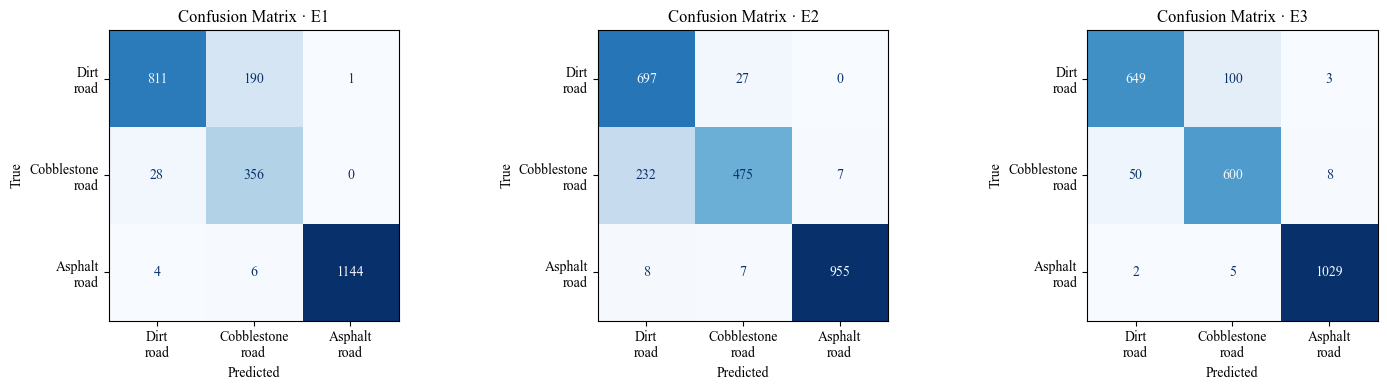

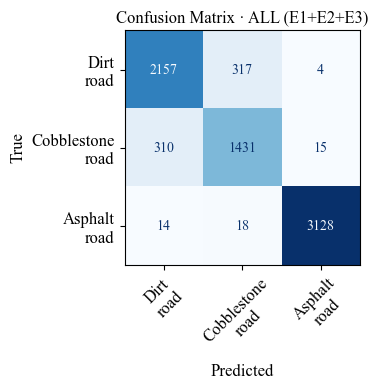

In [46]:
# Cell 11: Confusion matrices (per-exp và tổng)

LABEL_NAMES = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]
CLASS_IDS   = [0, 1, 2]

exps = ["E1", "E2", "E3"]
y_tests, y_preds = {}, {}

# Tái huấn luyện + dự đoán trên test cho từng exp để vẽ CM
for exp in exps:
    print(f"[CM] Refit & predict on {exp}")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = LGBMClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_tests[exp] = y_test
    y_preds[exp] = y_pred

# --- Hình 1: 1 hàng 3 cột (E1/E2/E3) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, exp in enumerate(exps):
    ax = axes[idx]
    cm = confusion_matrix(y_tests[exp], y_preds[exp], labels=CLASS_IDS)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix · {exp}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# --- Hình 2: Tổng (gộp E1+E2+E3) ---
y_all_true = np.concatenate([y_tests[e] for e in exps], axis=0)
y_all_pred = np.concatenate([y_preds[e] for e in exps], axis=0)
cm_all = confusion_matrix(y_all_true, y_all_pred, labels=CLASS_IDS)

fig2, ax2 = plt.subplots(1, 1, figsize=(4, 4))
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=LABEL_NAMES)
disp_all.plot(ax=ax2, values_format='d', cmap="Blues", colorbar=False)
ax2.set_title("Confusion Matrix · ALL (E1+E2+E3)")
ax2.set_xlabel("Predicted", fontsize=12)
ax2.set_ylabel("True", fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 12 — Classification report

In [47]:
# Cell 12: Classification reports (per-exp và tổng)

exps = ["E1", "E2", "E3"]

# for exp in exps:
#     print(f"\n===== Classification Report · {exp} =====")
#     print(classification_report(
#         y_tests[exp],
#         y_preds[exp],
#         labels=[0,1,2],
#         target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
#         digits=4
#     ))

print("\n===== Classification Report · ALL (E1+E2+E3) =====")
print(classification_report(
    y_all_true,
    y_all_pred,
    labels=[0,1,2],
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))



===== Classification Report · ALL (E1+E2+E3) =====
                  precision    recall  f1-score   support

       Dirt road     0.8694    0.8705    0.8699      2478
Cobblestone road     0.8103    0.8149    0.8126      1756
    Asphalt road     0.9940    0.9899    0.9919      3160

        accuracy                         0.9083      7394
       macro avg     0.8912    0.8918    0.8915      7394
    weighted avg     0.9086    0.9083    0.9085      7394



## Cell 13 — Huấn luyện trên toàn bộ PVS và xuất mã C

In [48]:
# Cell 13: Huấn luyện trên toàn bộ PVS và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_LGBM = LGBMClassifier(**BEST_PARAMS, random_state=42)
final_clf_LGBM.fit(X_all, y_all)

# Xuất mô hình sang header C/C++ bằng m2cgen
header_file = "m2cgen_PVS_LGBM.h"

try:
    c_cpp_code = export_to_c(final_clf_LGBM)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 7180, number of used features: 80
[LightGBM] [Info] Start training from score -1.280154
[LightGBM] [Info] Start training from score -1.231269
[LightGBM] [Info] Start training from score -0.843776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

✅ Exported to 'm2cgen_PVS_LGBM.h'
📦 Header size: 742.41 KB (0.725 MB)


# 2 vị trí kết hợp - dashboard + above

## Cell 1 — Imports, cấu hình & định nghĩa Experiments 1–3

In [49]:
# Cell 1: Imports, constants, experiments
import os, json, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from m2cgen.exporters import export_to_c

# Thiết lập font mặc định Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Gốc thư mục PVS
BASE_DIR = r"D:\BVHoan\Spiiras Proceedings\Passive Vehicular Sensors Datasets"
PVS_FOLDERS = [os.path.join(BASE_DIR, f"PVS {i}") for i in range(1, 10)]

# Cấu hình phân đoạn
WINDOW_SIZE = 600
STRIDE = 300

# =========================
# Chọn thủ công cấu hình sensor
# =========================
# Hỗ trợ: "dashboard","above","below",
#         "dashboard+above", "dashboard+below", "above+below",
#         "dashboard+above+below"
ACTIVE_PRESET = "dashboard+above"  # <-- chỉnh tại đây khi muốn thử cấu hình khác

# Định nghĩa các kênh IMU cho từng vị trí (mỗi vị trí có cả L/R; tên cột giống nhau giữa left/right CSV)
DASH_IMU = [
    "acc_x_dashboard", "acc_y_dashboard", "acc_z_dashboard",
    "gyro_x_dashboard", "gyro_y_dashboard", "gyro_z_dashboard",
]
ABOVE_IMU = [
    "acc_x_above_suspension", "acc_y_above_suspension", "acc_z_above_suspension",
    "gyro_x_above_suspension", "gyro_y_above_suspension", "gyro_z_above_suspension",
]
BELOW_IMU = [
    "acc_x_below_suspension", "acc_y_below_suspension", "acc_z_below_suspension",
    "gyro_x_below_suspension", "gyro_y_below_suspension", "gyro_z_below_suspension",
]

# Bảng preset (chỉ liệt kê kênh IMU; cột speed sẽ được thêm một lần ở cuối)
SENSOR_PRESETS = {
    "dashboard": DASH_IMU,
    "above": ABOVE_IMU,
    "below": BELOW_IMU,
    "dashboard+above": DASH_IMU + ABOVE_IMU,
    "dashboard+below": DASH_IMU + BELOW_IMU,
    "above+below": ABOVE_IMU + BELOW_IMU,
    "dashboard+above+below": DASH_IMU + ABOVE_IMU + BELOW_IMU,
}

def choose_active_preset(name: str, include_speed: bool = True):
    if name not in SENSOR_PRESETS:
        raise ValueError(f"Unknown preset '{name}'. Allowed: {list(SENSOR_PRESETS.keys())}")
    cols = list(SENSOR_PRESETS[name])  # copy
    if include_speed:
        cols = cols + ["speed"]  # chỉ một cột speed dùng chung cho toàn cấu hình
    return cols

# Danh sách cột đầu vào cho run hiện tại
SENSOR_COLUMNS = choose_active_preset(ACTIVE_PRESET, include_speed=True)

print(f"✅ Using preset: {ACTIVE_PRESET}")
print(f"   → #IMU channels (không tính speed): {len(SENSOR_COLUMNS) - 1}")
print(f"   → Tổng số kênh (đã gồm speed):      {len(SENSOR_COLUMNS)}")

# Nhãn tác vụ chính (mutually exclusive)
LABEL_COLUMNS = ["dirt_road", "cobblestone_road", "asphalt_road"]

# Cấu hình chia theo Menegazzo
EXPERIMENTS = {
    1: {"train": ["PVS 1", "PVS 3", "PVS 4", "PVS 6", "PVS 7", "PVS 9"],
        "test":  ["PVS 2", "PVS 5", "PVS 8"]},
    2: {"train": ["PVS 1", "PVS 2", "PVS 3", "PVS 7", "PVS 8", "PVS 9"],
        "test":  ["PVS 4", "PVS 5", "PVS 6"]},
    3: {"train": ["PVS 1", "PVS 2", "PVS 4", "PVS 6", "PVS 8", "PVS 9"],
        "test":  ["PVS 3", "PVS 5", "PVS 7"]},
}


✅ Using preset: dashboard+above
   → #IMU channels (không tính speed): 12
   → Tổng số kênh (đã gồm speed):      13


## Cell 2 — I/O & kiểm tra: đọc 3 file trong 1 PVS, cửa sổ, majority label

In [50]:
# Cell 2: IO, validation, windowing, majority label

def load_pvs_triplet(pvs_dir: str):
    """
    Đọc 3 file trong một thư mục PVS:
      - dataset_gps_mpu_left.csv
      - dataset_gps_mpu_right.csv
      - dataset_labels.csv
    Trả về (left_df, right_df, labels_df) và kiểm tra cấu trúc tối thiểu
    theo cấu hình cột hiện hành (SENSOR_COLUMNS từ Cell 1).
    """
    left_path  = os.path.join(pvs_dir, "dataset_gps_mpu_left.csv")
    right_path = os.path.join(pvs_dir, "dataset_gps_mpu_right.csv")
    label_path = os.path.join(pvs_dir, "dataset_labels.csv")

    if not (os.path.exists(left_path) and os.path.exists(right_path) and os.path.exists(label_path)):
        raise FileNotFoundError(f"Missing one of required files in: {pvs_dir}")

    left_df  = pd.read_csv(left_path)
    right_df = pd.read_csv(right_path)
    labels_df= pd.read_csv(label_path)

    # Hàng phải khớp 1–1 giữa 3 file (đồng bộ theo chỉ số dòng)
    if not (len(left_df) == len(right_df) == len(labels_df)):
        raise ValueError(
            f"Row mismatch in {pvs_dir}: left={len(left_df)}, right={len(right_df)}, labels={len(labels_df)}"
        )

    # --- Kiểm tra cột theo preset hiện hành ---
    # Tất cả kênh trừ 'speed' phải có ở cả left và right.
    imu_cols = [c for c in SENSOR_COLUMNS if c != "speed"]
    missing_imu = [c for c in imu_cols if (c not in left_df.columns or c not in right_df.columns)]
    if missing_imu:
        raise KeyError(f"Missing IMU columns {missing_imu} in {pvs_dir} (left/right)")

    # 'speed' phải có ít nhất ở một trong hai file (giá trị hai phía giống nhau là mong đợi)
    if "speed" in SENSOR_COLUMNS:
        has_speed_left  = "speed" in left_df.columns
        has_speed_right = "speed" in right_df.columns
        if not (has_speed_left or has_speed_right):
            raise KeyError(f"Missing column 'speed' in {pvs_dir} (neither left nor right)")

        # Nếu có ở cả hai, kiểm tra gần như nhau (sanity check, không dừng nếu lệch rất nhỏ do làm tròn)
        if has_speed_left and has_speed_right:
            try:
                if not np.allclose(left_df["speed"].values, right_df["speed"].values, atol=1e-6, rtol=1e-6):
                    print(f"[Warn] 'speed' differs between left/right in {pvs_dir}. "
                          f"Values should be identical (GPS shared). Proceeding with files as-is.")
            except Exception:
                # Trường hợp dtype lạ hoặc NaN; chỉ cảnh báo nhẹ
                print(f"[Warn] Could not compare 'speed' columns in {pvs_dir} due to dtype/NaN issues.")

    # Cột nhãn one-hot bắt buộc
    for col in LABEL_COLUMNS:
        if col not in labels_df.columns:
            raise KeyError(f"Label column '{col}' missing in {pvs_dir}/dataset_labels.csv")

    return left_df, right_df, labels_df

def window_indices(n_samples: int, window: int, stride: int):
    """Sinh danh sách (start, end) cho các cửa sổ trượt."""
    idx = []
    start = 0
    while start + window <= n_samples:
        idx.append((start, start + window))
        start += stride
    return idx

def majority_label_onehot(block_labels, label_cols=LABEL_COLUMNS):
    """
    Lấy nhãn majority trong cửa sổ theo tổng one-hot; khi hòa,
    dùng mode() giống Menegazzo.
    """
    sums = block_labels[label_cols].sum(axis=0)
    max_sum = sums.max()
    tied = [cls for cls, val in sums.items() if val == max_sum]
    if len(tied) == 1:
        return tied[0]
    # dùng mode() giống Menegazzo
    mode_label = block_labels[label_cols].mode().iloc[0]
    for cls in label_cols:
        if mode_label[cls] == 1:
            return cls
    return tied[0]


## Cell 3 — Phân đoạn một lần duy nhất và gắn provenance PVS

In [51]:
# Cell 3: Single-pass segmentation with provenance (both sides as independent samples)

def build_windows_by_pvs(pvs_folders):
    """
    Trả về:
      windows_by_pvs = {
        'PVS 1': {'dirt_road': [np.array(WINDOW_SIZE, n_channels), ...],
                  'cobblestone_road': [...],
                  'asphalt_road': [...]},
        ...
      }
    Mỗi cửa sổ là một mẫu; left/right được coi là 2 mẫu độc lập (đúng Menegazzo).
    """
    windows_by_pvs = {}
    global_summary = Counter()

    for pvs_dir in pvs_folders:
        pvs_name = os.path.basename(pvs_dir)  # "PVS i"
        try:
            left_df, right_df, labels_df = load_pvs_triplet(pvs_dir)
        except Exception as e:
            print(f"[WARN] Skip {pvs_name}: {e}")
            continue

        # -----------------------------
        # 1) Chuẩn bị tín hiệu đầu vào
        # -----------------------------
        # Sao chép SENSOR_COLUMNS để tách speed riêng
        cols_no_speed = [c for c in SENSOR_COLUMNS if c != "speed"]
        include_speed = "speed" in SENSOR_COLUMNS

        # Các cột IMU phải có ở cả left & right
        left_sig_imu  = left_df[cols_no_speed].to_numpy(dtype=np.float32)
        right_sig_imu = right_df[cols_no_speed].to_numpy(dtype=np.float32)

        # Speed: chỉ lấy một nguồn (left ưu tiên)
        if include_speed:
            if "speed" in left_df.columns:
                speed_vec = left_df["speed"].to_numpy(dtype=np.float32)
            else:
                speed_vec = right_df["speed"].to_numpy(dtype=np.float32)
            speed_vec = speed_vec.reshape(-1, 1)
            # Ghép speed thành cột cuối
            left_sig  = np.hstack([left_sig_imu,  speed_vec])
            right_sig = np.hstack([right_sig_imu, speed_vec])
        else:
            left_sig, right_sig = left_sig_imu, right_sig_imu

        # -----------------------------
        # 2) Xử lý nhãn
        # -----------------------------
        labels_main = labels_df[LABEL_COLUMNS].astype(int)
        n = len(labels_main)
        win_idxs = window_indices(n, WINDOW_SIZE, STRIDE)
        if not win_idxs:
            print(f"[INFO] {pvs_name}: not enough samples for one window ({n} < {WINDOW_SIZE})")
            continue

        # -----------------------------
        # 3) Tạo kho lưu kết quả
        # -----------------------------
        windows_by_pvs.setdefault(pvs_name, {k: [] for k in LABEL_COLUMNS})

        # -----------------------------
        # 4) Cắt cửa sổ và gán nhãn
        # -----------------------------
        for (s, e) in win_idxs:
            cls = majority_label_onehot(labels_main.iloc[s:e], LABEL_COLUMNS)

            # Mỗi bên là một mẫu độc lập
            wL = left_sig[s:e, :]
            wR = right_sig[s:e, :]

            windows_by_pvs[pvs_name][cls].append(wL)
            windows_by_pvs[pvs_name][cls].append(wR)
            global_summary[cls] += 2

    # -----------------------------
    # 5) Log thống kê
    # -----------------------------
    print(f"=== Windows per PVS (preset: {ACTIVE_PRESET}) ===")
    for pvs_name in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
        line = [f"{cls}:{len(windows_by_pvs[pvs_name][cls])}" for cls in LABEL_COLUMNS]
        print(f"{pvs_name} -> " + " | ".join(line))

    print("\n=== Global class totals ===")
    for cls in LABEL_COLUMNS:
        print(f"{cls:17s}: {global_summary[cls]}")

    return windows_by_pvs

# Thực thi để sinh dữ liệu phân đoạn
windows_by_pvs = build_windows_by_pvs(PVS_FOLDERS)


=== Windows per PVS (preset: dashboard+above) ===
PVS 1 -> dirt_road:172 | cobblestone_road:412 | asphalt_road:374
PVS 2 -> dirt_road:298 | cobblestone_road:138 | asphalt_road:392
PVS 3 -> dirt_road:190 | cobblestone_road:176 | asphalt_road:336
PVS 4 -> dirt_road:160 | cobblestone_road:384 | asphalt_road:336
PVS 5 -> dirt_road:404 | cobblestone_road:120 | asphalt_road:366
PVS 6 -> dirt_road:160 | cobblestone_road:210 | asphalt_road:268
PVS 7 -> dirt_road:158 | cobblestone_road:362 | asphalt_road:334
PVS 8 -> dirt_road:300 | cobblestone_road:126 | asphalt_road:396
PVS 9 -> dirt_road:154 | cobblestone_road:168 | asphalt_road:286

=== Global class totals ===
dirt_road        : 1996
cobblestone_road : 2096
asphalt_road     : 3088


## Cell 4 — Tạo đủ 3 splits theo Menegazzo và in thống kê

In [52]:
# Cell 4: Build ALL 3 Menegazzo splits + stats

def _collect_from_pvs(pvs_list, windows_by_pvs, label_cols=LABEL_COLUMNS):
    bucket = {c: [] for c in label_cols}
    for pvs in pvs_list:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing; skipping.")
            continue
        for cls in label_cols:
            bucket[cls].extend(windows_by_pvs[pvs][cls])
    return bucket

def _print_split_stats(exp_id, split_name, lists_by_class, label_cols=LABEL_COLUMNS):
    total = sum(len(v) for v in lists_by_class.values())
    print(f"[Experiment {exp_id} · {split_name.upper()}] Total windows: {total}")
    for cls in label_cols:
        print(f"  {cls:17s}: {len(lists_by_class[cls])}")

def make_all_splits(windows_by_pvs, experiments=EXPERIMENTS):
    """
    Trả về:
      splits = {
        1: {"train": {"dirt_road":[...], ...}, "test": {...}},
        2: {...},
        3: {...}
      }
    """
    splits = {}
    for exp_id, conf in experiments.items():
        tr_pvs, te_pvs = conf["train"], conf["test"]
        train_lists = _collect_from_pvs(tr_pvs, windows_by_pvs)
        test_lists  = _collect_from_pvs(te_pvs, windows_by_pvs)

        splits[exp_id] = {"train": train_lists, "test": test_lists}

        print(f"=== Experiment {exp_id} ===")
        _print_split_stats(exp_id, "train", train_lists)
        _print_split_stats(exp_id, "test",  test_lists)

    return splits

splits = make_all_splits(windows_by_pvs)


=== Experiment 1 ===
[Experiment 1 · TRAIN] Total windows: 4640
  dirt_road        : 994
  cobblestone_road : 1712
  asphalt_road     : 1934
[Experiment 1 · TEST] Total windows: 2540
  dirt_road        : 1002
  cobblestone_road : 384
  asphalt_road     : 1154
=== Experiment 2 ===
[Experiment 2 · TRAIN] Total windows: 4772
  dirt_road        : 1272
  cobblestone_road : 1382
  asphalt_road     : 2118
[Experiment 2 · TEST] Total windows: 2408
  dirt_road        : 724
  cobblestone_road : 714
  asphalt_road     : 970
=== Experiment 3 ===
[Experiment 3 · TRAIN] Total windows: 4734
  dirt_road        : 1244
  cobblestone_road : 1438
  asphalt_road     : 2052
[Experiment 3 · TEST] Total windows: 2446
  dirt_road        : 752
  cobblestone_road : 658
  asphalt_road     : 1036


## Cell 5 — Sinh biến cho cả 3 experiment (không ghi đè nhau)

In [53]:
# Cell 5: Variables for all 3 experiments with suffixes _E1/_E2/_E3

def _vars_for_all_experiments(splits_dict):
    for exp_id in (1, 2, 3):
        sd = splits_dict[exp_id]

        globals()[f"train_dirt_road_E{exp_id}"]         = sd["train"]["dirt_road"]
        globals()[f"train_cobblestone_road_E{exp_id}"]  = sd["train"]["cobblestone_road"]
        globals()[f"train_asphalt_road_E{exp_id}"]      = sd["train"]["asphalt_road"]

        globals()[f"test_dirt_road_E{exp_id}"]          = sd["test"]["dirt_road"]
        globals()[f"test_cobblestone_road_E{exp_id}"]   = sd["test"]["cobblestone_road"]
        globals()[f"test_asphalt_road_E{exp_id}"]       = sd["test"]["asphalt_road"]

_vars_for_all_experiments(splits)

# peek a few counts so you can sanity-check at a glance
for k in ("train_dirt_road", "train_cobblestone_road", "train_asphalt_road",
          "test_dirt_road", "test_cobblestone_road", "test_asphalt_road"):
    for e in (1, 2, 3):
        v = globals()[f"{k}_E{e}"]
        print(f"{k}_E{e:1d}: {len(v)} windows")


train_dirt_road_E1: 994 windows
train_dirt_road_E2: 1272 windows
train_dirt_road_E3: 1244 windows
train_cobblestone_road_E1: 1712 windows
train_cobblestone_road_E2: 1382 windows
train_cobblestone_road_E3: 1438 windows
train_asphalt_road_E1: 1934 windows
train_asphalt_road_E2: 2118 windows
train_asphalt_road_E3: 2052 windows
test_dirt_road_E1: 1002 windows
test_dirt_road_E2: 724 windows
test_dirt_road_E3: 752 windows
test_cobblestone_road_E1: 384 windows
test_cobblestone_road_E2: 714 windows
test_cobblestone_road_E3: 658 windows
test_asphalt_road_E1: 1154 windows
test_asphalt_road_E2: 970 windows
test_asphalt_road_E3: 1036 windows


## Cell 6 — Tạo data_train/data_test + label_train/label_test cho từng experiment

In [54]:
# Cell 6: Build data_/label_ arrays for EACH experiment,
# groups cho mỗi cửa sổ (train/test) theo PVS (để dùng Group-aware CV)

def _vars_with_groups_for_experiment(exp_id):
    """
    Sinh data_/label_ + groups_ cho exp_id.
    Group = tên PVS của cửa sổ đó.
    Dùng danh sách cột linh hoạt SENSOR_COLUMNS (theo preset đã chọn).
    """
    data_train, label_train, groups_train = [], [], []

    # --- Build TRAIN ---
    for pvs in EXPERIMENTS[exp_id]["train"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TRAIN")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                # mỗi acts là np.array(window_size, n_channels)
                data_train.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_train.append(lab)
                groups_train.append(pvs)

    # --- Build TEST ---
    data_test, label_test, groups_test = [], [], []
    for pvs in EXPERIMENTS[exp_id]["test"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TEST")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                data_test.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_test.append(lab)
                groups_test.append(pvs)

    # --- Lưu vào biến toàn cục ---
    globals()[f"data_train_E{exp_id}"]   = data_train
    globals()[f"label_train_E{exp_id}"]  = label_train
    globals()[f"groups_train_E{exp_id}"] = groups_train

    globals()[f"data_test_E{exp_id}"]    = data_test
    globals()[f"label_test_E{exp_id}"]   = label_test
    globals()[f"groups_test_E{exp_id}"]  = groups_test

# Rebuild để có groups (E1–E3)
_vars_with_groups_for_experiment(1)
_vars_with_groups_for_experiment(2)
_vars_with_groups_for_experiment(3)

print("E1:", len(data_train_E1), "train /", len(data_test_E1), "test | #groups(train) =", len(set(groups_train_E1)))
print("E2:", len(data_train_E2), "train /", len(data_test_E2), "test | #groups(train) =", len(set(groups_train_E2)))
print("E3:", len(data_train_E3), "train /", len(data_test_E3), "test | #groups(train) =", len(set(groups_train_E3)))


E1: 4640 train / 2540 test | #groups(train) = 6
E2: 4772 train / 2408 test | #groups(train) = 6
E3: 4734 train / 2446 test | #groups(train) = 6


## Cell 7 — Feature extraction

In [55]:
# # Cell 7: Trích xuất đặc trưng

# def featuresFromBuffer(at):
#     feat = np.zeros(158, dtype=np.float32)
    
#     # ---- DASHBOARD ----
#     ax_dashboard = np.array(at['acc_x_dashboard'],  dtype=np.float32)
#     ay_dashboard = np.array(at['acc_y_dashboard'],  dtype=np.float32)
#     az_dashboard = np.array(at['acc_z_dashboard'],  dtype=np.float32)
#     gx_dashboard = np.array(at['gyro_x_dashboard'], dtype=np.float32)
#     gy_dashboard = np.array(at['gyro_y_dashboard'], dtype=np.float32)
#     gz_dashboard = np.array(at['gyro_z_dashboard'], dtype=np.float32)
    
#     # ---- ABOVE ----
#     ax_above = np.array(at['acc_x_above_suspension'],  dtype=np.float32)
#     ay_above = np.array(at['acc_y_above_suspension'],  dtype=np.float32)
#     az_above = np.array(at['acc_z_above_suspension'],  dtype=np.float32)
#     gx_above = np.array(at['gyro_x_above_suspension'], dtype=np.float32)
#     gy_above = np.array(at['gyro_y_above_suspension'], dtype=np.float32)
#     gz_above = np.array(at['gyro_z_above_suspension'], dtype=np.float32)
    
#     # ---- SPEED (chung) ----
#     sp = np.array(at['speed'], dtype=np.float32)
    
#     # Đặc trưng thống kê
#     feat[0:13] = [np.mean(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above,
#                                        sp]] # mean
#     feat[13:26] = [np.std(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above,
#                                        sp]] # sd
#     feat[26:38] = [np.sqrt(np.mean(i**2)) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                                     gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # rms
#     feat[38:50] = [np.max(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # max
#     feat[50:62] = [np.min(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # min
#     feat[62:74] = [np.amax(i) - np.amin(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                                      gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # range
#     feat[74:86] = [np.median(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                           gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # median
#     feat[86:98] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                                                          gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # interquartile range
#     feat[98:110] = [skew(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                       gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # skewness
#     feat[110:122] = [kurtosis(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                            gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # kurtosis
#     feat[122:134] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # hjorth mobility
#     feat[134:146] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                                                                                                                      gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # hjorth complexity
#     feat[146:158] = [acf(i, nlags=1)[1] for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                                   gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # autocorrelation
        
#     return feat

# # Trích xuất đặc trưng cho từng cửa sổ
# train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
# test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
# train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
# test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
# train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
# test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

# # Ép sang numpy array
# train_features_E1 = np.array(train_features_E1, dtype=np.float32)
# test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
# train_features_E2 = np.array(train_features_E2, dtype=np.float32)
# test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
# train_features_E3 = np.array(train_features_E3, dtype=np.float32)
# test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

# print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
# print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
# print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
# print('Feature dimension:', train_features_E1.shape[1])

# # Gom toàn bộ dữ liệu từ PVS 1..9 (tránh dùng E1/E2/E3 để không đếm trùng)
# cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
# X_all, y_all = [], []

# # Đảm bảo thứ tự PVS 1..9 ổn định
# for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#     for cls_name, cls_id in cls_map:
#         for buf in windows_by_pvs[pvs][cls_name]:
#             # buf là ndarray (WINDOW_SIZE x len(SENSOR_COLUMNS))
#             at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#             feat = featuresFromBuffer(at)
#             X_all.append(feat)
#             y_all.append(cls_id)

# X_all = np.asarray(X_all, dtype=np.float32)
# y_all = np.asarray(y_all, dtype=np.int32)
# print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))


## Cell 7A — Tính & Lưu cache

In [56]:
# # Cell 7A: Compute & cache features for the current ACTIVE_PRESET

# def _extract_features_for_splits():
#     # y nguyên format Cell 7: tạo các mảng đặc trưng cho E1/E2/E3
#     train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
#     test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
#     train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
#     test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
#     train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
#     test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

#     # Ép sang numpy array
#     train_features_E1 = np.array(train_features_E1, dtype=np.float32)
#     test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
#     train_features_E2 = np.array(train_features_E2, dtype=np.float32)
#     test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
#     train_features_E3 = np.array(train_features_E3, dtype=np.float32)
#     test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

#     return (train_features_E1, test_features_E1,
#             train_features_E2, test_features_E2,
#             train_features_E3, test_features_E3)

# def _extract_features_all_pvs():
#     # Y nguyên logic gom ALL PVS (tránh đếm trùng E1/E2/E3)
#     cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
#     X_all, y_all = [], []

#     for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#         for cls_name, cls_id in cls_map:
#             for buf in windows_by_pvs[pvs][cls_name]:
#                 at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#                 feat = featuresFromBuffer(at)
#                 X_all.append(feat)
#                 y_all.append(cls_id)

#     X_all = np.asarray(X_all, dtype=np.float32)
#     y_all = np.asarray(y_all, dtype=np.int32)
#     return X_all, y_all

# def _save_feature_cache(fname,
#                         train_features_E1, test_features_E1,
#                         train_features_E2, test_features_E2,
#                         train_features_E3, test_features_E3,
#                         X_all, y_all):
#     # Lưu gọn bằng NPZ nén
#     np.savez_compressed(
#         fname,
#         ACTIVE_PRESET=np.array([ACTIVE_PRESET]),
#         SENSOR_COLUMNS=np.array(SENSOR_COLUMNS),
#         WINDOW_SIZE=np.array([WINDOW_SIZE], dtype=np.int32),
#         STRIDE=np.array([STRIDE], dtype=np.int32),
#         LABEL_COLUMNS=np.array(LABEL_COLUMNS),

#         train_features_E1=train_features_E1,
#         test_features_E1=test_features_E1,
#         train_features_E2=train_features_E2,
#         test_features_E2=test_features_E2,
#         train_features_E3=train_features_E3,
#         test_features_E3=test_features_E3,

#         X_all=X_all,
#         y_all=y_all
#     )

# # ---- Thực thi: tính & lưu ----
# cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
# print(f"⏳ Computing features for preset: {ACTIVE_PRESET} ...")

# (train_features_E1, test_features_E1,
#  train_features_E2, test_features_E2,
#  train_features_E3, test_features_E3) = _extract_features_for_splits()

# print("   • Splits done:",
#       f"E1: {train_features_E1.shape} / {test_features_E1.shape} |",
#       f"E2: {train_features_E2.shape} / {test_features_E2.shape} |",
#       f"E3: {train_features_E3.shape} / {test_features_E3.shape}")

# X_all, y_all = _extract_features_all_pvs()
# print("   • ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))

# _save_feature_cache(cache_name,
#                     train_features_E1, test_features_E1,
#                     train_features_E2, test_features_E2,
#                     train_features_E3, test_features_E3,
#                     X_all, y_all)

# size_bytes = os.path.getsize(cache_name)
# print(f"✅ Saved cache to '{cache_name}' ({size_bytes/1024/1024:.3f} MB)")


## Cell 7B — Nạp cache (dùng cho chạy nhanh về sau)

In [57]:
# Cell 7B: Load cached feature set for the current ACTIVE_PRESET

cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
if not os.path.exists(cache_name):
    raise FileNotFoundError(f"Feature cache not found: {cache_name}. Hãy chạy Cell 7A trước để tạo cache.")

data = np.load(cache_name, allow_pickle=True)

# Khôi phục biến đúng tên như Cell 7 gốc
train_features_E1 = data["train_features_E1"]
test_features_E1  = data["test_features_E1"]
train_features_E2 = data["train_features_E2"]
test_features_E2  = data["test_features_E2"]
train_features_E3 = data["train_features_E3"]
test_features_E3  = data["test_features_E3"]

X_all = data["X_all"]
y_all = data["y_all"]

# (tuỳ chọn) kiểm tra meta để cảnh báo nếu lệch preset
_cached_preset = str(data["ACTIVE_PRESET"][0])
if _cached_preset != ACTIVE_PRESET:
    print(f"[WARN] Cache preset = '{_cached_preset}' khác với ACTIVE_PRESET hiện tại = '{ACTIVE_PRESET}'")

# In thống kê giống Cell 7 gốc
print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
print('Feature dimension:', train_features_E1.shape[1])
print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))
print(f"✅ Loaded cache from '{cache_name}'")


E1: 4640 train samples / 2540 test samples
E2: 4772 train samples / 2408 test samples
E3: 4734 train samples / 2446 test samples
Feature dimension: 158
ALL PVS: (7180, 158) | class dist: [1996 2096 3088]
✅ Loaded cache from 'feature_set_dashboard+above.npz'


## Cell 8 — Find candidates

In [58]:
# Cell 8: Find candidates, LOGO trên 3 experiment → lấy 3 bộ tham số ứng viên (Accuracy), kèm kiểm tra model size ≤ 1.00 MB
print(f"✅ Using preset: {ACTIVE_PRESET}")

# Định nghĩa grid riêng cho từng exp
param_grids = {
    "E1": {
        "n_estimators": list(range(50, 51)),
        "max_depth": list(range(9, 10))
    },
    "E2": {
        "n_estimators": list(range(49, 50)),
        "max_depth": list(range(8, 9))
    },
    "E3": {
        "n_estimators": list(range(49, 50)),
        "max_depth": list(range(9, 10))
    }
}

# ---------------------- HÀM ĐO SIZE ----------------------
def measure_model_size_mb(params, X_full, y_full):
    """
    Train LGBMClassifier trên toàn bộ dữ liệu với 'params',
    export C/C++ header bằng m2cgen.exporters.export_to_c() rồi đo kích thước (MB).
    Trả về (size_mb, error_msg, c_code).
    """
    clf = LGBMClassifier(**params, random_state=42)
    clf.fit(X_full, y_full)

    tmp_header = None
    c_code = None
    err = ""
    size_mb = None
    try:
        c_code = export_to_c(clf)
        with tempfile.NamedTemporaryFile(mode="w", suffix=".h", delete=False, encoding="utf-8") as f:
            tmp_header = f.name
            f.write(c_code)

        size_bytes = os.path.getsize(tmp_header)
        size_mb = size_bytes / (1024 * 1024)
    except Exception as e:
        err = str(e)
    finally:
        if tmp_header and os.path.exists(tmp_header):
            os.remove(tmp_header)

    return size_mb, err, c_code

# ---------------------- HÀM LOGO + GRIDSEARCH CHO 1 EXP ----------------------
def run_logo_for_experiment(exp_name, X_train, y_train, groups, X_full_for_size, y_full_for_size,
                            param_grid, size_limit_mb=1.00):
    """
    - Chạy GridSearchCV với LOGO (Accuracy) trên (X_train, y_train, groups).
    - Với từng bộ params trong kết quả, train lại trên toàn bộ PVS 1–9 để đo size.
    - Chọn bộ params có:
        * size ≤ size_limit_mb
        * điểm cv (mean test Accuracy) cao nhất
      Tie-break: model nhỏ hơn → depth thấp hơn → số cây ít hơn.
    - Trả về dict ứng viên cho exp này.
    """
    print(f"\n===== EXP {exp_name}: START LOGO GRID (Accuracy) + SIZE CHECK ≤ {size_limit_mb:.2f} MB =====")
    logo = LeaveOneGroupOut()
    gs = GridSearchCV(
        estimator=LGBMClassifier(random_state=42),
        param_grid=param_grid,
        cv=logo.split(X_train, y_train, groups=groups),
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    best_cv = -np.inf
    best = None

    for i, params in enumerate(gs.cv_results_["params"], 1):
        cv_mean = gs.cv_results_["mean_test_score"][i-1]
        print(f"[{exp_name}] Check {i}/{len(gs.cv_results_['params'])}: {params} | CV Accuracy={cv_mean*100:.2f}")

        size_mb, err, _ = measure_model_size_mb(params, X_full_for_size, y_full_for_size)
        status = "ok"
        if err:
            status = f"error: {err}"
        elif size_mb is None:
            status = "error: size_none"
        elif size_mb > size_limit_mb:
            status = "oversize"

        print(f"   -> size={None if size_mb is None else f'{size_mb:.3f} MB'} | status={status}")

        if status == "ok":
            # update theo tiêu chí: cv cao nhất → size nhỏ hơn → depth thấp hơn → n_estimators ít hơn
            if (cv_mean > best_cv or
                (np.isclose(cv_mean, best_cv) and size_mb < best["size_mb"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] < best["params"]["max_depth"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] == best["params"]["max_depth"] and params["n_estimators"] < best["params"]["n_estimators"])
               ):
                best_cv = cv_mean
                best = {
                    "exp": exp_name,
                    "params": dict(params),
                    "cv_accuracy": float(cv_mean),
                    "size_mb": float(size_mb)
                }

    if best is None:
        best = {
            "exp": exp_name,
            "params": None,
            "cv_accuracy": None,
            "size_mb": None,
            "note": f"No feasible params ≤ {size_limit_mb:.2f} MB (or export error)"
        }
        print(f"[{exp_name}] WARNING: Không tìm thấy cấu hình khả thi (≤ {size_limit_mb:.2f} MB).")

    print(f"[{exp_name}] BEST CANDIDATE:", best)
    return best

candidates = []
candidates.append(run_logo_for_experiment("E1", train_features_E1, label_train_E1, groups_train_E1, X_all, y_all, param_grids["E1"]))
candidates.append(run_logo_for_experiment("E2", train_features_E2, label_train_E2, groups_train_E2, X_all, y_all, param_grids["E2"]))
candidates.append(run_logo_for_experiment("E3", train_features_E3, label_train_E3, groups_train_E3, X_all, y_all, param_grids["E3"]))

print("\n===== 3 ỨNG VIÊN LOGO (Accuracy, size≤1.00MB) =====")
for c in candidates:
    print(c)

# Lưu lại để dùng cho bước “chốt cuối”
with open("logo_candidates_LGBM.json", "w", encoding="utf-8") as f:
    json.dump(candidates, f, indent=2, ensure_ascii=False)

print("Đã lưu 3 ứng viên vào 'logo_candidates_LGBM.json'.")


✅ Using preset: dashboard+above

===== EXP E1: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 158
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[E1] Check 1/1: {'max_depth': 9, 'n_estimators': 50} | CV Accuracy=88.27
[LightGBM] [Info] Auto-ch

In [59]:
# mean, sd, rms, max, min, range, median, iqr, skew, kurt, hm, hc, acf
# {'exp': 'E1', 'params': {'max_depth': 9, 'n_estimators': 50}, 'cv_accuracy': 0.8826, 'size_mb': 0.784} -> 89.80 Maximin, Borda rank, Minimax regret, Mean - λ·Std
# {'exp': 'E2', 'params': {'max_depth': 8, 'n_estimators': 49}, 'cv_accuracy': 0.9022, 'size_mb': 0.751} -> 89.94
# {'exp': 'E3', 'params': {'max_depth': 9, 'n_estimators': 49}, 'cv_accuracy': 0.8889, 'size_mb': 0.769} -> 89.88

## Cell 9 — Select candidates

In [60]:
# Cell 9: Select candidates, thử 4 tiêu chí trên bộ ba ứng viên (train-only, LOGO)

# ========= NẠP 3 ỨNG VIÊN =========
with open("logo_candidates_LGBM.json", "r", encoding="utf-8") as f:
    candidates = json.load(f)

# Đặt tên ngắn gọn cho ứng viên theo exp gốc của nó: 'cand_E1', 'cand_E2', 'cand_E3'
for c in candidates:
    c["name"] = f"cand_{c['exp']}"

# ========= CHUẨN BỊ DỮ LIỆU TRAIN+GROUPS CHO 3 EXP =========
X_train_dict = {
    "E1": train_features_E1,
    "E2": train_features_E2,
    "E3": train_features_E3,
}
y_train_dict = {
    "E1": np.asarray(label_train_E1),
    "E2": np.asarray(label_train_E2),
    "E3": np.asarray(label_train_E3),
}
groups_dict = {
    "E1": np.asarray(groups_train_E1),
    "E2": np.asarray(groups_train_E2),
    "E3": np.asarray(groups_train_E3),
}

# ========= HÀM LOGO SCORE (Accuracy, train-only) =========
def logo_cv_accuracy_for_exp(params, X, y, groups):
    """
    Cố định bộ tham số 'params' => chạy LOGO trên (X,y,groups) => trả về mean Accuracy.
    """
    logo = LeaveOneGroupOut()
    f1s = []
    # Duyệt từng split LOGO
    for tr_idx, va_idx in logo.split(X, y, groups=groups):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        clf = LGBMClassifier(**params, random_state=42)
        clf.fit(X_tr, y_tr)
        y_hat = clf.predict(X_va)
        f1s.append(accuracy_score(y_va, y_hat))
    return float(np.mean(f1s))

# ========= TÍNH MA TRẬN ĐIỂM S_k(h) (k ∈ {E1,E2,E3}, h ∈ 3 ứng viên) =========
exps = ["E1", "E2", "E3"]
H = len(candidates)
K = len(exps)

scores = np.zeros((H, K), dtype=float)  # S[h,k] = Accuracy của ứng viên h trên exp k
for h, cand in enumerate(candidates):
    params = cand["params"]
    print(f"\n>>> Scoring {cand['name']} with params={params}")
    for k, ek in enumerate(exps):
        S_hk = logo_cv_accuracy_for_exp(params, X_train_dict[ek], y_train_dict[ek], groups_dict[ek])
        scores[h, k] = S_hk
        print(f"   {ek}: Accuracy(LOGO) = {S_hk*100:.2f}")

# ========= TIỆN ÍCH: TIE-BREAK =========
def tie_break_key(h):
    # size nhỏ hơn → depth nhỏ hơn → n_estimators ít hơn
    size = candidates[h].get("size_mb", np.inf)
    depth = candidates[h]["params"]["max_depth"]
    trees = candidates[h]["params"]["n_estimators"]
    return (size, depth, trees)

# ========= 1) MAXIMIN =========
worst_case = scores.min(axis=1)             # min_k S_k(h)
best_h_maximin = max(range(H), key=lambda h: (worst_case[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= 2) BORDA RANK =========
def ranks_desc(vals):
    """
    Trả về rank (1 = tốt nhất) theo thứ tự giảm dần của vals.
    Ties => average-rank.
    """
    vals = np.asarray(vals)
    # sắp xếp giảm dần
    order = np.argsort(-vals)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(vals) + 1, dtype=float)
    # xử lý ties (average rank)
    for v in np.unique(vals):
        idx = np.where(vals == v)[0]
        if len(idx) > 1:
            avg = ranks[idx].mean()
            ranks[idx] = avg
    return ranks

borda = np.zeros(H, dtype=float)
for k in range(K):
    borda += ranks_desc(scores[:, k])
best_h_borda = min(range(H), key=lambda h: (borda[h], tie_break_key(h)))

# ========= 3) MINIMAX REGRET =========
best_per_exp = scores.max(axis=0)           # S*_k
regret = best_per_exp - scores              # Reg_k(h) = S*_k - S_k(h)
max_regret = regret.max(axis=1)             # max_k Reg_k(h)
best_h_regret = min(range(H), key=lambda h: (max_regret[h], tie_break_key(h)))

# ========= 4) MEAN − λ·STD (λ suy từ dữ liệu) =========
means = scores.mean(axis=1)
stds  = scores.std(axis=1, ddof=0)

sigma_typ = float(np.median(stds))
c_pp = 0.01  # 1.0 điểm phần trăm F1  => 0.01 theo thang [0,1]
# Nếu bạn thích 0.5–1.5 pp, đổi c_pp = 0.005 ~ 0.015
if sigma_typ > 0:
    lam = c_pp / sigma_typ
else:
    lam = 0.1
lam = float(np.clip(lam, 0.1, 1.0))

risk_adj = means - lam * stds
best_h_mean_std = max(range(H), key=lambda h: (risk_adj[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= IN KẾT QUẢ =========
def pretty_candidate(h):
    c = candidates[h]
    return {
        "name": c["name"],
        "params": c["params"],
        "size_mb": round(float(c.get("size_mb", np.nan)), 3),
        "S_E1": round(scores[h,0]*100, 2),
        "S_E2": round(scores[h,1]*100, 2),
        "S_E3": round(scores[h,2]*100, 2),
        "mean": round(means[h]*100, 2),
        "std": round(stds[h], 2)
    }

print("\n===== SCORE MATRIX (Accuracy, train-only LOGO) =====")
for h in range(H):
    print(pretty_candidate(h))

print("\n===== SELECTIONS (4 tiêu chí) =====")
print(f"Maximin         -> {pretty_candidate(best_h_maximin)}")
print(f"Borda rank      -> {pretty_candidate(best_h_borda)}")
print(f"Minimax regret  -> {pretty_candidate(best_h_regret)}")
print(f"Mean - λ·Std    -> {pretty_candidate(best_h_mean_std)}  (λ = {lam:.4f}, c_pp={c_pp})")



>>> Scoring cand_E1 with params={'max_depth': 9, 'n_estimators': 50}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 158
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3938, number of used features: 158
[LightGBM] [Info] Start training from score -1.588829
[LightGBM] [Info] Start training from score -0.941491
[LightGBM] [Info] Start training from score -0.901920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 158
[LightGBM] [Info] Start training from score -1.505941
[LightGBM] [Info] Start training from score -1.040745
[LightGBM] [Info] Start training from score -0.855666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3786, number of used features: 158
[LightGBM] [Info] Start training from score -1.510437
[LightGBM] [Info] Start training from score -1.031205
[LightGBM] [Info] Start training from score -0.861306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E1: Accuracy(LOGO) = 88.27
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3814, number of used features: 158
[LightGBM] [Info] Start training from score -1.243368
[LightGBM] [Info] Start training from score -1.369138
[LightGBM] [Info] Start training from score -0.782497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 158
[LightGBM] [Info] Start training from score -1.257624
[LightGBM] [Info] Start training from score -1.345779
[LightGBM] [Info] Start training from score -0.786723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 158
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4164, number of used features: 158
[LightGBM] [Info] Start training from score -1.314935
[LightGBM] [Info] Start training from score -1.232555
[LightGBM] [Info] Start training from score -0.821068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E2: Accuracy(LOGO) = 90.16
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 158
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3906, number of used features: 158
[LightGBM] [Info] Start training from score -1.418027
[LightGBM] [Info] Start training from score -1.100150
[LightGBM] [Info] Start training from score -0.855696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3854, number of used features: 158
[LightGBM] [Info] Start training from score -1.268454
[LightGBM] [Info] Start training from score -1.296519
[LightGBM] [Info] Start training from score -0.809116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 158
[LightGBM] [Info] Start training from score -1.329353
[LightGBM] [Info] Start training from score -1.204624
[LightGBM] [Info] Start training from score -0.831153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 158
[LightGBM] [Info] Start training from score -1.421678
[LightGBM] [Info] Start training from score -1.092496
[LightGBM] [Info] Start training from score -0.859644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4126, number of used features: 158
[LightGBM] [Info] Start training from score -1.331131
[LightGBM] [Info] Start training from score -1.178292
[LightGBM] [Info] Start training from score -0.848591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E3: Accuracy(LOGO) = 88.88

>>> Scoring cand_E2 with params={'max_depth': 8, 'n_estimators': 49}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 158
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4002, number of used features: 158
[LightGBM] [Info] Start training from score -1.568316
[LightGBM] [Info] Start training from score -0.979997
[LightGBM] [Info] Start training from score -0.876369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E1: Accuracy(LOGO) = 87.54
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006166 seconds.
You can set `force_col_wise=true` to remo

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4070, number of used features: 158
[LightGBM] [Info] Start training from score -1.324832
[LightGBM] [Info] Start training from score -1.216334
[LightGBM] [Info] Start training from score -0.825907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 158
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E2: Accuracy(LOGO) = 90.22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 158
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3854, number of used features: 158
[LightGBM] [Info] Start training from score -1.268454
[LightGBM] [Info] Start training from score -1.296519
[LightGBM] [Info] Start training from score -0.809116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 158
[LightGBM] [Info] Start training from score -1.329353
[LightGBM] [Info] Start training from score -1.204624
[LightGBM] [Info] Start training from score -0.831153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 158
[LightGBM] [Info] Start training from score -1.421678
[LightGBM] [Info] Start training from score -1.092496
[LightGBM] [Info] Start training from score -0.859644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E3: Accuracy(LOGO) = 88.74

>>> Scoring cand_E3 with params={'max_depth': 9, 'n_estimators': 49}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 158
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3938, number of used features: 158
[LightGBM] [Info] Start training from score -1.588829
[LightGBM] [Info] Start training from score -0.941491
[LightGBM] [Info] Start training from score -0.901920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 158
[LightGBM] [Info] Start training from score -1.505941
[LightGBM] [Info] Start training from score -1.040745
[LightGBM] [Info] Start training from score -0.855666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3786, number of used features: 158
[LightGBM] [Info] Start training from score -1.510437
[LightGBM] [Info] Start training from score -1.031205
[LightGBM] [Info] Start training from score -0.861306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4032, number of used features: 158
[LightGBM] [Info] Start training from score -1.568616
[LightGBM] [Info] Start training from score -0.959886
[LightGBM] [Info] Start training from score -0.894700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E1: Accuracy(LOGO) = 88.18
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3814, number of used features: 158
[LightGBM] [Info] Start training from score -1.243368
[LightGBM] [Info] Start training from score -1.369138
[LightGBM] [Info] Start training from score -0.782497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 158
[LightGBM] [Info] Start training from score -1.398539
[LightGBM] [Info] Start training from score -1.153863
[LightGBM] [Info] Start training from score -0.826389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 158
[LightGBM] [Info] Start training from score -1.257624
[LightGBM] [Info] Start training from score -1.345779
[LightGBM] [Info] Start training from score -0.786723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 158
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4164, number of used features: 158
[LightGBM] [Info] Start training from score -1.314935
[LightGBM] [Info] Start training from score -1.232555
[LightGBM] [Info] Start training from score -0.821068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E2: Accuracy(LOGO) = 90.10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 158
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3906, number of used features: 158
[LightGBM] [Info] Start training from score -1.418027
[LightGBM] [Info] Start training from score -1.100150
[LightGBM] [Info] Start training from score -0.855696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3854, number of used features: 158
[LightGBM] [Info] Start training from score -1.268454
[LightGBM] [Info] Start training from score -1.296519
[LightGBM] [Info] Start training from score -0.809116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 158
[LightGBM] [Info] Start training from score -1.329353
[LightGBM] [Info] Start training from score -1.204624
[LightGBM] [Info] Start training from score -0.831153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 158
[LightGBM] [Info] Start training from score -1.421678
[LightGBM] [Info] Start training from score -1.092496
[LightGBM] [Info] Start training from score -0.859644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4126, number of used features: 158
[LightGBM] [Info] Start training from score -1.331131
[LightGBM] [Info] Start training from score -1.178292
[LightGBM] [Info] Start training from score -0.848591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E3: Accuracy(LOGO) = 88.90

===== SCORE MATRIX (Accuracy, train-only LOGO) =====
{'name': 'cand

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Cell 10 — Đánh giá độc lập trên test_E1/E2/E3

In [61]:
# Cell 10: Đánh giá độc lập trên test_E1/E2/E3

BEST_PARAMS = {"max_depth": 9, "n_estimators": 50}

exps = ["E1", "E2", "E3"]
train_results = []
test_results  = []

for exp in exps:
    print(f"\n===== Evaluation on {exp} =====")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = LGBMClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)

    # --- TRAINING (Menegazzo: "Training") ---
    y_pred_tr = clf.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)

    # --- TESTING (Menegazzo: "Validation") ---
    y_pred_te = clf.predict(X_test)
    acc_te = accuracy_score(y_test, y_pred_te)

    print(f"Training   -> Acc = {acc_tr*100:6.2f}")
    print(f"Validation -> Acc = {acc_te*100:6.2f}")

    train_results.append({"exp": exp, "acc": acc_tr})
    test_results.append( {"exp": exp, "acc": acc_te})

# ----- Tổng hợp kiểu Menegazzo -----
def _summarize(rows, key):
    vals = [r[key] for r in rows]
    return np.mean(vals), np.std(vals)

m_acc_tr, s_acc_tr = _summarize(train_results, "acc")
m_acc_te, s_acc_te = _summarize(test_results, "acc")

print("\n===== FINAL SUMMARY =====")
print(f"[Training]    Accuracy    : {m_acc_tr*100:.2f} ± {s_acc_tr*100:.2f}")
print(f"[Validation]  Accuracy    : {m_acc_te*100:.2f} ± {s_acc_te*100:.2f}")



===== Evaluation on E1 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 158
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training   -> Acc = 100.00
Validation -> Acc =  90.79

===== Evaluat

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training   -> Acc = 100.00
Validation -> Acc =  88.37

===== Evaluation on E3 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 158
[LightGBM] [Info] Start training from score -1.336439
[LightGBM] [Info] Start training from score -1.191517
[LightGBM] [Info] Start training from score -0.835956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training   -> Acc = 100.00
Validation -> Acc =  90.23

===== FINAL SUMMARY =====
[Trainin

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Cell 11 — Confusion matrix

[CM] Refit & predict on E1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 158
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CM] Refit & predict on E2


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 158
[LightGBM] [Info] Start training from score -1.322175
[LightGBM] [Info] Start training from score -1.239234
[LightGBM] [Info] Start training from score -0.812293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 158
[LightGBM] [Info] Start training from score -1.336439
[LightGBM] [Info] Start training from score -1.191517
[LightGBM] [Info] Start training from score -0.835956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


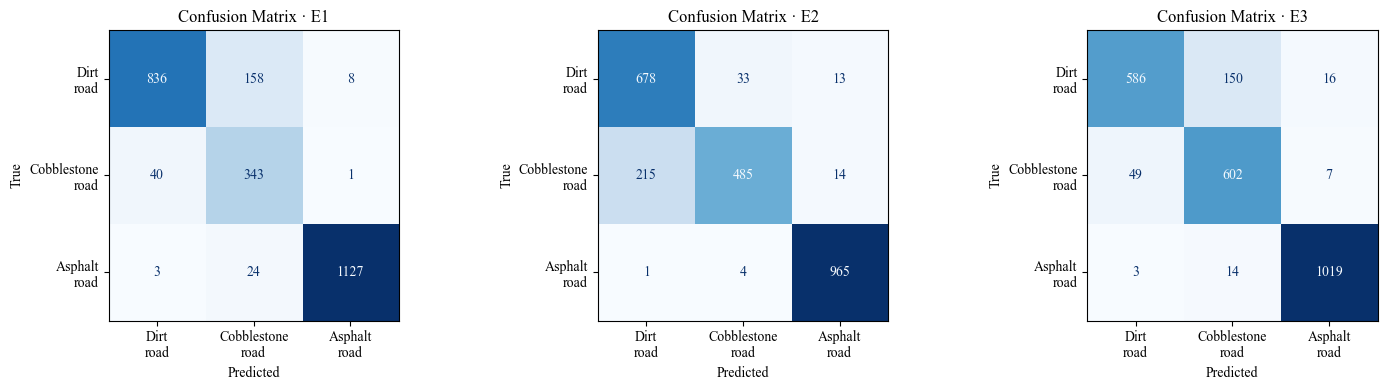

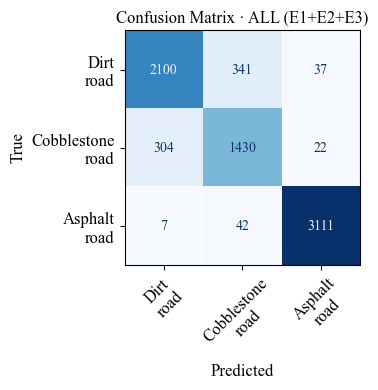

In [62]:
# Cell 11: Confusion matrices (per-exp và tổng)

LABEL_NAMES = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]
CLASS_IDS   = [0, 1, 2]

exps = ["E1", "E2", "E3"]
y_tests, y_preds = {}, {}

# Tái huấn luyện + dự đoán trên test cho từng exp để vẽ CM
for exp in exps:
    print(f"[CM] Refit & predict on {exp}")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = LGBMClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_tests[exp] = y_test
    y_preds[exp] = y_pred

# --- Hình 1: 1 hàng 3 cột (E1/E2/E3) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, exp in enumerate(exps):
    ax = axes[idx]
    cm = confusion_matrix(y_tests[exp], y_preds[exp], labels=CLASS_IDS)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix · {exp}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# --- Hình 2: Tổng (gộp E1+E2+E3) ---
y_all_true = np.concatenate([y_tests[e] for e in exps], axis=0)
y_all_pred = np.concatenate([y_preds[e] for e in exps], axis=0)
cm_all = confusion_matrix(y_all_true, y_all_pred, labels=CLASS_IDS)

fig2, ax2 = plt.subplots(1, 1, figsize=(4, 4))
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=LABEL_NAMES)
disp_all.plot(ax=ax2, values_format='d', cmap="Blues", colorbar=False)
ax2.set_title("Confusion Matrix · ALL (E1+E2+E3)")
ax2.set_xlabel("Predicted", fontsize=12)
ax2.set_ylabel("True", fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 12 — Classification report

In [63]:
# Cell 12: Classification reports (per-exp và tổng)

exps = ["E1", "E2", "E3"]

# for exp in exps:
#     print(f"\n===== Classification Report · {exp} =====")
#     print(classification_report(
#         y_tests[exp],
#         y_preds[exp],
#         labels=[0,1,2],
#         target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
#         digits=4
#     ))

print("\n===== Classification Report · ALL (E1+E2+E3) =====")
print(classification_report(
    y_all_true,
    y_all_pred,
    labels=[0,1,2],
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))



===== Classification Report · ALL (E1+E2+E3) =====
                  precision    recall  f1-score   support

       Dirt road     0.8710    0.8475    0.8591      2478
Cobblestone road     0.7887    0.8144    0.8013      1756
    Asphalt road     0.9814    0.9845    0.9829      3160

        accuracy                         0.8982      7394
       macro avg     0.8804    0.8821    0.8811      7394
    weighted avg     0.8986    0.8982    0.8983      7394



## Cell 13 — Huấn luyện trên toàn bộ PVS và xuất mã C

In [64]:
# Cell 13: Huấn luyện trên toàn bộ PVS và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_LGBM = LGBMClassifier(**BEST_PARAMS, random_state=42)
final_clf_LGBM.fit(X_all, y_all)

# Xuất mô hình sang header C/C++ bằng m2cgen
header_file = "m2cgen_PVS_LGBM.h"

try:
    c_cpp_code = export_to_c(final_clf_LGBM)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 7180, number of used features: 158
[LightGBM] [Info] Start training from score -1.280154
[LightGBM] [Info] Start training from score -1.231269
[LightGBM] [Info] Start training from score -0.843776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


✅ Exported to 'm2cgen_PVS_LGBM.h'
📦 Header size: 803.54 KB (0.785 MB)


# 2 vị trí kết hợp - dashboard + below

## Cell 1 — Imports, cấu hình & định nghĩa Experiments 1–3

In [65]:
# Cell 1: Imports, constants, experiments
import os, json, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from m2cgen.exporters import export_to_c

# Thiết lập font mặc định Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Gốc thư mục PVS
BASE_DIR = r"D:\BVHoan\Spiiras Proceedings\Passive Vehicular Sensors Datasets"
PVS_FOLDERS = [os.path.join(BASE_DIR, f"PVS {i}") for i in range(1, 10)]

# Cấu hình phân đoạn
WINDOW_SIZE = 600
STRIDE = 300

# =========================
# Chọn thủ công cấu hình sensor
# =========================
# Hỗ trợ: "dashboard","above","below",
#         "dashboard+above", "dashboard+below", "above+below",
#         "dashboard+above+below"
ACTIVE_PRESET = "dashboard+below"  # <-- chỉnh tại đây khi muốn thử cấu hình khác

# Định nghĩa các kênh IMU cho từng vị trí (mỗi vị trí có cả L/R; tên cột giống nhau giữa left/right CSV)
DASH_IMU = [
    "acc_x_dashboard", "acc_y_dashboard", "acc_z_dashboard",
    "gyro_x_dashboard", "gyro_y_dashboard", "gyro_z_dashboard",
]
ABOVE_IMU = [
    "acc_x_above_suspension", "acc_y_above_suspension", "acc_z_above_suspension",
    "gyro_x_above_suspension", "gyro_y_above_suspension", "gyro_z_above_suspension",
]
BELOW_IMU = [
    "acc_x_below_suspension", "acc_y_below_suspension", "acc_z_below_suspension",
    "gyro_x_below_suspension", "gyro_y_below_suspension", "gyro_z_below_suspension",
]

# Bảng preset (chỉ liệt kê kênh IMU; cột speed sẽ được thêm một lần ở cuối)
SENSOR_PRESETS = {
    "dashboard": DASH_IMU,
    "above": ABOVE_IMU,
    "below": BELOW_IMU,
    "dashboard+above": DASH_IMU + ABOVE_IMU,
    "dashboard+below": DASH_IMU + BELOW_IMU,
    "above+below": ABOVE_IMU + BELOW_IMU,
    "dashboard+above+below": DASH_IMU + ABOVE_IMU + BELOW_IMU,
}

def choose_active_preset(name: str, include_speed: bool = True):
    if name not in SENSOR_PRESETS:
        raise ValueError(f"Unknown preset '{name}'. Allowed: {list(SENSOR_PRESETS.keys())}")
    cols = list(SENSOR_PRESETS[name])  # copy
    if include_speed:
        cols = cols + ["speed"]  # chỉ một cột speed dùng chung cho toàn cấu hình
    return cols

# Danh sách cột đầu vào cho run hiện tại
SENSOR_COLUMNS = choose_active_preset(ACTIVE_PRESET, include_speed=True)

print(f"✅ Using preset: {ACTIVE_PRESET}")
print(f"   → #IMU channels (không tính speed): {len(SENSOR_COLUMNS) - 1}")
print(f"   → Tổng số kênh (đã gồm speed):      {len(SENSOR_COLUMNS)}")

# Nhãn tác vụ chính (mutually exclusive)
LABEL_COLUMNS = ["dirt_road", "cobblestone_road", "asphalt_road"]

# Cấu hình chia theo Menegazzo
EXPERIMENTS = {
    1: {"train": ["PVS 1", "PVS 3", "PVS 4", "PVS 6", "PVS 7", "PVS 9"],
        "test":  ["PVS 2", "PVS 5", "PVS 8"]},
    2: {"train": ["PVS 1", "PVS 2", "PVS 3", "PVS 7", "PVS 8", "PVS 9"],
        "test":  ["PVS 4", "PVS 5", "PVS 6"]},
    3: {"train": ["PVS 1", "PVS 2", "PVS 4", "PVS 6", "PVS 8", "PVS 9"],
        "test":  ["PVS 3", "PVS 5", "PVS 7"]},
}


✅ Using preset: dashboard+below
   → #IMU channels (không tính speed): 12
   → Tổng số kênh (đã gồm speed):      13


## Cell 2 — I/O & kiểm tra: đọc 3 file trong 1 PVS, cửa sổ, majority label

In [66]:
# Cell 2: IO, validation, windowing, majority label

def load_pvs_triplet(pvs_dir: str):
    """
    Đọc 3 file trong một thư mục PVS:
      - dataset_gps_mpu_left.csv
      - dataset_gps_mpu_right.csv
      - dataset_labels.csv
    Trả về (left_df, right_df, labels_df) và kiểm tra cấu trúc tối thiểu
    theo cấu hình cột hiện hành (SENSOR_COLUMNS từ Cell 1).
    """
    left_path  = os.path.join(pvs_dir, "dataset_gps_mpu_left.csv")
    right_path = os.path.join(pvs_dir, "dataset_gps_mpu_right.csv")
    label_path = os.path.join(pvs_dir, "dataset_labels.csv")

    if not (os.path.exists(left_path) and os.path.exists(right_path) and os.path.exists(label_path)):
        raise FileNotFoundError(f"Missing one of required files in: {pvs_dir}")

    left_df  = pd.read_csv(left_path)
    right_df = pd.read_csv(right_path)
    labels_df= pd.read_csv(label_path)

    # Hàng phải khớp 1–1 giữa 3 file (đồng bộ theo chỉ số dòng)
    if not (len(left_df) == len(right_df) == len(labels_df)):
        raise ValueError(
            f"Row mismatch in {pvs_dir}: left={len(left_df)}, right={len(right_df)}, labels={len(labels_df)}"
        )

    # --- Kiểm tra cột theo preset hiện hành ---
    # Tất cả kênh trừ 'speed' phải có ở cả left và right.
    imu_cols = [c for c in SENSOR_COLUMNS if c != "speed"]
    missing_imu = [c for c in imu_cols if (c not in left_df.columns or c not in right_df.columns)]
    if missing_imu:
        raise KeyError(f"Missing IMU columns {missing_imu} in {pvs_dir} (left/right)")

    # 'speed' phải có ít nhất ở một trong hai file (giá trị hai phía giống nhau là mong đợi)
    if "speed" in SENSOR_COLUMNS:
        has_speed_left  = "speed" in left_df.columns
        has_speed_right = "speed" in right_df.columns
        if not (has_speed_left or has_speed_right):
            raise KeyError(f"Missing column 'speed' in {pvs_dir} (neither left nor right)")

        # Nếu có ở cả hai, kiểm tra gần như nhau (sanity check, không dừng nếu lệch rất nhỏ do làm tròn)
        if has_speed_left and has_speed_right:
            try:
                if not np.allclose(left_df["speed"].values, right_df["speed"].values, atol=1e-6, rtol=1e-6):
                    print(f"[Warn] 'speed' differs between left/right in {pvs_dir}. "
                          f"Values should be identical (GPS shared). Proceeding with files as-is.")
            except Exception:
                # Trường hợp dtype lạ hoặc NaN; chỉ cảnh báo nhẹ
                print(f"[Warn] Could not compare 'speed' columns in {pvs_dir} due to dtype/NaN issues.")

    # Cột nhãn one-hot bắt buộc
    for col in LABEL_COLUMNS:
        if col not in labels_df.columns:
            raise KeyError(f"Label column '{col}' missing in {pvs_dir}/dataset_labels.csv")

    return left_df, right_df, labels_df

def window_indices(n_samples: int, window: int, stride: int):
    """Sinh danh sách (start, end) cho các cửa sổ trượt."""
    idx = []
    start = 0
    while start + window <= n_samples:
        idx.append((start, start + window))
        start += stride
    return idx

def majority_label_onehot(block_labels, label_cols=LABEL_COLUMNS):
    """
    Lấy nhãn majority trong cửa sổ theo tổng one-hot; khi hòa,
    dùng mode() giống Menegazzo.
    """
    sums = block_labels[label_cols].sum(axis=0)
    max_sum = sums.max()
    tied = [cls for cls, val in sums.items() if val == max_sum]
    if len(tied) == 1:
        return tied[0]
    # dùng mode() giống Menegazzo
    mode_label = block_labels[label_cols].mode().iloc[0]
    for cls in label_cols:
        if mode_label[cls] == 1:
            return cls
    return tied[0]


## Cell 3 — Phân đoạn một lần duy nhất và gắn provenance PVS

In [67]:
# Cell 3: Single-pass segmentation with provenance (both sides as independent samples)

def build_windows_by_pvs(pvs_folders):
    """
    Trả về:
      windows_by_pvs = {
        'PVS 1': {'dirt_road': [np.array(WINDOW_SIZE, n_channels), ...],
                  'cobblestone_road': [...],
                  'asphalt_road': [...]},
        ...
      }
    Mỗi cửa sổ là một mẫu; left/right được coi là 2 mẫu độc lập (đúng Menegazzo).
    """
    windows_by_pvs = {}
    global_summary = Counter()

    for pvs_dir in pvs_folders:
        pvs_name = os.path.basename(pvs_dir)  # "PVS i"
        try:
            left_df, right_df, labels_df = load_pvs_triplet(pvs_dir)
        except Exception as e:
            print(f"[WARN] Skip {pvs_name}: {e}")
            continue

        # -----------------------------
        # 1) Chuẩn bị tín hiệu đầu vào
        # -----------------------------
        # Sao chép SENSOR_COLUMNS để tách speed riêng
        cols_no_speed = [c for c in SENSOR_COLUMNS if c != "speed"]
        include_speed = "speed" in SENSOR_COLUMNS

        # Các cột IMU phải có ở cả left & right
        left_sig_imu  = left_df[cols_no_speed].to_numpy(dtype=np.float32)
        right_sig_imu = right_df[cols_no_speed].to_numpy(dtype=np.float32)

        # Speed: chỉ lấy một nguồn (left ưu tiên)
        if include_speed:
            if "speed" in left_df.columns:
                speed_vec = left_df["speed"].to_numpy(dtype=np.float32)
            else:
                speed_vec = right_df["speed"].to_numpy(dtype=np.float32)
            speed_vec = speed_vec.reshape(-1, 1)
            # Ghép speed thành cột cuối
            left_sig  = np.hstack([left_sig_imu,  speed_vec])
            right_sig = np.hstack([right_sig_imu, speed_vec])
        else:
            left_sig, right_sig = left_sig_imu, right_sig_imu

        # -----------------------------
        # 2) Xử lý nhãn
        # -----------------------------
        labels_main = labels_df[LABEL_COLUMNS].astype(int)
        n = len(labels_main)
        win_idxs = window_indices(n, WINDOW_SIZE, STRIDE)
        if not win_idxs:
            print(f"[INFO] {pvs_name}: not enough samples for one window ({n} < {WINDOW_SIZE})")
            continue

        # -----------------------------
        # 3) Tạo kho lưu kết quả
        # -----------------------------
        windows_by_pvs.setdefault(pvs_name, {k: [] for k in LABEL_COLUMNS})

        # -----------------------------
        # 4) Cắt cửa sổ và gán nhãn
        # -----------------------------
        for (s, e) in win_idxs:
            cls = majority_label_onehot(labels_main.iloc[s:e], LABEL_COLUMNS)

            # Mỗi bên là một mẫu độc lập
            wL = left_sig[s:e, :]
            wR = right_sig[s:e, :]

            windows_by_pvs[pvs_name][cls].append(wL)
            windows_by_pvs[pvs_name][cls].append(wR)
            global_summary[cls] += 2

    # -----------------------------
    # 5) Log thống kê
    # -----------------------------
    print(f"=== Windows per PVS (preset: {ACTIVE_PRESET}) ===")
    for pvs_name in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
        line = [f"{cls}:{len(windows_by_pvs[pvs_name][cls])}" for cls in LABEL_COLUMNS]
        print(f"{pvs_name} -> " + " | ".join(line))

    print("\n=== Global class totals ===")
    for cls in LABEL_COLUMNS:
        print(f"{cls:17s}: {global_summary[cls]}")

    return windows_by_pvs

# Thực thi để sinh dữ liệu phân đoạn
windows_by_pvs = build_windows_by_pvs(PVS_FOLDERS)


=== Windows per PVS (preset: dashboard+below) ===
PVS 1 -> dirt_road:172 | cobblestone_road:412 | asphalt_road:374
PVS 2 -> dirt_road:298 | cobblestone_road:138 | asphalt_road:392
PVS 3 -> dirt_road:190 | cobblestone_road:176 | asphalt_road:336
PVS 4 -> dirt_road:160 | cobblestone_road:384 | asphalt_road:336
PVS 5 -> dirt_road:404 | cobblestone_road:120 | asphalt_road:366
PVS 6 -> dirt_road:160 | cobblestone_road:210 | asphalt_road:268
PVS 7 -> dirt_road:158 | cobblestone_road:362 | asphalt_road:334
PVS 8 -> dirt_road:300 | cobblestone_road:126 | asphalt_road:396
PVS 9 -> dirt_road:154 | cobblestone_road:168 | asphalt_road:286

=== Global class totals ===
dirt_road        : 1996
cobblestone_road : 2096
asphalt_road     : 3088


## Cell 4 — Tạo đủ 3 splits theo Menegazzo và in thống kê

In [68]:
# Cell 4: Build ALL 3 Menegazzo splits + stats

def _collect_from_pvs(pvs_list, windows_by_pvs, label_cols=LABEL_COLUMNS):
    bucket = {c: [] for c in label_cols}
    for pvs in pvs_list:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing; skipping.")
            continue
        for cls in label_cols:
            bucket[cls].extend(windows_by_pvs[pvs][cls])
    return bucket

def _print_split_stats(exp_id, split_name, lists_by_class, label_cols=LABEL_COLUMNS):
    total = sum(len(v) for v in lists_by_class.values())
    print(f"[Experiment {exp_id} · {split_name.upper()}] Total windows: {total}")
    for cls in label_cols:
        print(f"  {cls:17s}: {len(lists_by_class[cls])}")

def make_all_splits(windows_by_pvs, experiments=EXPERIMENTS):
    """
    Trả về:
      splits = {
        1: {"train": {"dirt_road":[...], ...}, "test": {...}},
        2: {...},
        3: {...}
      }
    """
    splits = {}
    for exp_id, conf in experiments.items():
        tr_pvs, te_pvs = conf["train"], conf["test"]
        train_lists = _collect_from_pvs(tr_pvs, windows_by_pvs)
        test_lists  = _collect_from_pvs(te_pvs, windows_by_pvs)

        splits[exp_id] = {"train": train_lists, "test": test_lists}

        print(f"=== Experiment {exp_id} ===")
        _print_split_stats(exp_id, "train", train_lists)
        _print_split_stats(exp_id, "test",  test_lists)

    return splits

splits = make_all_splits(windows_by_pvs)


=== Experiment 1 ===
[Experiment 1 · TRAIN] Total windows: 4640
  dirt_road        : 994
  cobblestone_road : 1712
  asphalt_road     : 1934
[Experiment 1 · TEST] Total windows: 2540
  dirt_road        : 1002
  cobblestone_road : 384
  asphalt_road     : 1154
=== Experiment 2 ===
[Experiment 2 · TRAIN] Total windows: 4772
  dirt_road        : 1272
  cobblestone_road : 1382
  asphalt_road     : 2118
[Experiment 2 · TEST] Total windows: 2408
  dirt_road        : 724
  cobblestone_road : 714
  asphalt_road     : 970
=== Experiment 3 ===
[Experiment 3 · TRAIN] Total windows: 4734
  dirt_road        : 1244
  cobblestone_road : 1438
  asphalt_road     : 2052
[Experiment 3 · TEST] Total windows: 2446
  dirt_road        : 752
  cobblestone_road : 658
  asphalt_road     : 1036


## Cell 5 — Sinh biến cho cả 3 experiment (không ghi đè nhau)

In [69]:
# Cell 5: Variables for all 3 experiments with suffixes _E1/_E2/_E3

def _vars_for_all_experiments(splits_dict):
    for exp_id in (1, 2, 3):
        sd = splits_dict[exp_id]

        globals()[f"train_dirt_road_E{exp_id}"]         = sd["train"]["dirt_road"]
        globals()[f"train_cobblestone_road_E{exp_id}"]  = sd["train"]["cobblestone_road"]
        globals()[f"train_asphalt_road_E{exp_id}"]      = sd["train"]["asphalt_road"]

        globals()[f"test_dirt_road_E{exp_id}"]          = sd["test"]["dirt_road"]
        globals()[f"test_cobblestone_road_E{exp_id}"]   = sd["test"]["cobblestone_road"]
        globals()[f"test_asphalt_road_E{exp_id}"]       = sd["test"]["asphalt_road"]

_vars_for_all_experiments(splits)

# peek a few counts so you can sanity-check at a glance
for k in ("train_dirt_road", "train_cobblestone_road", "train_asphalt_road",
          "test_dirt_road", "test_cobblestone_road", "test_asphalt_road"):
    for e in (1, 2, 3):
        v = globals()[f"{k}_E{e}"]
        print(f"{k}_E{e:1d}: {len(v)} windows")


train_dirt_road_E1: 994 windows
train_dirt_road_E2: 1272 windows
train_dirt_road_E3: 1244 windows
train_cobblestone_road_E1: 1712 windows
train_cobblestone_road_E2: 1382 windows
train_cobblestone_road_E3: 1438 windows
train_asphalt_road_E1: 1934 windows
train_asphalt_road_E2: 2118 windows
train_asphalt_road_E3: 2052 windows
test_dirt_road_E1: 1002 windows
test_dirt_road_E2: 724 windows
test_dirt_road_E3: 752 windows
test_cobblestone_road_E1: 384 windows
test_cobblestone_road_E2: 714 windows
test_cobblestone_road_E3: 658 windows
test_asphalt_road_E1: 1154 windows
test_asphalt_road_E2: 970 windows
test_asphalt_road_E3: 1036 windows


## Cell 6 — Tạo data_train/data_test + label_train/label_test cho từng experiment

In [70]:
# Cell 6: Build data_/label_ arrays for EACH experiment,
# groups cho mỗi cửa sổ (train/test) theo PVS (để dùng Group-aware CV)

def _vars_with_groups_for_experiment(exp_id):
    """
    Sinh data_/label_ + groups_ cho exp_id.
    Group = tên PVS của cửa sổ đó.
    Dùng danh sách cột linh hoạt SENSOR_COLUMNS (theo preset đã chọn).
    """
    data_train, label_train, groups_train = [], [], []

    # --- Build TRAIN ---
    for pvs in EXPERIMENTS[exp_id]["train"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TRAIN")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                # mỗi acts là np.array(window_size, n_channels)
                data_train.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_train.append(lab)
                groups_train.append(pvs)

    # --- Build TEST ---
    data_test, label_test, groups_test = [], [], []
    for pvs in EXPERIMENTS[exp_id]["test"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TEST")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                data_test.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_test.append(lab)
                groups_test.append(pvs)

    # --- Lưu vào biến toàn cục ---
    globals()[f"data_train_E{exp_id}"]   = data_train
    globals()[f"label_train_E{exp_id}"]  = label_train
    globals()[f"groups_train_E{exp_id}"] = groups_train

    globals()[f"data_test_E{exp_id}"]    = data_test
    globals()[f"label_test_E{exp_id}"]   = label_test
    globals()[f"groups_test_E{exp_id}"]  = groups_test

# Rebuild để có groups (E1–E3)
_vars_with_groups_for_experiment(1)
_vars_with_groups_for_experiment(2)
_vars_with_groups_for_experiment(3)

print("E1:", len(data_train_E1), "train /", len(data_test_E1), "test | #groups(train) =", len(set(groups_train_E1)))
print("E2:", len(data_train_E2), "train /", len(data_test_E2), "test | #groups(train) =", len(set(groups_train_E2)))
print("E3:", len(data_train_E3), "train /", len(data_test_E3), "test | #groups(train) =", len(set(groups_train_E3)))


E1: 4640 train / 2540 test | #groups(train) = 6
E2: 4772 train / 2408 test | #groups(train) = 6
E3: 4734 train / 2446 test | #groups(train) = 6


## Cell 7 — Feature extraction

In [71]:
# # Cell 7: Trích xuất đặc trưng

# def featuresFromBuffer(at):
#     feat = np.zeros(158, dtype=np.float32)
    
#     # ---- DASHBOARD ----
#     ax_dashboard = np.array(at['acc_x_dashboard'],  dtype=np.float32)
#     ay_dashboard = np.array(at['acc_y_dashboard'],  dtype=np.float32)
#     az_dashboard = np.array(at['acc_z_dashboard'],  dtype=np.float32)
#     gx_dashboard = np.array(at['gyro_x_dashboard'], dtype=np.float32)
#     gy_dashboard = np.array(at['gyro_y_dashboard'], dtype=np.float32)
#     gz_dashboard = np.array(at['gyro_z_dashboard'], dtype=np.float32)
    
#     # ---- BELOW ----
#     ax_below = np.array(at['acc_x_below_suspension'],  dtype=np.float32)
#     ay_below = np.array(at['acc_y_below_suspension'],  dtype=np.float32)
#     az_below = np.array(at['acc_z_below_suspension'],  dtype=np.float32)
#     gx_below = np.array(at['gyro_x_below_suspension'], dtype=np.float32)
#     gy_below = np.array(at['gyro_y_below_suspension'], dtype=np.float32)
#     gz_below = np.array(at['gyro_z_below_suspension'], dtype=np.float32)    
    
#     # ---- SPEED (chung) ----
#     sp = np.array(at['speed'], dtype=np.float32)
    
#     # Đặc trưng thống kê    
#     feat[0:13] = [np.mean(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below,
#                                        sp]] # mean
#     feat[13:26] = [np.std(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below,
#                                        sp]] # sd
#     feat[26:38] = [np.sqrt(np.mean(i**2)) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                                     gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # rms
#     feat[38:50] = [np.max(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # max
#     feat[50:62] = [np.min(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # min
#     feat[62:74] = [np.amax(i) - np.amin(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                                      gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # range
#     feat[74:86] = [np.median(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                           gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # median
#     feat[86:98] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                                                          gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # interquartile range
#     feat[98:110] = [skew(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                       gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # skewness
#     feat[110:122] = [kurtosis(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                            gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # kurtosis
#     feat[122:134] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # hjorth mobility
#     feat[134:146] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                                                                                                                      gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # hjorth complexity
#     feat[146:158] = [acf(i, nlags=1)[1] for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                                   gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # autocorrelation
    
#     return feat

# # Trích xuất đặc trưng cho từng cửa sổ
# train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
# test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
# train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
# test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
# train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
# test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

# # Ép sang numpy array
# train_features_E1 = np.array(train_features_E1, dtype=np.float32)
# test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
# train_features_E2 = np.array(train_features_E2, dtype=np.float32)
# test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
# train_features_E3 = np.array(train_features_E3, dtype=np.float32)
# test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

# print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
# print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
# print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
# print('Feature dimension:', train_features_E1.shape[1])

# # Gom toàn bộ dữ liệu từ PVS 1..9 (tránh dùng E1/E2/E3 để không đếm trùng)
# cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
# X_all, y_all = [], []

# # Đảm bảo thứ tự PVS 1..9 ổn định
# for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#     for cls_name, cls_id in cls_map:
#         for buf in windows_by_pvs[pvs][cls_name]:
#             # buf là ndarray (WINDOW_SIZE x len(SENSOR_COLUMNS))
#             at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#             feat = featuresFromBuffer(at)
#             X_all.append(feat)
#             y_all.append(cls_id)

# X_all = np.asarray(X_all, dtype=np.float32)
# y_all = np.asarray(y_all, dtype=np.int32)
# print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))


## Cell 7A — Tính & Lưu cache

In [72]:
# # Cell 7A: Compute & cache features for the current ACTIVE_PRESET

# def _extract_features_for_splits():
#     # y nguyên format Cell 7: tạo các mảng đặc trưng cho E1/E2/E3
#     train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
#     test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
#     train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
#     test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
#     train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
#     test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

#     # Ép sang numpy array
#     train_features_E1 = np.array(train_features_E1, dtype=np.float32)
#     test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
#     train_features_E2 = np.array(train_features_E2, dtype=np.float32)
#     test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
#     train_features_E3 = np.array(train_features_E3, dtype=np.float32)
#     test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

#     return (train_features_E1, test_features_E1,
#             train_features_E2, test_features_E2,
#             train_features_E3, test_features_E3)

# def _extract_features_all_pvs():
#     # Y nguyên logic gom ALL PVS (tránh đếm trùng E1/E2/E3)
#     cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
#     X_all, y_all = [], []

#     for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#         for cls_name, cls_id in cls_map:
#             for buf in windows_by_pvs[pvs][cls_name]:
#                 at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#                 feat = featuresFromBuffer(at)
#                 X_all.append(feat)
#                 y_all.append(cls_id)

#     X_all = np.asarray(X_all, dtype=np.float32)
#     y_all = np.asarray(y_all, dtype=np.int32)
#     return X_all, y_all

# def _save_feature_cache(fname,
#                         train_features_E1, test_features_E1,
#                         train_features_E2, test_features_E2,
#                         train_features_E3, test_features_E3,
#                         X_all, y_all):
#     # Lưu gọn bằng NPZ nén
#     np.savez_compressed(
#         fname,
#         ACTIVE_PRESET=np.array([ACTIVE_PRESET]),
#         SENSOR_COLUMNS=np.array(SENSOR_COLUMNS),
#         WINDOW_SIZE=np.array([WINDOW_SIZE], dtype=np.int32),
#         STRIDE=np.array([STRIDE], dtype=np.int32),
#         LABEL_COLUMNS=np.array(LABEL_COLUMNS),

#         train_features_E1=train_features_E1,
#         test_features_E1=test_features_E1,
#         train_features_E2=train_features_E2,
#         test_features_E2=test_features_E2,
#         train_features_E3=train_features_E3,
#         test_features_E3=test_features_E3,

#         X_all=X_all,
#         y_all=y_all
#     )

# # ---- Thực thi: tính & lưu ----
# cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
# print(f"⏳ Computing features for preset: {ACTIVE_PRESET} ...")

# (train_features_E1, test_features_E1,
#  train_features_E2, test_features_E2,
#  train_features_E3, test_features_E3) = _extract_features_for_splits()

# print("   • Splits done:",
#       f"E1: {train_features_E1.shape} / {test_features_E1.shape} |",
#       f"E2: {train_features_E2.shape} / {test_features_E2.shape} |",
#       f"E3: {train_features_E3.shape} / {test_features_E3.shape}")

# X_all, y_all = _extract_features_all_pvs()
# print("   • ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))

# _save_feature_cache(cache_name,
#                     train_features_E1, test_features_E1,
#                     train_features_E2, test_features_E2,
#                     train_features_E3, test_features_E3,
#                     X_all, y_all)

# size_bytes = os.path.getsize(cache_name)
# print(f"✅ Saved cache to '{cache_name}' ({size_bytes/1024/1024:.3f} MB)")


## Cell 7B — Nạp cache (dùng cho chạy nhanh về sau)

In [73]:
# Cell 7B: Load cached feature set for the current ACTIVE_PRESET

cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
if not os.path.exists(cache_name):
    raise FileNotFoundError(f"Feature cache not found: {cache_name}. Hãy chạy Cell 7A trước để tạo cache.")

data = np.load(cache_name, allow_pickle=True)

# Khôi phục biến đúng tên như Cell 7 gốc
train_features_E1 = data["train_features_E1"]
test_features_E1  = data["test_features_E1"]
train_features_E2 = data["train_features_E2"]
test_features_E2  = data["test_features_E2"]
train_features_E3 = data["train_features_E3"]
test_features_E3  = data["test_features_E3"]

X_all = data["X_all"]
y_all = data["y_all"]

# (tuỳ chọn) kiểm tra meta để cảnh báo nếu lệch preset
_cached_preset = str(data["ACTIVE_PRESET"][0])
if _cached_preset != ACTIVE_PRESET:
    print(f"[WARN] Cache preset = '{_cached_preset}' khác với ACTIVE_PRESET hiện tại = '{ACTIVE_PRESET}'")

# In thống kê giống Cell 7 gốc
print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
print('Feature dimension:', train_features_E1.shape[1])
print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))
print(f"✅ Loaded cache from '{cache_name}'")


E1: 4640 train samples / 2540 test samples
E2: 4772 train samples / 2408 test samples
E3: 4734 train samples / 2446 test samples
Feature dimension: 158
ALL PVS: (7180, 158) | class dist: [1996 2096 3088]
✅ Loaded cache from 'feature_set_dashboard+below.npz'


## Cell 8 — Find candidates

In [74]:
# Cell 8: Find candidates, LOGO trên 3 experiment → lấy 3 bộ tham số ứng viên (Accuracy), kèm kiểm tra model size ≤ 1.00 MB
print(f"✅ Using preset: {ACTIVE_PRESET}")

# Định nghĩa grid riêng cho từng exp
param_grids = {
    "E1": {
        "n_estimators": list(range(48, 49)),
        "max_depth": list(range(11, 13))
    },
    "E2": {
        "n_estimators": list(range(44, 45)),
        "max_depth": list(range(8, 9))
    },
    "E3": {
        "n_estimators": list(range(49, 50)),
        "max_depth": list(range(8, 9))
    }
}

# ---------------------- HÀM ĐO SIZE ----------------------
def measure_model_size_mb(params, X_full, y_full):
    """
    Train LGBMClassifier trên toàn bộ dữ liệu với 'params',
    export C/C++ header bằng m2cgen.exporters.export_to_c() rồi đo kích thước (MB).
    Trả về (size_mb, error_msg, c_code).
    """
    clf = LGBMClassifier(**params, random_state=42)
    clf.fit(X_full, y_full)

    tmp_header = None
    c_code = None
    err = ""
    size_mb = None
    try:
        c_code = export_to_c(clf)
        with tempfile.NamedTemporaryFile(mode="w", suffix=".h", delete=False, encoding="utf-8") as f:
            tmp_header = f.name
            f.write(c_code)

        size_bytes = os.path.getsize(tmp_header)
        size_mb = size_bytes / (1024 * 1024)
    except Exception as e:
        err = str(e)
    finally:
        if tmp_header and os.path.exists(tmp_header):
            os.remove(tmp_header)

    return size_mb, err, c_code

# ---------------------- HÀM LOGO + GRIDSEARCH CHO 1 EXP ----------------------
def run_logo_for_experiment(exp_name, X_train, y_train, groups, X_full_for_size, y_full_for_size,
                            param_grid, size_limit_mb=1.00):
    """
    - Chạy GridSearchCV với LOGO (Accuracy) trên (X_train, y_train, groups).
    - Với từng bộ params trong kết quả, train lại trên toàn bộ PVS 1–9 để đo size.
    - Chọn bộ params có:
        * size ≤ size_limit_mb
        * điểm cv (mean test Accuracy) cao nhất
      Tie-break: model nhỏ hơn → depth thấp hơn → số cây ít hơn.
    - Trả về dict ứng viên cho exp này.
    """
    print(f"\n===== EXP {exp_name}: START LOGO GRID (Accuracy) + SIZE CHECK ≤ {size_limit_mb:.2f} MB =====")
    logo = LeaveOneGroupOut()
    gs = GridSearchCV(
        estimator=LGBMClassifier(random_state=42),
        param_grid=param_grid,
        cv=logo.split(X_train, y_train, groups=groups),
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    best_cv = -np.inf
    best = None

    for i, params in enumerate(gs.cv_results_["params"], 1):
        cv_mean = gs.cv_results_["mean_test_score"][i-1]
        print(f"[{exp_name}] Check {i}/{len(gs.cv_results_['params'])}: {params} | CV Accuracy={cv_mean*100:.2f}")

        size_mb, err, _ = measure_model_size_mb(params, X_full_for_size, y_full_for_size)
        status = "ok"
        if err:
            status = f"error: {err}"
        elif size_mb is None:
            status = "error: size_none"
        elif size_mb > size_limit_mb:
            status = "oversize"

        print(f"   -> size={None if size_mb is None else f'{size_mb:.3f} MB'} | status={status}")

        if status == "ok":
            # update theo tiêu chí: cv cao nhất → size nhỏ hơn → depth thấp hơn → n_estimators ít hơn
            if (cv_mean > best_cv or
                (np.isclose(cv_mean, best_cv) and size_mb < best["size_mb"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] < best["params"]["max_depth"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] == best["params"]["max_depth"] and params["n_estimators"] < best["params"]["n_estimators"])
               ):
                best_cv = cv_mean
                best = {
                    "exp": exp_name,
                    "params": dict(params),
                    "cv_accuracy": float(cv_mean),
                    "size_mb": float(size_mb)
                }

    if best is None:
        best = {
            "exp": exp_name,
            "params": None,
            "cv_accuracy": None,
            "size_mb": None,
            "note": f"No feasible params ≤ {size_limit_mb:.2f} MB (or export error)"
        }
        print(f"[{exp_name}] WARNING: Không tìm thấy cấu hình khả thi (≤ {size_limit_mb:.2f} MB).")

    print(f"[{exp_name}] BEST CANDIDATE:", best)
    return best

candidates = []
candidates.append(run_logo_for_experiment("E1", train_features_E1, label_train_E1, groups_train_E1, X_all, y_all, param_grids["E1"]))
candidates.append(run_logo_for_experiment("E2", train_features_E2, label_train_E2, groups_train_E2, X_all, y_all, param_grids["E2"]))
candidates.append(run_logo_for_experiment("E3", train_features_E3, label_train_E3, groups_train_E3, X_all, y_all, param_grids["E3"]))

print("\n===== 3 ỨNG VIÊN LOGO (Accuracy, size≤1.00MB) =====")
for c in candidates:
    print(c)

# Lưu lại để dùng cho bước “chốt cuối”
with open("logo_candidates_LGBM.json", "w", encoding="utf-8") as f:
    json.dump(candidates, f, indent=2, ensure_ascii=False)

print("Đã lưu 3 ứng viên vào 'logo_candidates_LGBM.json'.")


✅ Using preset: dashboard+below

===== EXP E1: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 158
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[E1] Check 1/2: {'max_depth': 11, 'n_estimators': 48} | CV Accuracy=90.73
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 7180, number of used features: 158
[LightGBM] [Info] Start training from score -1.280154
[LightGBM] [Info] Start training from score -1.231269
[

In [75]:
# mean, sd, rms, max, min, range, median, iqr, skew, kurt, hm, hc, acf
# {'exp': 'E1', 'params': {'max_depth': 11, 'n_estimators': 48}, 'cv_accuracy': 0.9073, 'size_mb': 0.772} -> 91.90 Minimax regret
# {'exp': 'E2', 'params': {'max_depth': 08, 'n_estimators': 44}, 'cv_accuracy': 0.9267, 'size_mb': 0.676} -> 92.35
# {'exp': 'E3', 'params': {'max_depth': 08, 'n_estimators': 49}, 'cv_accuracy': 0.8958, 'size_mb': 0.753} -> 91.72 Maximin, Borda rank, Mean - λ·Std

## Cell 9 — Select candidates

In [76]:
# Cell 9: Select candidates, thử 4 tiêu chí trên bộ ba ứng viên (train-only, LOGO)

# ========= NẠP 3 ỨNG VIÊN =========
with open("logo_candidates_LGBM.json", "r", encoding="utf-8") as f:
    candidates = json.load(f)

# Đặt tên ngắn gọn cho ứng viên theo exp gốc của nó: 'cand_E1', 'cand_E2', 'cand_E3'
for c in candidates:
    c["name"] = f"cand_{c['exp']}"

# ========= CHUẨN BỊ DỮ LIỆU TRAIN+GROUPS CHO 3 EXP =========
X_train_dict = {
    "E1": train_features_E1,
    "E2": train_features_E2,
    "E3": train_features_E3,
}
y_train_dict = {
    "E1": np.asarray(label_train_E1),
    "E2": np.asarray(label_train_E2),
    "E3": np.asarray(label_train_E3),
}
groups_dict = {
    "E1": np.asarray(groups_train_E1),
    "E2": np.asarray(groups_train_E2),
    "E3": np.asarray(groups_train_E3),
}

# ========= HÀM LOGO SCORE (Accuracy, train-only) =========
def logo_cv_accuracy_for_exp(params, X, y, groups):
    """
    Cố định bộ tham số 'params' => chạy LOGO trên (X,y,groups) => trả về mean Accuracy.
    """
    logo = LeaveOneGroupOut()
    f1s = []
    # Duyệt từng split LOGO
    for tr_idx, va_idx in logo.split(X, y, groups=groups):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        clf = LGBMClassifier(**params, random_state=42)
        clf.fit(X_tr, y_tr)
        y_hat = clf.predict(X_va)
        f1s.append(accuracy_score(y_va, y_hat))
    return float(np.mean(f1s))

# ========= TÍNH MA TRẬN ĐIỂM S_k(h) (k ∈ {E1,E2,E3}, h ∈ 3 ứng viên) =========
exps = ["E1", "E2", "E3"]
H = len(candidates)
K = len(exps)

scores = np.zeros((H, K), dtype=float)  # S[h,k] = Accuracy của ứng viên h trên exp k
for h, cand in enumerate(candidates):
    params = cand["params"]
    print(f"\n>>> Scoring {cand['name']} with params={params}")
    for k, ek in enumerate(exps):
        S_hk = logo_cv_accuracy_for_exp(params, X_train_dict[ek], y_train_dict[ek], groups_dict[ek])
        scores[h, k] = S_hk
        print(f"   {ek}: Accuracy(LOGO) = {S_hk*100:.2f}")

# ========= TIỆN ÍCH: TIE-BREAK =========
def tie_break_key(h):
    # size nhỏ hơn → depth nhỏ hơn → n_estimators ít hơn
    size = candidates[h].get("size_mb", np.inf)
    depth = candidates[h]["params"]["max_depth"]
    trees = candidates[h]["params"]["n_estimators"]
    return (size, depth, trees)

# ========= 1) MAXIMIN =========
worst_case = scores.min(axis=1)             # min_k S_k(h)
best_h_maximin = max(range(H), key=lambda h: (worst_case[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= 2) BORDA RANK =========
def ranks_desc(vals):
    """
    Trả về rank (1 = tốt nhất) theo thứ tự giảm dần của vals.
    Ties => average-rank.
    """
    vals = np.asarray(vals)
    # sắp xếp giảm dần
    order = np.argsort(-vals)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(vals) + 1, dtype=float)
    # xử lý ties (average rank)
    for v in np.unique(vals):
        idx = np.where(vals == v)[0]
        if len(idx) > 1:
            avg = ranks[idx].mean()
            ranks[idx] = avg
    return ranks

borda = np.zeros(H, dtype=float)
for k in range(K):
    borda += ranks_desc(scores[:, k])
best_h_borda = min(range(H), key=lambda h: (borda[h], tie_break_key(h)))

# ========= 3) MINIMAX REGRET =========
best_per_exp = scores.max(axis=0)           # S*_k
regret = best_per_exp - scores              # Reg_k(h) = S*_k - S_k(h)
max_regret = regret.max(axis=1)             # max_k Reg_k(h)
best_h_regret = min(range(H), key=lambda h: (max_regret[h], tie_break_key(h)))

# ========= 4) MEAN − λ·STD (λ suy từ dữ liệu) =========
means = scores.mean(axis=1)
stds  = scores.std(axis=1, ddof=0)

sigma_typ = float(np.median(stds))
c_pp = 0.01  # 1.0 điểm phần trăm F1  => 0.01 theo thang [0,1]
# Nếu bạn thích 0.5–1.5 pp, đổi c_pp = 0.005 ~ 0.015
if sigma_typ > 0:
    lam = c_pp / sigma_typ
else:
    lam = 0.1
lam = float(np.clip(lam, 0.1, 1.0))

risk_adj = means - lam * stds
best_h_mean_std = max(range(H), key=lambda h: (risk_adj[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= IN KẾT QUẢ =========
def pretty_candidate(h):
    c = candidates[h]
    return {
        "name": c["name"],
        "params": c["params"],
        "size_mb": round(float(c.get("size_mb", np.nan)), 3),
        "S_E1": round(scores[h,0]*100, 2),
        "S_E2": round(scores[h,1]*100, 2),
        "S_E3": round(scores[h,2]*100, 2),
        "mean": round(means[h]*100, 2),
        "std": round(stds[h], 2)
    }

print("\n===== SCORE MATRIX (Accuracy, train-only LOGO) =====")
for h in range(H):
    print(pretty_candidate(h))

print("\n===== SELECTIONS (4 tiêu chí) =====")
print(f"Maximin         -> {pretty_candidate(best_h_maximin)}")
print(f"Borda rank      -> {pretty_candidate(best_h_borda)}")
print(f"Minimax regret  -> {pretty_candidate(best_h_regret)}")
print(f"Mean - λ·Std    -> {pretty_candidate(best_h_mean_std)}  (λ = {lam:.4f}, c_pp={c_pp})")



>>> Scoring cand_E1 with params={'max_depth': 11, 'n_estimators': 48}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 158
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3938, number of used features: 158
[LightGBM] [Info] Start training from score -1.588829
[LightGBM] [Info] Start training from score -0.941491
[LightGBM] [Info] Start training from score -0.901920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 158
[LightGBM] [Info] Start training from score -1.505941
[LightGBM] [Info] Start training from score -1.040745
[LightGBM] [Info] Start training from score -0.855666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4002, number of used features: 158
[LightGBM] [Info] Start training from score -1.568316
[LightGBM] [Info] Start training from score -0.979997
[LightGBM] [Info] Start training from score -0.876369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3786, number of used features: 158
[LightGBM] [Info] Start training from score -1.510437
[LightGBM] [Info] Start training from score -1.031205
[LightGBM] [Info] Start training from score -0.861306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4032, number of used features: 158
[LightGBM] [Info] Start training from score -1.568616
[LightGBM] [Info] Start training from score -0.959886
[LightGBM] [Info] Start training from score -0.894700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E1: Accuracy(LOGO) = 90.73
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3814, number of used features: 158
[LightGBM] [Info] Start training from score -1.243368
[LightGBM] [Info] Start training from score -1.369138
[LightGBM] [Info] Start training from score -0.782497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 158
[LightGBM] [Info] Start training from score -1.398539
[LightGBM] [Info] Start training from score -1.153863
[LightGBM] [Info] Start training from score -0.826389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4070, number of used features: 158
[LightGBM] [Info] Start training from score -1.324832
[LightGBM] [Info] Start training from score -1.216334
[LightGBM] [Info] Start training from score -0.825907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 158
[LightGBM] [Info] Start training from score -1.257624
[LightGBM] [Info] Start training from score -1.345779
[LightGBM] [Info] Start training from score -0.786723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 158
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the trai

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E2: Accuracy(LOGO) = 92.39
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 158
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3906, number of used features: 158
[LightGBM] [Info] Start training from score -1.418027
[LightGBM] [Info] Start training from score -1.100150
[LightGBM] [Info] Start training from score -0.855696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3854, number of used features: 158
[LightGBM] [Info] Start training from score -1.268454
[LightGBM] [Info] Start training from score -1.296519
[LightGBM] [Info] Start training from score -0.809116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 158
[LightGBM] [Info] Start training from score -1.329353
[LightGBM] [Info] Start training from score -1.204624
[LightGBM] [Info] Start training from score -0.831153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 158
[LightGBM] [Info] Start training from score -1.421678
[LightGBM] [Info] Start training from score -1.092496
[LightGBM] [Info] Start training from score -0.859644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4126, number of used features: 158
[LightGBM] [Info] Start training from score -1.331131
[LightGBM] [Info] Start training from score -1.178292
[LightGBM] [Info] Start training from score -0.848591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E3: Accuracy(LOGO) = 89.29

>>> Scoring cand_E2 with params={'max_depth': 8, 'n_estimators': 44}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 158
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 158
[LightGBM] [Info] Start training from score -1.398539
[LightGBM] [Info] Start training from score -1.153863
[LightGBM] [Info] Start training from score -0.826389


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 158
[LightGBM] [Info] Start training from score -1.257624
[LightGBM] [Info] Start training from score -1.345779
[LightGBM] [Info] Start training from score -0.786723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4164, number of used features: 158
[LightGBM] [Info] Start training from score -1.314935
[LightGBM] [Info] Start training from score -1.232555
[LightGBM] [Info] Start training from score -0.821068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E2: Accuracy(LOGO) = 92.67


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 158
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3854, number of used features: 158
[LightGBM] [Info] Start training from score -1.268454
[LightGBM] [Info] Start training from score -1.296519
[LightGBM] [Info] Start training from score -0.809116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 158
[LightGBM] [Info] Start training from score -1.421678
[LightGBM] [Info] Start training from score -1.092496
[LightGBM] [Info] Start training from score -0.859644


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E3: Accuracy(LOGO) = 89.39

>>> Scoring cand_E3 with params={'max_depth': 8, 'n_estimators': 49}


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 158
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4002, number of used features: 158
[LightGBM] [Info] Start training from score -1.568316
[LightGBM] [Info] Start training from score -0.979997
[LightGBM] [Info] Start training from score -0.876369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3814, number of used features: 158
[LightGBM] [Info] Start training from score -1.243368
[LightGBM] [Info] Start training from score -1.369138
[LightGBM] [Info] Start training from score -0.782497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4070, number of used features: 158
[LightGBM] [Info] Start training from score -1.324832
[LightGBM] [Info] Start training from score -1.216334
[LightGBM] [Info] Start training from score -0.825907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 158
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E2: Accuracy(LOGO) = 92.49


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 158
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3854, number of used features: 158
[LightGBM] [Info] Start training from score -1.268454
[LightGBM] [Info] Start training from score -1.296519
[LightGBM] [Info] Start training from score -0.809116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 158
[LightGBM] [Info] Start training from score -1.421678
[LightGBM] [Info] Start training from score -1.092496
[LightGBM] [Info] Start training from score -0.859644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E3: Accuracy(LOGO) = 89.58

===== SCORE MATRIX (Accuracy, train-only LOGO) =====
{'name': 'cand_E

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Cell 10 — Đánh giá độc lập trên test_E1/E2/E3

In [77]:
# Cell 10: Đánh giá độc lập trên test_E1/E2/E3

BEST_PARAMS = {"max_depth": 8, "n_estimators": 49}

exps = ["E1", "E2", "E3"]
train_results = []
test_results  = []

for exp in exps:
    print(f"\n===== Evaluation on {exp} =====")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = LGBMClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)

    # --- TRAINING (Menegazzo: "Training") ---
    y_pred_tr = clf.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)

    # --- TESTING (Menegazzo: "Validation") ---
    y_pred_te = clf.predict(X_test)
    acc_te = accuracy_score(y_test, y_pred_te)

    print(f"Training   -> Acc = {acc_tr*100:6.2f}")
    print(f"Validation -> Acc = {acc_te*100:6.2f}")

    train_results.append({"exp": exp, "acc": acc_tr})
    test_results.append( {"exp": exp, "acc": acc_te})

# ----- Tổng hợp kiểu Menegazzo -----
def _summarize(rows, key):
    vals = [r[key] for r in rows]
    return np.mean(vals), np.std(vals)

m_acc_tr, s_acc_tr = _summarize(train_results, "acc")
m_acc_te, s_acc_te = _summarize(test_results, "acc")

print("\n===== FINAL SUMMARY =====")
print(f"[Training]    Accuracy    : {m_acc_tr*100:.2f} ± {s_acc_tr*100:.2f}")
print(f"[Validation]  Accuracy    : {m_acc_te*100:.2f} ± {s_acc_te*100:.2f}")



===== Evaluation on E1 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 158
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training   -> Acc = 100.00
Validation -> Acc =  88.21

===== Evaluation on E3 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in t

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training   -> Acc = 100.00
Validation -> Acc =  92.44

===== FINAL SUMMARY =====
[Training]    Accuracy    : 100.00 ± 0.00
[Validation]  Accuracy    : 91.72 ± 2.63


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Cell 11 — Confusion matrix

[CM] Refit & predict on E1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 158
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CM] Refit & predict on E2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 158
[LightGBM] [Info] Start training from score -1.322175
[LightGBM] [Info] Start train

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


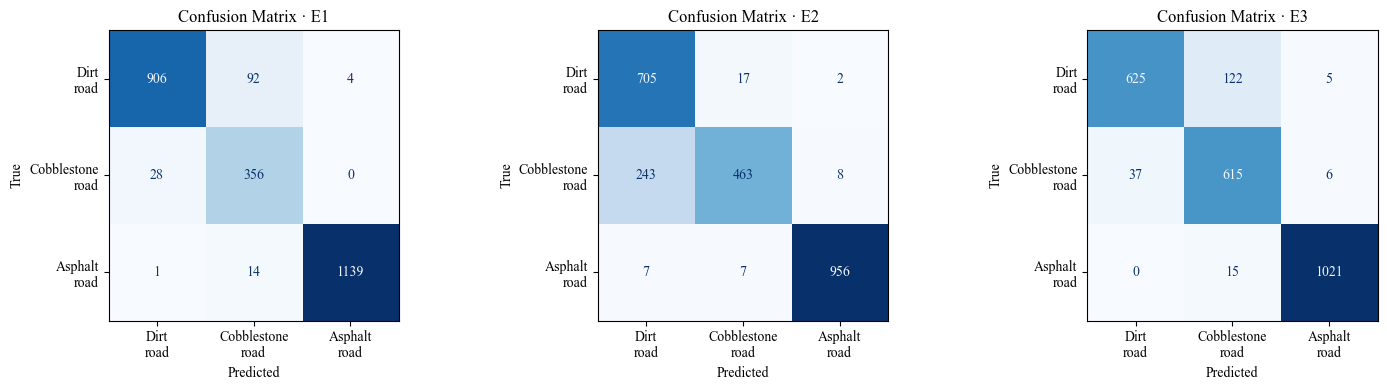

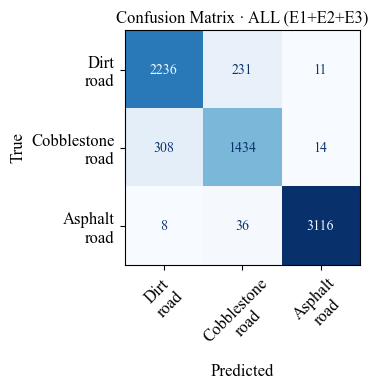

In [78]:
# Cell 11: Confusion matrices (per-exp và tổng)

LABEL_NAMES = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]
CLASS_IDS   = [0, 1, 2]

exps = ["E1", "E2", "E3"]
y_tests, y_preds = {}, {}

# Tái huấn luyện + dự đoán trên test cho từng exp để vẽ CM
for exp in exps:
    print(f"[CM] Refit & predict on {exp}")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = LGBMClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_tests[exp] = y_test
    y_preds[exp] = y_pred

# --- Hình 1: 1 hàng 3 cột (E1/E2/E3) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, exp in enumerate(exps):
    ax = axes[idx]
    cm = confusion_matrix(y_tests[exp], y_preds[exp], labels=CLASS_IDS)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix · {exp}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# --- Hình 2: Tổng (gộp E1+E2+E3) ---
y_all_true = np.concatenate([y_tests[e] for e in exps], axis=0)
y_all_pred = np.concatenate([y_preds[e] for e in exps], axis=0)
cm_all = confusion_matrix(y_all_true, y_all_pred, labels=CLASS_IDS)

fig2, ax2 = plt.subplots(1, 1, figsize=(4, 4))
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=LABEL_NAMES)
disp_all.plot(ax=ax2, values_format='d', cmap="Blues", colorbar=False)
ax2.set_title("Confusion Matrix · ALL (E1+E2+E3)")
ax2.set_xlabel("Predicted", fontsize=12)
ax2.set_ylabel("True", fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 12 — Classification report

In [79]:
# Cell 12: Classification reports (per-exp và tổng)

exps = ["E1", "E2", "E3"]

# for exp in exps:
#     print(f"\n===== Classification Report · {exp} =====")
#     print(classification_report(
#         y_tests[exp],
#         y_preds[exp],
#         labels=[0,1,2],
#         target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
#         digits=4
#     ))

print("\n===== Classification Report · ALL (E1+E2+E3) =====")
print(classification_report(
    y_all_true,
    y_all_pred,
    labels=[0,1,2],
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))



===== Classification Report · ALL (E1+E2+E3) =====
                  precision    recall  f1-score   support

       Dirt road     0.8762    0.9023    0.8891      2478
Cobblestone road     0.8430    0.8166    0.8296      1756
    Asphalt road     0.9920    0.9861    0.9890      3160

        accuracy                         0.9178      7394
       macro avg     0.9037    0.9017    0.9026      7394
    weighted avg     0.9178    0.9178    0.9177      7394



## Cell 13 — Huấn luyện trên toàn bộ PVS và xuất mã C

In [80]:
# Cell 13: Huấn luyện trên toàn bộ PVS và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_LGBM = LGBMClassifier(**BEST_PARAMS, random_state=42)
final_clf_LGBM.fit(X_all, y_all)

# Xuất mô hình sang header C/C++ bằng m2cgen
header_file = "m2cgen_PVS_LGBM.h"

try:
    c_cpp_code = export_to_c(final_clf_LGBM)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 7180, number of used features: 158
[LightGBM] [Info] Start training from score -1.280154
[LightGBM] [Info] Start training from score -1.231269
[LightGBM] [Info] Start training from score -0.843776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ Exported to 'm2cgen_PVS_LGBM.h'
📦 Header size: 771.51 KB (0.753 MB)


# 2 vị trí kết hợp - above + below

## Cell 1 — Imports, cấu hình & định nghĩa Experiments 1–3

In [1]:
# Cell 1: Imports, constants, experiments
import os, json, tempfile, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from m2cgen.exporters import export_to_c

# Thiết lập font mặc định Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Gốc thư mục PVS
BASE_DIR = r"D:\BVHoan\Spiiras Proceedings\Passive Vehicular Sensors Datasets"
PVS_FOLDERS = [os.path.join(BASE_DIR, f"PVS {i}") for i in range(1, 10)]

# Cấu hình phân đoạn
WINDOW_SIZE = 600
STRIDE = 300

# =========================
# Chọn thủ công cấu hình sensor
# =========================
# Hỗ trợ: "dashboard","above","below",
#         "dashboard+above", "dashboard+below", "above+below",
#         "dashboard+above+below"
ACTIVE_PRESET = "above+below"  # <-- chỉnh tại đây khi muốn thử cấu hình khác

# Định nghĩa các kênh IMU cho từng vị trí (mỗi vị trí có cả L/R; tên cột giống nhau giữa left/right CSV)
DASH_IMU = [
    "acc_x_dashboard", "acc_y_dashboard", "acc_z_dashboard",
    "gyro_x_dashboard", "gyro_y_dashboard", "gyro_z_dashboard",
]
ABOVE_IMU = [
    "acc_x_above_suspension", "acc_y_above_suspension", "acc_z_above_suspension",
    "gyro_x_above_suspension", "gyro_y_above_suspension", "gyro_z_above_suspension",
]
BELOW_IMU = [
    "acc_x_below_suspension", "acc_y_below_suspension", "acc_z_below_suspension",
    "gyro_x_below_suspension", "gyro_y_below_suspension", "gyro_z_below_suspension",
]

# Bảng preset (chỉ liệt kê kênh IMU; cột speed sẽ được thêm một lần ở cuối)
SENSOR_PRESETS = {
    "dashboard": DASH_IMU,
    "above": ABOVE_IMU,
    "below": BELOW_IMU,
    "dashboard+above": DASH_IMU + ABOVE_IMU,
    "dashboard+below": DASH_IMU + BELOW_IMU,
    "above+below": ABOVE_IMU + BELOW_IMU,
    "dashboard+above+below": DASH_IMU + ABOVE_IMU + BELOW_IMU,
}

def choose_active_preset(name: str, include_speed: bool = True):
    if name not in SENSOR_PRESETS:
        raise ValueError(f"Unknown preset '{name}'. Allowed: {list(SENSOR_PRESETS.keys())}")
    cols = list(SENSOR_PRESETS[name])  # copy
    if include_speed:
        cols = cols + ["speed"]  # chỉ một cột speed dùng chung cho toàn cấu hình
    return cols

# Danh sách cột đầu vào cho run hiện tại
SENSOR_COLUMNS = choose_active_preset(ACTIVE_PRESET, include_speed=True)

print(f"✅ Using preset: {ACTIVE_PRESET}")
print(f"   → #IMU channels (không tính speed): {len(SENSOR_COLUMNS) - 1}")
print(f"   → Tổng số kênh (đã gồm speed):      {len(SENSOR_COLUMNS)}")

# Nhãn tác vụ chính (mutually exclusive)
LABEL_COLUMNS = ["dirt_road", "cobblestone_road", "asphalt_road"]

# Cấu hình chia theo Menegazzo
EXPERIMENTS = {
    1: {"train": ["PVS 1", "PVS 3", "PVS 4", "PVS 6", "PVS 7", "PVS 9"],
        "test":  ["PVS 2", "PVS 5", "PVS 8"]},
    2: {"train": ["PVS 1", "PVS 2", "PVS 3", "PVS 7", "PVS 8", "PVS 9"],
        "test":  ["PVS 4", "PVS 5", "PVS 6"]},
    3: {"train": ["PVS 1", "PVS 2", "PVS 4", "PVS 6", "PVS 8", "PVS 9"],
        "test":  ["PVS 3", "PVS 5", "PVS 7"]},
}


✅ Using preset: above+below
   → #IMU channels (không tính speed): 12
   → Tổng số kênh (đã gồm speed):      13


## Cell 2 — I/O & kiểm tra: đọc 3 file trong 1 PVS, cửa sổ, majority label

In [2]:
# Cell 2: IO, validation, windowing, majority label

def load_pvs_triplet(pvs_dir: str):
    """
    Đọc 3 file trong một thư mục PVS:
      - dataset_gps_mpu_left.csv
      - dataset_gps_mpu_right.csv
      - dataset_labels.csv
    Trả về (left_df, right_df, labels_df) và kiểm tra cấu trúc tối thiểu
    theo cấu hình cột hiện hành (SENSOR_COLUMNS từ Cell 1).
    """
    left_path  = os.path.join(pvs_dir, "dataset_gps_mpu_left.csv")
    right_path = os.path.join(pvs_dir, "dataset_gps_mpu_right.csv")
    label_path = os.path.join(pvs_dir, "dataset_labels.csv")

    if not (os.path.exists(left_path) and os.path.exists(right_path) and os.path.exists(label_path)):
        raise FileNotFoundError(f"Missing one of required files in: {pvs_dir}")

    left_df  = pd.read_csv(left_path)
    right_df = pd.read_csv(right_path)
    labels_df= pd.read_csv(label_path)

    # Hàng phải khớp 1–1 giữa 3 file (đồng bộ theo chỉ số dòng)
    if not (len(left_df) == len(right_df) == len(labels_df)):
        raise ValueError(
            f"Row mismatch in {pvs_dir}: left={len(left_df)}, right={len(right_df)}, labels={len(labels_df)}"
        )

    # --- Kiểm tra cột theo preset hiện hành ---
    # Tất cả kênh trừ 'speed' phải có ở cả left và right.
    imu_cols = [c for c in SENSOR_COLUMNS if c != "speed"]
    missing_imu = [c for c in imu_cols if (c not in left_df.columns or c not in right_df.columns)]
    if missing_imu:
        raise KeyError(f"Missing IMU columns {missing_imu} in {pvs_dir} (left/right)")

    # 'speed' phải có ít nhất ở một trong hai file (giá trị hai phía giống nhau là mong đợi)
    if "speed" in SENSOR_COLUMNS:
        has_speed_left  = "speed" in left_df.columns
        has_speed_right = "speed" in right_df.columns
        if not (has_speed_left or has_speed_right):
            raise KeyError(f"Missing column 'speed' in {pvs_dir} (neither left nor right)")

        # Nếu có ở cả hai, kiểm tra gần như nhau (sanity check, không dừng nếu lệch rất nhỏ do làm tròn)
        if has_speed_left and has_speed_right:
            try:
                if not np.allclose(left_df["speed"].values, right_df["speed"].values, atol=1e-6, rtol=1e-6):
                    print(f"[Warn] 'speed' differs between left/right in {pvs_dir}. "
                          f"Values should be identical (GPS shared). Proceeding with files as-is.")
            except Exception:
                # Trường hợp dtype lạ hoặc NaN; chỉ cảnh báo nhẹ
                print(f"[Warn] Could not compare 'speed' columns in {pvs_dir} due to dtype/NaN issues.")

    # Cột nhãn one-hot bắt buộc
    for col in LABEL_COLUMNS:
        if col not in labels_df.columns:
            raise KeyError(f"Label column '{col}' missing in {pvs_dir}/dataset_labels.csv")

    return left_df, right_df, labels_df

def window_indices(n_samples: int, window: int, stride: int):
    """Sinh danh sách (start, end) cho các cửa sổ trượt."""
    idx = []
    start = 0
    while start + window <= n_samples:
        idx.append((start, start + window))
        start += stride
    return idx

def majority_label_onehot(block_labels, label_cols=LABEL_COLUMNS):
    """
    Lấy nhãn majority trong cửa sổ theo tổng one-hot; khi hòa,
    dùng mode() giống Menegazzo.
    """
    sums = block_labels[label_cols].sum(axis=0)
    max_sum = sums.max()
    tied = [cls for cls, val in sums.items() if val == max_sum]
    if len(tied) == 1:
        return tied[0]
    # dùng mode() giống Menegazzo
    mode_label = block_labels[label_cols].mode().iloc[0]
    for cls in label_cols:
        if mode_label[cls] == 1:
            return cls
    return tied[0]


## Cell 3 — Phân đoạn một lần duy nhất và gắn provenance PVS

In [3]:
# Cell 3: Single-pass segmentation with provenance (both sides as independent samples)

def build_windows_by_pvs(pvs_folders):
    """
    Trả về:
      windows_by_pvs = {
        'PVS 1': {'dirt_road': [np.array(WINDOW_SIZE, n_channels), ...],
                  'cobblestone_road': [...],
                  'asphalt_road': [...]},
        ...
      }
    Mỗi cửa sổ là một mẫu; left/right được coi là 2 mẫu độc lập (đúng Menegazzo).
    """
    windows_by_pvs = {}
    global_summary = Counter()

    for pvs_dir in pvs_folders:
        pvs_name = os.path.basename(pvs_dir)  # "PVS i"
        try:
            left_df, right_df, labels_df = load_pvs_triplet(pvs_dir)
        except Exception as e:
            print(f"[WARN] Skip {pvs_name}: {e}")
            continue

        # -----------------------------
        # 1) Chuẩn bị tín hiệu đầu vào
        # -----------------------------
        # Sao chép SENSOR_COLUMNS để tách speed riêng
        cols_no_speed = [c for c in SENSOR_COLUMNS if c != "speed"]
        include_speed = "speed" in SENSOR_COLUMNS

        # Các cột IMU phải có ở cả left & right
        left_sig_imu  = left_df[cols_no_speed].to_numpy(dtype=np.float32)
        right_sig_imu = right_df[cols_no_speed].to_numpy(dtype=np.float32)

        # Speed: chỉ lấy một nguồn (left ưu tiên)
        if include_speed:
            if "speed" in left_df.columns:
                speed_vec = left_df["speed"].to_numpy(dtype=np.float32)
            else:
                speed_vec = right_df["speed"].to_numpy(dtype=np.float32)
            speed_vec = speed_vec.reshape(-1, 1)
            # Ghép speed thành cột cuối
            left_sig  = np.hstack([left_sig_imu,  speed_vec])
            right_sig = np.hstack([right_sig_imu, speed_vec])
        else:
            left_sig, right_sig = left_sig_imu, right_sig_imu

        # -----------------------------
        # 2) Xử lý nhãn
        # -----------------------------
        labels_main = labels_df[LABEL_COLUMNS].astype(int)
        n = len(labels_main)
        win_idxs = window_indices(n, WINDOW_SIZE, STRIDE)
        if not win_idxs:
            print(f"[INFO] {pvs_name}: not enough samples for one window ({n} < {WINDOW_SIZE})")
            continue

        # -----------------------------
        # 3) Tạo kho lưu kết quả
        # -----------------------------
        windows_by_pvs.setdefault(pvs_name, {k: [] for k in LABEL_COLUMNS})

        # -----------------------------
        # 4) Cắt cửa sổ và gán nhãn
        # -----------------------------
        for (s, e) in win_idxs:
            cls = majority_label_onehot(labels_main.iloc[s:e], LABEL_COLUMNS)

            # Mỗi bên là một mẫu độc lập
            wL = left_sig[s:e, :]
            wR = right_sig[s:e, :]

            windows_by_pvs[pvs_name][cls].append(wL)
            windows_by_pvs[pvs_name][cls].append(wR)
            global_summary[cls] += 2

    # -----------------------------
    # 5) Log thống kê
    # -----------------------------
    print(f"=== Windows per PVS (preset: {ACTIVE_PRESET}) ===")
    for pvs_name in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
        line = [f"{cls}:{len(windows_by_pvs[pvs_name][cls])}" for cls in LABEL_COLUMNS]
        print(f"{pvs_name} -> " + " | ".join(line))

    print("\n=== Global class totals ===")
    for cls in LABEL_COLUMNS:
        print(f"{cls:17s}: {global_summary[cls]}")

    return windows_by_pvs

# Thực thi để sinh dữ liệu phân đoạn
windows_by_pvs = build_windows_by_pvs(PVS_FOLDERS)


=== Windows per PVS (preset: above+below) ===
PVS 1 -> dirt_road:172 | cobblestone_road:412 | asphalt_road:374
PVS 2 -> dirt_road:298 | cobblestone_road:138 | asphalt_road:392
PVS 3 -> dirt_road:190 | cobblestone_road:176 | asphalt_road:336
PVS 4 -> dirt_road:160 | cobblestone_road:384 | asphalt_road:336
PVS 5 -> dirt_road:404 | cobblestone_road:120 | asphalt_road:366
PVS 6 -> dirt_road:160 | cobblestone_road:210 | asphalt_road:268
PVS 7 -> dirt_road:158 | cobblestone_road:362 | asphalt_road:334
PVS 8 -> dirt_road:300 | cobblestone_road:126 | asphalt_road:396
PVS 9 -> dirt_road:154 | cobblestone_road:168 | asphalt_road:286

=== Global class totals ===
dirt_road        : 1996
cobblestone_road : 2096
asphalt_road     : 3088


## Cell 4 — Tạo đủ 3 splits theo Menegazzo và in thống kê

In [4]:
# Cell 4: Build ALL 3 Menegazzo splits + stats

def _collect_from_pvs(pvs_list, windows_by_pvs, label_cols=LABEL_COLUMNS):
    bucket = {c: [] for c in label_cols}
    for pvs in pvs_list:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing; skipping.")
            continue
        for cls in label_cols:
            bucket[cls].extend(windows_by_pvs[pvs][cls])
    return bucket

def _print_split_stats(exp_id, split_name, lists_by_class, label_cols=LABEL_COLUMNS):
    total = sum(len(v) for v in lists_by_class.values())
    print(f"[Experiment {exp_id} · {split_name.upper()}] Total windows: {total}")
    for cls in label_cols:
        print(f"  {cls:17s}: {len(lists_by_class[cls])}")

def make_all_splits(windows_by_pvs, experiments=EXPERIMENTS):
    """
    Trả về:
      splits = {
        1: {"train": {"dirt_road":[...], ...}, "test": {...}},
        2: {...},
        3: {...}
      }
    """
    splits = {}
    for exp_id, conf in experiments.items():
        tr_pvs, te_pvs = conf["train"], conf["test"]
        train_lists = _collect_from_pvs(tr_pvs, windows_by_pvs)
        test_lists  = _collect_from_pvs(te_pvs, windows_by_pvs)

        splits[exp_id] = {"train": train_lists, "test": test_lists}

        print(f"=== Experiment {exp_id} ===")
        _print_split_stats(exp_id, "train", train_lists)
        _print_split_stats(exp_id, "test",  test_lists)

    return splits

splits = make_all_splits(windows_by_pvs)


=== Experiment 1 ===
[Experiment 1 · TRAIN] Total windows: 4640
  dirt_road        : 994
  cobblestone_road : 1712
  asphalt_road     : 1934
[Experiment 1 · TEST] Total windows: 2540
  dirt_road        : 1002
  cobblestone_road : 384
  asphalt_road     : 1154
=== Experiment 2 ===
[Experiment 2 · TRAIN] Total windows: 4772
  dirt_road        : 1272
  cobblestone_road : 1382
  asphalt_road     : 2118
[Experiment 2 · TEST] Total windows: 2408
  dirt_road        : 724
  cobblestone_road : 714
  asphalt_road     : 970
=== Experiment 3 ===
[Experiment 3 · TRAIN] Total windows: 4734
  dirt_road        : 1244
  cobblestone_road : 1438
  asphalt_road     : 2052
[Experiment 3 · TEST] Total windows: 2446
  dirt_road        : 752
  cobblestone_road : 658
  asphalt_road     : 1036


## Cell 5 — Sinh biến cho cả 3 experiment (không ghi đè nhau)

In [5]:
# Cell 5: Variables for all 3 experiments with suffixes _E1/_E2/_E3

def _vars_for_all_experiments(splits_dict):
    for exp_id in (1, 2, 3):
        sd = splits_dict[exp_id]

        globals()[f"train_dirt_road_E{exp_id}"]         = sd["train"]["dirt_road"]
        globals()[f"train_cobblestone_road_E{exp_id}"]  = sd["train"]["cobblestone_road"]
        globals()[f"train_asphalt_road_E{exp_id}"]      = sd["train"]["asphalt_road"]

        globals()[f"test_dirt_road_E{exp_id}"]          = sd["test"]["dirt_road"]
        globals()[f"test_cobblestone_road_E{exp_id}"]   = sd["test"]["cobblestone_road"]
        globals()[f"test_asphalt_road_E{exp_id}"]       = sd["test"]["asphalt_road"]

_vars_for_all_experiments(splits)

# peek a few counts so you can sanity-check at a glance
for k in ("train_dirt_road", "train_cobblestone_road", "train_asphalt_road",
          "test_dirt_road", "test_cobblestone_road", "test_asphalt_road"):
    for e in (1, 2, 3):
        v = globals()[f"{k}_E{e}"]
        print(f"{k}_E{e:1d}: {len(v)} windows")


train_dirt_road_E1: 994 windows
train_dirt_road_E2: 1272 windows
train_dirt_road_E3: 1244 windows
train_cobblestone_road_E1: 1712 windows
train_cobblestone_road_E2: 1382 windows
train_cobblestone_road_E3: 1438 windows
train_asphalt_road_E1: 1934 windows
train_asphalt_road_E2: 2118 windows
train_asphalt_road_E3: 2052 windows
test_dirt_road_E1: 1002 windows
test_dirt_road_E2: 724 windows
test_dirt_road_E3: 752 windows
test_cobblestone_road_E1: 384 windows
test_cobblestone_road_E2: 714 windows
test_cobblestone_road_E3: 658 windows
test_asphalt_road_E1: 1154 windows
test_asphalt_road_E2: 970 windows
test_asphalt_road_E3: 1036 windows


## Cell 6 — Tạo data_train/data_test + label_train/label_test cho từng experiment

In [6]:
# Cell 6: Build data_/label_ arrays for EACH experiment,
# groups cho mỗi cửa sổ (train/test) theo PVS (để dùng Group-aware CV)

def _vars_with_groups_for_experiment(exp_id):
    """
    Sinh data_/label_ + groups_ cho exp_id.
    Group = tên PVS của cửa sổ đó.
    Dùng danh sách cột linh hoạt SENSOR_COLUMNS (theo preset đã chọn).
    """
    data_train, label_train, groups_train = [], [], []

    # --- Build TRAIN ---
    for pvs in EXPERIMENTS[exp_id]["train"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TRAIN")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                # mỗi acts là np.array(window_size, n_channels)
                data_train.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_train.append(lab)
                groups_train.append(pvs)

    # --- Build TEST ---
    data_test, label_test, groups_test = [], [], []
    for pvs in EXPERIMENTS[exp_id]["test"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TEST")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                data_test.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_test.append(lab)
                groups_test.append(pvs)

    # --- Lưu vào biến toàn cục ---
    globals()[f"data_train_E{exp_id}"]   = data_train
    globals()[f"label_train_E{exp_id}"]  = label_train
    globals()[f"groups_train_E{exp_id}"] = groups_train

    globals()[f"data_test_E{exp_id}"]    = data_test
    globals()[f"label_test_E{exp_id}"]   = label_test
    globals()[f"groups_test_E{exp_id}"]  = groups_test

# Rebuild để có groups (E1–E3)
_vars_with_groups_for_experiment(1)
_vars_with_groups_for_experiment(2)
_vars_with_groups_for_experiment(3)

print("E1:", len(data_train_E1), "train /", len(data_test_E1), "test | #groups(train) =", len(set(groups_train_E1)))
print("E2:", len(data_train_E2), "train /", len(data_test_E2), "test | #groups(train) =", len(set(groups_train_E2)))
print("E3:", len(data_train_E3), "train /", len(data_test_E3), "test | #groups(train) =", len(set(groups_train_E3)))


E1: 4640 train / 2540 test | #groups(train) = 6
E2: 4772 train / 2408 test | #groups(train) = 6
E3: 4734 train / 2446 test | #groups(train) = 6


## Cell 7 — Feature extraction

In [87]:
# # Cell 7: Trích xuất đặc trưng

# def featuresFromBuffer(at):
#     feat = np.zeros(158, dtype=np.float32)
    
#     # ---- ABOVE ----
#     ax_above = np.array(at['acc_x_above_suspension'],  dtype=np.float32)
#     ay_above = np.array(at['acc_y_above_suspension'],  dtype=np.float32)
#     az_above = np.array(at['acc_z_above_suspension'],  dtype=np.float32)
#     gx_above = np.array(at['gyro_x_above_suspension'], dtype=np.float32)
#     gy_above = np.array(at['gyro_y_above_suspension'], dtype=np.float32)
#     gz_above = np.array(at['gyro_z_above_suspension'], dtype=np.float32)
    
#     # ---- BELOW ----
#     ax_below = np.array(at['acc_x_below_suspension'],  dtype=np.float32)
#     ay_below = np.array(at['acc_y_below_suspension'],  dtype=np.float32)
#     az_below = np.array(at['acc_z_below_suspension'],  dtype=np.float32)
#     gx_below = np.array(at['gyro_x_below_suspension'], dtype=np.float32)
#     gy_below = np.array(at['gyro_y_below_suspension'], dtype=np.float32)
#     gz_below = np.array(at['gyro_z_below_suspension'], dtype=np.float32)    
    
#     # ---- SPEED (chung) ----
#     sp = np.array(at['speed'], dtype=np.float32)
    
#     # Đặc trưng thống kê
#     feat[0:13] = [np.mean(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_above, gy_above, gz_above, gx_below, gy_below, gz_below,
#                                        sp]] # mean
#     feat[13:26] = [np.std(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_above, gy_above, gz_above, gx_below, gy_below, gz_below,
#                                        sp]] # sd
#     feat[26:38] = [np.sqrt(np.mean(i**2)) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                     gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # rms
#     feat[38:50] = [np.max(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # max
#     feat[50:62] = [np.min(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # min
#     feat[62:74] = [np.amax(i) - np.amin(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                      gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # range
#     feat[74:86] = [np.median(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                           gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # median
#     feat[86:98] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                                          gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # interquartile range
#     feat[98:110] = [skew(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                       gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # skewness
#     feat[110:122] = [kurtosis(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                            gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # kurtosis
#     feat[122:134] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                                        gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # hjorth mobility
#     feat[134:146] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                                                                                                      gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # hjorth complexity
#     feat[146:158] = [acf(i, nlags=1)[1] for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                   gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # autocorrelation
        
#     return feat

# # Trích xuất đặc trưng cho từng cửa sổ
# train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
# test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
# train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
# test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
# train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
# test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

# # Ép sang numpy array
# train_features_E1 = np.array(train_features_E1, dtype=np.float32)
# test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
# train_features_E2 = np.array(train_features_E2, dtype=np.float32)
# test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
# train_features_E3 = np.array(train_features_E3, dtype=np.float32)
# test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

# print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
# print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
# print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
# print('Feature dimension:', train_features_E1.shape[1])

# # Gom toàn bộ dữ liệu từ PVS 1..9 (tránh dùng E1/E2/E3 để không đếm trùng)
# cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
# X_all, y_all = [], []

# # Đảm bảo thứ tự PVS 1..9 ổn định
# for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#     for cls_name, cls_id in cls_map:
#         for buf in windows_by_pvs[pvs][cls_name]:
#             # buf là ndarray (WINDOW_SIZE x len(SENSOR_COLUMNS))
#             at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#             feat = featuresFromBuffer(at)
#             X_all.append(feat)
#             y_all.append(cls_id)

# X_all = np.asarray(X_all, dtype=np.float32)
# y_all = np.asarray(y_all, dtype=np.int32)
# print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))


## Cell 7A — Tính & Lưu cache

In [88]:
# # Cell 7A: Compute & cache features for the current ACTIVE_PRESET

# def _extract_features_for_splits():
#     # y nguyên format Cell 7: tạo các mảng đặc trưng cho E1/E2/E3
#     train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
#     test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
#     train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
#     test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
#     train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
#     test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

#     # Ép sang numpy array
#     train_features_E1 = np.array(train_features_E1, dtype=np.float32)
#     test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
#     train_features_E2 = np.array(train_features_E2, dtype=np.float32)
#     test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
#     train_features_E3 = np.array(train_features_E3, dtype=np.float32)
#     test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

#     return (train_features_E1, test_features_E1,
#             train_features_E2, test_features_E2,
#             train_features_E3, test_features_E3)

# def _extract_features_all_pvs():
#     # Y nguyên logic gom ALL PVS (tránh đếm trùng E1/E2/E3)
#     cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
#     X_all, y_all = [], []

#     for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#         for cls_name, cls_id in cls_map:
#             for buf in windows_by_pvs[pvs][cls_name]:
#                 at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#                 feat = featuresFromBuffer(at)
#                 X_all.append(feat)
#                 y_all.append(cls_id)

#     X_all = np.asarray(X_all, dtype=np.float32)
#     y_all = np.asarray(y_all, dtype=np.int32)
#     return X_all, y_all

# def _save_feature_cache(fname,
#                         train_features_E1, test_features_E1,
#                         train_features_E2, test_features_E2,
#                         train_features_E3, test_features_E3,
#                         X_all, y_all):
#     # Lưu gọn bằng NPZ nén
#     np.savez_compressed(
#         fname,
#         ACTIVE_PRESET=np.array([ACTIVE_PRESET]),
#         SENSOR_COLUMNS=np.array(SENSOR_COLUMNS),
#         WINDOW_SIZE=np.array([WINDOW_SIZE], dtype=np.int32),
#         STRIDE=np.array([STRIDE], dtype=np.int32),
#         LABEL_COLUMNS=np.array(LABEL_COLUMNS),

#         train_features_E1=train_features_E1,
#         test_features_E1=test_features_E1,
#         train_features_E2=train_features_E2,
#         test_features_E2=test_features_E2,
#         train_features_E3=train_features_E3,
#         test_features_E3=test_features_E3,

#         X_all=X_all,
#         y_all=y_all
#     )

# # ---- Thực thi: tính & lưu ----
# cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
# print(f"⏳ Computing features for preset: {ACTIVE_PRESET} ...")

# (train_features_E1, test_features_E1,
#  train_features_E2, test_features_E2,
#  train_features_E3, test_features_E3) = _extract_features_for_splits()

# print("   • Splits done:",
#       f"E1: {train_features_E1.shape} / {test_features_E1.shape} |",
#       f"E2: {train_features_E2.shape} / {test_features_E2.shape} |",
#       f"E3: {train_features_E3.shape} / {test_features_E3.shape}")

# X_all, y_all = _extract_features_all_pvs()
# print("   • ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))

# _save_feature_cache(cache_name,
#                     train_features_E1, test_features_E1,
#                     train_features_E2, test_features_E2,
#                     train_features_E3, test_features_E3,
#                     X_all, y_all)

# size_bytes = os.path.getsize(cache_name)
# print(f"✅ Saved cache to '{cache_name}' ({size_bytes/1024/1024:.3f} MB)")


## Cell 7B — Nạp cache (dùng cho chạy nhanh về sau)

In [7]:
# Cell 7B: Load cached feature set for the current ACTIVE_PRESET

cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
if not os.path.exists(cache_name):
    raise FileNotFoundError(f"Feature cache not found: {cache_name}. Hãy chạy Cell 7A trước để tạo cache.")

data = np.load(cache_name, allow_pickle=True)

# Khôi phục biến đúng tên như Cell 7 gốc
train_features_E1 = data["train_features_E1"]
test_features_E1  = data["test_features_E1"]
train_features_E2 = data["train_features_E2"]
test_features_E2  = data["test_features_E2"]
train_features_E3 = data["train_features_E3"]
test_features_E3  = data["test_features_E3"]

X_all = data["X_all"]
y_all = data["y_all"]

# (tuỳ chọn) kiểm tra meta để cảnh báo nếu lệch preset
_cached_preset = str(data["ACTIVE_PRESET"][0])
if _cached_preset != ACTIVE_PRESET:
    print(f"[WARN] Cache preset = '{_cached_preset}' khác với ACTIVE_PRESET hiện tại = '{ACTIVE_PRESET}'")

# In thống kê giống Cell 7 gốc
print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
print('Feature dimension:', train_features_E1.shape[1])
print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))
print(f"✅ Loaded cache from '{cache_name}'")


E1: 4640 train samples / 2540 test samples
E2: 4772 train samples / 2408 test samples
E3: 4734 train samples / 2446 test samples
Feature dimension: 158
ALL PVS: (7180, 158) | class dist: [1996 2096 3088]
✅ Loaded cache from 'feature_set_above+below.npz'


## Cell 8 — Find candidates

In [90]:
# Cell 8: Find candidates, LOGO trên 3 experiment → lấy 3 bộ tham số ứng viên (Accuracy), kèm kiểm tra model size ≤ 1.00 MB
print(f"✅ Using preset: {ACTIVE_PRESET}")

# Định nghĩa grid riêng cho từng exp
param_grids = {
    "E1": {
        "n_estimators": list(range(48, 49)),
        "max_depth": list(range(5, 6))
    },
    "E2": {
        "n_estimators": list(range(50, 51)),
        "max_depth": list(range(5, 6))
    },
    "E3": {
        "n_estimators": list(range(45, 46)),
        "max_depth": list(range(5, 6))
    }
}

# ---------------------- HÀM ĐO SIZE ----------------------
def measure_model_size_mb(params, X_full, y_full):
    """
    Train LGBMClassifier trên toàn bộ dữ liệu với 'params',
    export C/C++ header bằng m2cgen.exporters.export_to_c() rồi đo kích thước (MB).
    Trả về (size_mb, error_msg, c_code).
    """
    clf = LGBMClassifier(**params, random_state=42)
    clf.fit(X_full, y_full)

    tmp_header = None
    c_code = None
    err = ""
    size_mb = None
    try:
        c_code = export_to_c(clf)
        with tempfile.NamedTemporaryFile(mode="w", suffix=".h", delete=False, encoding="utf-8") as f:
            tmp_header = f.name
            f.write(c_code)

        size_bytes = os.path.getsize(tmp_header)
        size_mb = size_bytes / (1024 * 1024)
    except Exception as e:
        err = str(e)
    finally:
        if tmp_header and os.path.exists(tmp_header):
            os.remove(tmp_header)

    return size_mb, err, c_code

# ---------------------- HÀM LOGO + GRIDSEARCH CHO 1 EXP ----------------------
def run_logo_for_experiment(exp_name, X_train, y_train, groups, X_full_for_size, y_full_for_size,
                            param_grid, size_limit_mb=1.00):
    """
    - Chạy GridSearchCV với LOGO (Accuracy) trên (X_train, y_train, groups).
    - Với từng bộ params trong kết quả, train lại trên toàn bộ PVS 1–9 để đo size.
    - Chọn bộ params có:
        * size ≤ size_limit_mb
        * điểm cv (mean test Accuracy) cao nhất
      Tie-break: model nhỏ hơn → depth thấp hơn → số cây ít hơn.
    - Trả về dict ứng viên cho exp này.
    """
    print(f"\n===== EXP {exp_name}: START LOGO GRID (Accuracy) + SIZE CHECK ≤ {size_limit_mb:.2f} MB =====")
    logo = LeaveOneGroupOut()
    gs = GridSearchCV(
        estimator=LGBMClassifier(random_state=42),
        param_grid=param_grid,
        cv=logo.split(X_train, y_train, groups=groups),
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    best_cv = -np.inf
    best = None

    for i, params in enumerate(gs.cv_results_["params"], 1):
        cv_mean = gs.cv_results_["mean_test_score"][i-1]
        print(f"[{exp_name}] Check {i}/{len(gs.cv_results_['params'])}: {params} | CV Accuracy={cv_mean*100:.2f}")

        size_mb, err, _ = measure_model_size_mb(params, X_full_for_size, y_full_for_size)
        status = "ok"
        if err:
            status = f"error: {err}"
        elif size_mb is None:
            status = "error: size_none"
        elif size_mb > size_limit_mb:
            status = "oversize"

        print(f"   -> size={None if size_mb is None else f'{size_mb:.3f} MB'} | status={status}")

        if status == "ok":
            # update theo tiêu chí: cv cao nhất → size nhỏ hơn → depth thấp hơn → n_estimators ít hơn
            if (cv_mean > best_cv or
                (np.isclose(cv_mean, best_cv) and size_mb < best["size_mb"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] < best["params"]["max_depth"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] == best["params"]["max_depth"] and params["n_estimators"] < best["params"]["n_estimators"])
               ):
                best_cv = cv_mean
                best = {
                    "exp": exp_name,
                    "params": dict(params),
                    "cv_accuracy": float(cv_mean),
                    "size_mb": float(size_mb)
                }

    if best is None:
        best = {
            "exp": exp_name,
            "params": None,
            "cv_accuracy": None,
            "size_mb": None,
            "note": f"No feasible params ≤ {size_limit_mb:.2f} MB (or export error)"
        }
        print(f"[{exp_name}] WARNING: Không tìm thấy cấu hình khả thi (≤ {size_limit_mb:.2f} MB).")

    print(f"[{exp_name}] BEST CANDIDATE:", best)
    return best

candidates = []
candidates.append(run_logo_for_experiment("E1", train_features_E1, label_train_E1, groups_train_E1, X_all, y_all, param_grids["E1"]))
candidates.append(run_logo_for_experiment("E2", train_features_E2, label_train_E2, groups_train_E2, X_all, y_all, param_grids["E2"]))
candidates.append(run_logo_for_experiment("E3", train_features_E3, label_train_E3, groups_train_E3, X_all, y_all, param_grids["E3"]))

print("\n===== 3 ỨNG VIÊN LOGO (Accuracy, size≤1.00MB) =====")
for c in candidates:
    print(c)

# Lưu lại để dùng cho bước “chốt cuối”
with open("logo_candidates_LGBM.json", "w", encoding="utf-8") as f:
    json.dump(candidates, f, indent=2, ensure_ascii=False)

print("Đã lưu 3 ứng viên vào 'logo_candidates_LGBM.json'.")


✅ Using preset: above+below

===== EXP E1: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 158
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [91]:
# mean, sd, rms, max, min, range, median, iqr, skew, kurt, hm, hc, acf
# {'exp': 'E1', 'params': {'max_depth': 5, 'n_estimators': 48}, 'cv_accuracy': 0.9034, 'size_mb': 0.469} -> 92.58
# {'exp': 'E2', 'params': {'max_depth': 5, 'n_estimators': 50}, 'cv_accuracy': 0.9158, 'size_mb': 0.486} -> 92.62 Borda rank, Minimax regret
# {'exp': 'E3', 'params': {'max_depth': 5, 'n_estimators': 45}, 'cv_accuracy': 0.8951, 'size_mb': 0.442} -> 92.56 Maximin, Mean - λ·Std

## Cell 9 — Select candidates

In [92]:
# Cell 9: Select candidates, thử 4 tiêu chí trên bộ ba ứng viên (train-only, LOGO)

# ========= NẠP 3 ỨNG VIÊN =========
with open("logo_candidates_LGBM.json", "r", encoding="utf-8") as f:
    candidates = json.load(f)

# Đặt tên ngắn gọn cho ứng viên theo exp gốc của nó: 'cand_E1', 'cand_E2', 'cand_E3'
for c in candidates:
    c["name"] = f"cand_{c['exp']}"

# ========= CHUẨN BỊ DỮ LIỆU TRAIN+GROUPS CHO 3 EXP =========
X_train_dict = {
    "E1": train_features_E1,
    "E2": train_features_E2,
    "E3": train_features_E3,
}
y_train_dict = {
    "E1": np.asarray(label_train_E1),
    "E2": np.asarray(label_train_E2),
    "E3": np.asarray(label_train_E3),
}
groups_dict = {
    "E1": np.asarray(groups_train_E1),
    "E2": np.asarray(groups_train_E2),
    "E3": np.asarray(groups_train_E3),
}

# ========= HÀM LOGO SCORE (Accuracy, train-only) =========
def logo_cv_accuracy_for_exp(params, X, y, groups):
    """
    Cố định bộ tham số 'params' => chạy LOGO trên (X,y,groups) => trả về mean Accuracy.
    """
    logo = LeaveOneGroupOut()
    f1s = []
    # Duyệt từng split LOGO
    for tr_idx, va_idx in logo.split(X, y, groups=groups):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        clf = LGBMClassifier(**params, random_state=42)
        clf.fit(X_tr, y_tr)
        y_hat = clf.predict(X_va)
        f1s.append(accuracy_score(y_va, y_hat))
    return float(np.mean(f1s))

# ========= TÍNH MA TRẬN ĐIỂM S_k(h) (k ∈ {E1,E2,E3}, h ∈ 3 ứng viên) =========
exps = ["E1", "E2", "E3"]
H = len(candidates)
K = len(exps)

scores = np.zeros((H, K), dtype=float)  # S[h,k] = Accuracy của ứng viên h trên exp k
for h, cand in enumerate(candidates):
    params = cand["params"]
    print(f"\n>>> Scoring {cand['name']} with params={params}")
    for k, ek in enumerate(exps):
        S_hk = logo_cv_accuracy_for_exp(params, X_train_dict[ek], y_train_dict[ek], groups_dict[ek])
        scores[h, k] = S_hk
        print(f"   {ek}: Accuracy(LOGO) = {S_hk*100:.2f}")

# ========= TIỆN ÍCH: TIE-BREAK =========
def tie_break_key(h):
    # size nhỏ hơn → depth nhỏ hơn → n_estimators ít hơn
    size = candidates[h].get("size_mb", np.inf)
    depth = candidates[h]["params"]["max_depth"]
    trees = candidates[h]["params"]["n_estimators"]
    return (size, depth, trees)

# ========= 1) MAXIMIN =========
worst_case = scores.min(axis=1)             # min_k S_k(h)
best_h_maximin = max(range(H), key=lambda h: (worst_case[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= 2) BORDA RANK =========
def ranks_desc(vals):
    """
    Trả về rank (1 = tốt nhất) theo thứ tự giảm dần của vals.
    Ties => average-rank.
    """
    vals = np.asarray(vals)
    # sắp xếp giảm dần
    order = np.argsort(-vals)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(vals) + 1, dtype=float)
    # xử lý ties (average rank)
    for v in np.unique(vals):
        idx = np.where(vals == v)[0]
        if len(idx) > 1:
            avg = ranks[idx].mean()
            ranks[idx] = avg
    return ranks

borda = np.zeros(H, dtype=float)
for k in range(K):
    borda += ranks_desc(scores[:, k])
best_h_borda = min(range(H), key=lambda h: (borda[h], tie_break_key(h)))

# ========= 3) MINIMAX REGRET =========
best_per_exp = scores.max(axis=0)           # S*_k
regret = best_per_exp - scores              # Reg_k(h) = S*_k - S_k(h)
max_regret = regret.max(axis=1)             # max_k Reg_k(h)
best_h_regret = min(range(H), key=lambda h: (max_regret[h], tie_break_key(h)))

# ========= 4) MEAN − λ·STD (λ suy từ dữ liệu) =========
means = scores.mean(axis=1)
stds  = scores.std(axis=1, ddof=0)

sigma_typ = float(np.median(stds))
c_pp = 0.01  # 1.0 điểm phần trăm F1  => 0.01 theo thang [0,1]
# Nếu bạn thích 0.5–1.5 pp, đổi c_pp = 0.005 ~ 0.015
if sigma_typ > 0:
    lam = c_pp / sigma_typ
else:
    lam = 0.1
lam = float(np.clip(lam, 0.1, 1.0))

risk_adj = means - lam * stds
best_h_mean_std = max(range(H), key=lambda h: (risk_adj[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= IN KẾT QUẢ =========
def pretty_candidate(h):
    c = candidates[h]
    return {
        "name": c["name"],
        "params": c["params"],
        "size_mb": round(float(c.get("size_mb", np.nan)), 3),
        "S_E1": round(scores[h,0]*100, 2),
        "S_E2": round(scores[h,1]*100, 2),
        "S_E3": round(scores[h,2]*100, 2),
        "mean": round(means[h]*100, 2),
        "std": round(stds[h], 2)
    }

print("\n===== SCORE MATRIX (Accuracy, train-only LOGO) =====")
for h in range(H):
    print(pretty_candidate(h))

print("\n===== SELECTIONS (4 tiêu chí) =====")
print(f"Maximin         -> {pretty_candidate(best_h_maximin)}")
print(f"Borda rank      -> {pretty_candidate(best_h_borda)}")
print(f"Minimax regret  -> {pretty_candidate(best_h_regret)}")
print(f"Mean - λ·Std    -> {pretty_candidate(best_h_mean_std)}  (λ = {lam:.4f}, c_pp={c_pp})")



>>> Scoring cand_E1 with params={'max_depth': 5, 'n_estimators': 48}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 158
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3786, number of used features: 158
[LightGBM] [Info] Start training from score -1.510437
[LightGBM] [Info] Start training from score -1.031205
[LightGBM] [Info] Start training from score -0.861306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4032, number of used features: 158
[LightGBM] [Info] Start training from score -1.568616
[LightGBM] [Info] Start training from score -0.959886
[LightGBM] [Info] Start training from score -0.894700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 158
[LightGBM] [Info] Start training from score -1.257624
[LightGBM] [Info] Start training from score -1.345779
[LightGBM] [Info] Start training from score -0.786723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 158
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4164, number of used features: 158
[LightGBM] [Info] Start training from score -1.314935
[LightGBM] [Info] Start training from score -1.232555
[LightGBM] [Info] Start training from score -0.821068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4126, number of used features: 158
[LightGBM] [Info] Start training from score -1.331131
[LightGBM] [Info] Start training from score -1.178292
[LightGBM] [Info] Start training from score -0.848591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 158
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 158
[LightGBM] [Info] Start training from score -1.329353
[LightGBM] [Info] Start training from score -1.204624
[LightGBM] [Info] Start training from score -0.831153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 158
[LightGBM] [Info] Start training from score -1.505941
[LightGBM] [Info] Start training from score -1.040745
[LightGBM] [Info] Start training from score -0.855666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4002, number of used features: 158
[LightGBM] [Info] Start training from score -1.568316
[LightGBM] [Info] Start training from score -0.979997
[LightGBM] [Info] Start training from score -0.876369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3786, number of used features: 158
[LightGBM] [Info] Start training from score -1.510437
[LightGBM] [Info] Start training from score -1.031205
[LightGBM] [Info] Start training from score -0.861306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4032, number of used features: 158
[LightGBM] [Info] Start training from score -1.568616
[LightGBM] [Info] Start training from score -0.959886
[LightGBM] [Info] Start training from score -0.894700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3814, number of used features: 158
[LightGBM] [Info] Start training from score -1.243368
[LightGBM] [Info] Start training from score -1.369138
[LightGBM] [Info] Start training from score -0.782497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 158
[LightGBM] [Info] Start training from score -1.398539
[LightGBM] [Info] Start training from score -1.153863
[LightGBM] [Info] Start training from score -0.826389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 158
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4164, number of used features: 158
[LightGBM] [Info] Start training from score -1.314935
[LightGBM] [Info] Start training from score -1.232555
[LightGBM] [Info] Start training from score -0.821068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E2: Accuracy(LOGO) = 91.48
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 158
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Cell 10 — Đánh giá độc lập trên test_E1/E2/E3

In [93]:
# Cell 10: Đánh giá độc lập trên test_E1/E2/E3

BEST_PARAMS = {"max_depth": 5, "n_estimators": 50}

exps = ["E1", "E2", "E3"]
train_results = []
test_results  = []

for exp in exps:
    print(f"\n===== Evaluation on {exp} =====")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = LGBMClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)

    # --- TRAINING (Menegazzo: "Training") ---
    y_pred_tr = clf.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)

    # --- TESTING (Menegazzo: "Validation") ---
    y_pred_te = clf.predict(X_test)
    acc_te = accuracy_score(y_test, y_pred_te)

    print(f"Training   -> Acc = {acc_tr*100:6.2f}")
    print(f"Validation -> Acc = {acc_te*100:6.2f}")

    train_results.append({"exp": exp, "acc": acc_tr})
    test_results.append( {"exp": exp, "acc": acc_te})

# ----- Tổng hợp kiểu Menegazzo -----
def _summarize(rows, key):
    vals = [r[key] for r in rows]
    return np.mean(vals), np.std(vals)

m_acc_tr, s_acc_tr = _summarize(train_results, "acc")
m_acc_te, s_acc_te = _summarize(test_results, "acc")

print("\n===== FINAL SUMMARY =====")
print(f"[Training]    Accuracy    : {m_acc_tr*100:.2f} ± {s_acc_tr*100:.2f}")
print(f"[Validation]  Accuracy    : {m_acc_te*100:.2f} ± {s_acc_te*100:.2f}")



===== Evaluation on E1 =====


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 158
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Cell 11 — Confusion matrix

[CM] Refit & predict on E1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 158
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


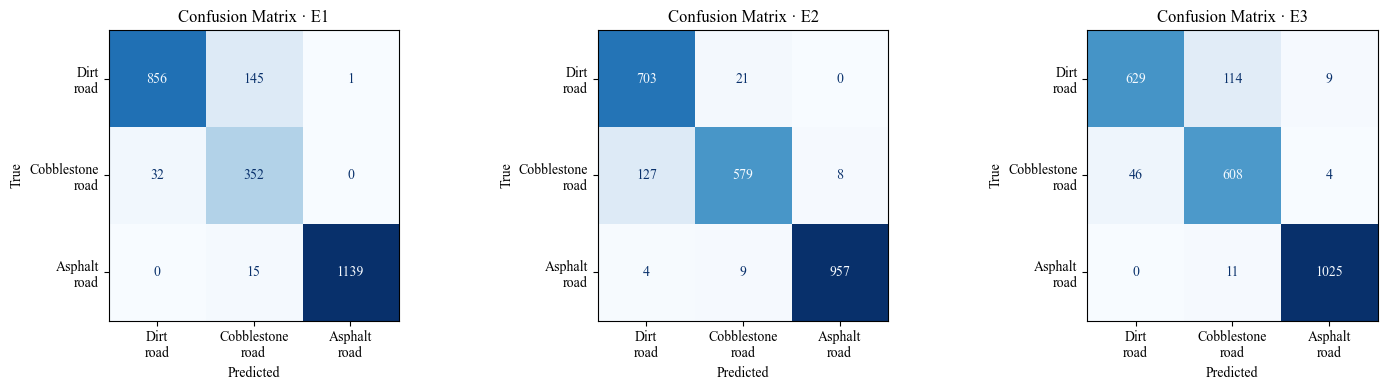

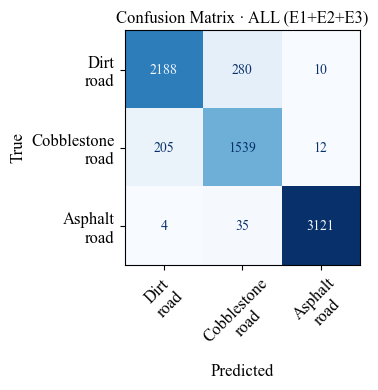

In [94]:
# Cell 11: Confusion matrices (per-exp và tổng)

LABEL_NAMES = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]
CLASS_IDS   = [0, 1, 2]

exps = ["E1", "E2", "E3"]
y_tests, y_preds = {}, {}

# Tái huấn luyện + dự đoán trên test cho từng exp để vẽ CM
for exp in exps:
    print(f"[CM] Refit & predict on {exp}")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = LGBMClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_tests[exp] = y_test
    y_preds[exp] = y_pred

# --- Hình 1: 1 hàng 3 cột (E1/E2/E3) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, exp in enumerate(exps):
    ax = axes[idx]
    cm = confusion_matrix(y_tests[exp], y_preds[exp], labels=CLASS_IDS)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix · {exp}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# --- Hình 2: Tổng (gộp E1+E2+E3) ---
y_all_true = np.concatenate([y_tests[e] for e in exps], axis=0)
y_all_pred = np.concatenate([y_preds[e] for e in exps], axis=0)
cm_all = confusion_matrix(y_all_true, y_all_pred, labels=CLASS_IDS)

fig2, ax2 = plt.subplots(1, 1, figsize=(4, 4))
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=LABEL_NAMES)
disp_all.plot(ax=ax2, values_format='d', cmap="Blues", colorbar=False)
ax2.set_title("Confusion Matrix · ALL (E1+E2+E3)")
ax2.set_xlabel("Predicted label", fontsize=12)
ax2.set_ylabel("True label", fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 12 — Classification report

In [95]:
# Cell 12: Classification reports (per-exp và tổng)

exps = ["E1", "E2", "E3"]

# for exp in exps:
#     print(f"\n===== Classification Report · {exp} =====")
#     print(classification_report(
#         y_tests[exp],
#         y_preds[exp],
#         labels=[0,1,2],
#         target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
#         digits=4
#     ))

print("\n===== Classification Report · ALL (E1+E2+E3) =====")
print(classification_report(
    y_all_true,
    y_all_pred,
    labels=[0,1,2],
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))



===== Classification Report · ALL (E1+E2+E3) =====
                  precision    recall  f1-score   support

       Dirt road     0.9128    0.8830    0.8976      2478
Cobblestone road     0.8301    0.8764    0.8526      1756
    Asphalt road     0.9930    0.9877    0.9903      3160

        accuracy                         0.9262      7394
       macro avg     0.9120    0.9157    0.9135      7394
    weighted avg     0.9274    0.9262    0.9266      7394



## Cell 13 — Huấn luyện trên toàn bộ PVS và xuất mã C

In [96]:
# Cell 13: Huấn luyện trên toàn bộ PVS và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_LGBM = LGBMClassifier(**BEST_PARAMS, random_state=42)
final_clf_LGBM.fit(X_all, y_all)

# Xuất mô hình sang header C/C++ bằng m2cgen
header_file = "m2cgen_PVS_LGBM.h"

try:
    c_cpp_code = export_to_c(final_clf_LGBM)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40290
[LightGBM] [Info] Number of data points in the train set: 7180, number of used features: 158
[LightGBM] [Info] Start training from score -1.280154
[LightGBM] [Info] Start training from score -1.231269
[LightGBM] [Info] Start training from score -0.843776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## Đo thời gian huấn luyện và dự đoán

In [8]:
clf = LGBMClassifier(n_estimators=50, max_depth=5, random_state=42, verbose=-1)

# Đo thời gian huấn luyện
start_train = time.perf_counter()
clf.fit(X_all, y_all)
end_train = time.perf_counter()
train_time = end_train - start_train

# Đo thời gian dự đoán
start_pred = time.perf_counter()
y_pred = clf.predict(X_all)
end_pred = time.perf_counter()
pred_time = end_pred - start_pred

# In kết quả
print(f"Training time: {train_time:.4f} seconds")
print(f"Prediction time: {pred_time:.4f} seconds")

# Training time: 1.8508 seconds
# Prediction time: 0.0133 seconds


Training time: 1.6964 seconds
Prediction time: 0.0094 seconds


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# 3 vị trí đồng thời - dashboard + above + below

## Cell 1 — Imports, cấu hình & định nghĩa Experiments 1–3

In [98]:
# Cell 1: Imports, constants, experiments
import os, json, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from m2cgen.exporters import export_to_c

# Thiết lập font mặc định Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Gốc thư mục PVS
BASE_DIR = r"D:\BVHoan\Spiiras Proceedings\Passive Vehicular Sensors Datasets"
PVS_FOLDERS = [os.path.join(BASE_DIR, f"PVS {i}") for i in range(1, 10)]

# Cấu hình phân đoạn
WINDOW_SIZE = 600
STRIDE = 300

# =========================
# Chọn thủ công cấu hình sensor
# =========================
# Hỗ trợ: "dashboard","above","below",
#         "dashboard+above", "dashboard+below", "above+below",
#         "dashboard+above+below"
ACTIVE_PRESET = "dashboard+above+below"  # <-- chỉnh tại đây khi muốn thử cấu hình khác

# Định nghĩa các kênh IMU cho từng vị trí (mỗi vị trí có cả L/R; tên cột giống nhau giữa left/right CSV)
DASH_IMU = [
    "acc_x_dashboard", "acc_y_dashboard", "acc_z_dashboard",
    "gyro_x_dashboard", "gyro_y_dashboard", "gyro_z_dashboard",
]
ABOVE_IMU = [
    "acc_x_above_suspension", "acc_y_above_suspension", "acc_z_above_suspension",
    "gyro_x_above_suspension", "gyro_y_above_suspension", "gyro_z_above_suspension",
]
BELOW_IMU = [
    "acc_x_below_suspension", "acc_y_below_suspension", "acc_z_below_suspension",
    "gyro_x_below_suspension", "gyro_y_below_suspension", "gyro_z_below_suspension",
]

# Bảng preset (chỉ liệt kê kênh IMU; cột speed sẽ được thêm một lần ở cuối)
SENSOR_PRESETS = {
    "dashboard": DASH_IMU,
    "above": ABOVE_IMU,
    "below": BELOW_IMU,
    "dashboard+above": DASH_IMU + ABOVE_IMU,
    "dashboard+below": DASH_IMU + BELOW_IMU,
    "above+below": ABOVE_IMU + BELOW_IMU,
    "dashboard+above+below": DASH_IMU + ABOVE_IMU + BELOW_IMU,
}

def choose_active_preset(name: str, include_speed: bool = True):
    if name not in SENSOR_PRESETS:
        raise ValueError(f"Unknown preset '{name}'. Allowed: {list(SENSOR_PRESETS.keys())}")
    cols = list(SENSOR_PRESETS[name])  # copy
    if include_speed:
        cols = cols + ["speed"]  # chỉ một cột speed dùng chung cho toàn cấu hình
    return cols

# Danh sách cột đầu vào cho run hiện tại
SENSOR_COLUMNS = choose_active_preset(ACTIVE_PRESET, include_speed=True)

print(f"✅ Using preset: {ACTIVE_PRESET}")
print(f"   → #IMU channels (không tính speed): {len(SENSOR_COLUMNS) - 1}")
print(f"   → Tổng số kênh (đã gồm speed):      {len(SENSOR_COLUMNS)}")

# Nhãn tác vụ chính (mutually exclusive)
LABEL_COLUMNS = ["dirt_road", "cobblestone_road", "asphalt_road"]

# Cấu hình chia theo Menegazzo
EXPERIMENTS = {
    1: {"train": ["PVS 1", "PVS 3", "PVS 4", "PVS 6", "PVS 7", "PVS 9"],
        "test":  ["PVS 2", "PVS 5", "PVS 8"]},
    2: {"train": ["PVS 1", "PVS 2", "PVS 3", "PVS 7", "PVS 8", "PVS 9"],
        "test":  ["PVS 4", "PVS 5", "PVS 6"]},
    3: {"train": ["PVS 1", "PVS 2", "PVS 4", "PVS 6", "PVS 8", "PVS 9"],
        "test":  ["PVS 3", "PVS 5", "PVS 7"]},
}


✅ Using preset: dashboard+above+below
   → #IMU channels (không tính speed): 18
   → Tổng số kênh (đã gồm speed):      19


## Cell 2 — I/O & kiểm tra: đọc 3 file trong 1 PVS, cửa sổ, majority label

In [99]:
# Cell 2: IO, validation, windowing, majority label

def load_pvs_triplet(pvs_dir: str):
    """
    Đọc 3 file trong một thư mục PVS:
      - dataset_gps_mpu_left.csv
      - dataset_gps_mpu_right.csv
      - dataset_labels.csv
    Trả về (left_df, right_df, labels_df) và kiểm tra cấu trúc tối thiểu
    theo cấu hình cột hiện hành (SENSOR_COLUMNS từ Cell 1).
    """
    left_path  = os.path.join(pvs_dir, "dataset_gps_mpu_left.csv")
    right_path = os.path.join(pvs_dir, "dataset_gps_mpu_right.csv")
    label_path = os.path.join(pvs_dir, "dataset_labels.csv")

    if not (os.path.exists(left_path) and os.path.exists(right_path) and os.path.exists(label_path)):
        raise FileNotFoundError(f"Missing one of required files in: {pvs_dir}")

    left_df  = pd.read_csv(left_path)
    right_df = pd.read_csv(right_path)
    labels_df= pd.read_csv(label_path)

    # Hàng phải khớp 1–1 giữa 3 file (đồng bộ theo chỉ số dòng)
    if not (len(left_df) == len(right_df) == len(labels_df)):
        raise ValueError(
            f"Row mismatch in {pvs_dir}: left={len(left_df)}, right={len(right_df)}, labels={len(labels_df)}"
        )

    # --- Kiểm tra cột theo preset hiện hành ---
    # Tất cả kênh trừ 'speed' phải có ở cả left và right.
    imu_cols = [c for c in SENSOR_COLUMNS if c != "speed"]
    missing_imu = [c for c in imu_cols if (c not in left_df.columns or c not in right_df.columns)]
    if missing_imu:
        raise KeyError(f"Missing IMU columns {missing_imu} in {pvs_dir} (left/right)")

    # 'speed' phải có ít nhất ở một trong hai file (giá trị hai phía giống nhau là mong đợi)
    if "speed" in SENSOR_COLUMNS:
        has_speed_left  = "speed" in left_df.columns
        has_speed_right = "speed" in right_df.columns
        if not (has_speed_left or has_speed_right):
            raise KeyError(f"Missing column 'speed' in {pvs_dir} (neither left nor right)")

        # Nếu có ở cả hai, kiểm tra gần như nhau (sanity check, không dừng nếu lệch rất nhỏ do làm tròn)
        if has_speed_left and has_speed_right:
            try:
                if not np.allclose(left_df["speed"].values, right_df["speed"].values, atol=1e-6, rtol=1e-6):
                    print(f"[Warn] 'speed' differs between left/right in {pvs_dir}. "
                          f"Values should be identical (GPS shared). Proceeding with files as-is.")
            except Exception:
                # Trường hợp dtype lạ hoặc NaN; chỉ cảnh báo nhẹ
                print(f"[Warn] Could not compare 'speed' columns in {pvs_dir} due to dtype/NaN issues.")

    # Cột nhãn one-hot bắt buộc
    for col in LABEL_COLUMNS:
        if col not in labels_df.columns:
            raise KeyError(f"Label column '{col}' missing in {pvs_dir}/dataset_labels.csv")

    return left_df, right_df, labels_df

def window_indices(n_samples: int, window: int, stride: int):
    """Sinh danh sách (start, end) cho các cửa sổ trượt."""
    idx = []
    start = 0
    while start + window <= n_samples:
        idx.append((start, start + window))
        start += stride
    return idx

def majority_label_onehot(block_labels, label_cols=LABEL_COLUMNS):
    """
    Lấy nhãn majority trong cửa sổ theo tổng one-hot; khi hòa,
    dùng mode() giống Menegazzo.
    """
    sums = block_labels[label_cols].sum(axis=0)
    max_sum = sums.max()
    tied = [cls for cls, val in sums.items() if val == max_sum]
    if len(tied) == 1:
        return tied[0]
    # dùng mode() giống Menegazzo
    mode_label = block_labels[label_cols].mode().iloc[0]
    for cls in label_cols:
        if mode_label[cls] == 1:
            return cls
    return tied[0]


## Cell 3 — Phân đoạn một lần duy nhất và gắn provenance PVS

In [100]:
# Cell 3: Single-pass segmentation with provenance (both sides as independent samples)

def build_windows_by_pvs(pvs_folders):
    """
    Trả về:
      windows_by_pvs = {
        'PVS 1': {'dirt_road': [np.array(WINDOW_SIZE, n_channels), ...],
                  'cobblestone_road': [...],
                  'asphalt_road': [...]},
        ...
      }
    Mỗi cửa sổ là một mẫu; left/right được coi là 2 mẫu độc lập (đúng Menegazzo).
    """
    windows_by_pvs = {}
    global_summary = Counter()

    for pvs_dir in pvs_folders:
        pvs_name = os.path.basename(pvs_dir)  # "PVS i"
        try:
            left_df, right_df, labels_df = load_pvs_triplet(pvs_dir)
        except Exception as e:
            print(f"[WARN] Skip {pvs_name}: {e}")
            continue

        # -----------------------------
        # 1) Chuẩn bị tín hiệu đầu vào
        # -----------------------------
        # Sao chép SENSOR_COLUMNS để tách speed riêng
        cols_no_speed = [c for c in SENSOR_COLUMNS if c != "speed"]
        include_speed = "speed" in SENSOR_COLUMNS

        # Các cột IMU phải có ở cả left & right
        left_sig_imu  = left_df[cols_no_speed].to_numpy(dtype=np.float32)
        right_sig_imu = right_df[cols_no_speed].to_numpy(dtype=np.float32)

        # Speed: chỉ lấy một nguồn (left ưu tiên)
        if include_speed:
            if "speed" in left_df.columns:
                speed_vec = left_df["speed"].to_numpy(dtype=np.float32)
            else:
                speed_vec = right_df["speed"].to_numpy(dtype=np.float32)
            speed_vec = speed_vec.reshape(-1, 1)
            # Ghép speed thành cột cuối
            left_sig  = np.hstack([left_sig_imu,  speed_vec])
            right_sig = np.hstack([right_sig_imu, speed_vec])
        else:
            left_sig, right_sig = left_sig_imu, right_sig_imu

        # -----------------------------
        # 2) Xử lý nhãn
        # -----------------------------
        labels_main = labels_df[LABEL_COLUMNS].astype(int)
        n = len(labels_main)
        win_idxs = window_indices(n, WINDOW_SIZE, STRIDE)
        if not win_idxs:
            print(f"[INFO] {pvs_name}: not enough samples for one window ({n} < {WINDOW_SIZE})")
            continue

        # -----------------------------
        # 3) Tạo kho lưu kết quả
        # -----------------------------
        windows_by_pvs.setdefault(pvs_name, {k: [] for k in LABEL_COLUMNS})

        # -----------------------------
        # 4) Cắt cửa sổ và gán nhãn
        # -----------------------------
        for (s, e) in win_idxs:
            cls = majority_label_onehot(labels_main.iloc[s:e], LABEL_COLUMNS)

            # Mỗi bên là một mẫu độc lập
            wL = left_sig[s:e, :]
            wR = right_sig[s:e, :]

            windows_by_pvs[pvs_name][cls].append(wL)
            windows_by_pvs[pvs_name][cls].append(wR)
            global_summary[cls] += 2

    # -----------------------------
    # 5) Log thống kê
    # -----------------------------
    print(f"=== Windows per PVS (preset: {ACTIVE_PRESET}) ===")
    for pvs_name in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
        line = [f"{cls}:{len(windows_by_pvs[pvs_name][cls])}" for cls in LABEL_COLUMNS]
        print(f"{pvs_name} -> " + " | ".join(line))

    print("\n=== Global class totals ===")
    for cls in LABEL_COLUMNS:
        print(f"{cls:17s}: {global_summary[cls]}")

    return windows_by_pvs

# Thực thi để sinh dữ liệu phân đoạn
windows_by_pvs = build_windows_by_pvs(PVS_FOLDERS)


=== Windows per PVS (preset: dashboard+above+below) ===
PVS 1 -> dirt_road:172 | cobblestone_road:412 | asphalt_road:374
PVS 2 -> dirt_road:298 | cobblestone_road:138 | asphalt_road:392
PVS 3 -> dirt_road:190 | cobblestone_road:176 | asphalt_road:336
PVS 4 -> dirt_road:160 | cobblestone_road:384 | asphalt_road:336
PVS 5 -> dirt_road:404 | cobblestone_road:120 | asphalt_road:366
PVS 6 -> dirt_road:160 | cobblestone_road:210 | asphalt_road:268
PVS 7 -> dirt_road:158 | cobblestone_road:362 | asphalt_road:334
PVS 8 -> dirt_road:300 | cobblestone_road:126 | asphalt_road:396
PVS 9 -> dirt_road:154 | cobblestone_road:168 | asphalt_road:286

=== Global class totals ===
dirt_road        : 1996
cobblestone_road : 2096
asphalt_road     : 3088


## Cell 4 — Tạo đủ 3 splits theo Menegazzo và in thống kê

In [101]:
# Cell 4: Build ALL 3 Menegazzo splits + stats

def _collect_from_pvs(pvs_list, windows_by_pvs, label_cols=LABEL_COLUMNS):
    bucket = {c: [] for c in label_cols}
    for pvs in pvs_list:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing; skipping.")
            continue
        for cls in label_cols:
            bucket[cls].extend(windows_by_pvs[pvs][cls])
    return bucket

def _print_split_stats(exp_id, split_name, lists_by_class, label_cols=LABEL_COLUMNS):
    total = sum(len(v) for v in lists_by_class.values())
    print(f"[Experiment {exp_id} · {split_name.upper()}] Total windows: {total}")
    for cls in label_cols:
        print(f"  {cls:17s}: {len(lists_by_class[cls])}")

def make_all_splits(windows_by_pvs, experiments=EXPERIMENTS):
    """
    Trả về:
      splits = {
        1: {"train": {"dirt_road":[...], ...}, "test": {...}},
        2: {...},
        3: {...}
      }
    """
    splits = {}
    for exp_id, conf in experiments.items():
        tr_pvs, te_pvs = conf["train"], conf["test"]
        train_lists = _collect_from_pvs(tr_pvs, windows_by_pvs)
        test_lists  = _collect_from_pvs(te_pvs, windows_by_pvs)

        splits[exp_id] = {"train": train_lists, "test": test_lists}

        print(f"=== Experiment {exp_id} ===")
        _print_split_stats(exp_id, "train", train_lists)
        _print_split_stats(exp_id, "test",  test_lists)

    return splits

splits = make_all_splits(windows_by_pvs)


=== Experiment 1 ===
[Experiment 1 · TRAIN] Total windows: 4640
  dirt_road        : 994
  cobblestone_road : 1712
  asphalt_road     : 1934
[Experiment 1 · TEST] Total windows: 2540
  dirt_road        : 1002
  cobblestone_road : 384
  asphalt_road     : 1154
=== Experiment 2 ===
[Experiment 2 · TRAIN] Total windows: 4772
  dirt_road        : 1272
  cobblestone_road : 1382
  asphalt_road     : 2118
[Experiment 2 · TEST] Total windows: 2408
  dirt_road        : 724
  cobblestone_road : 714
  asphalt_road     : 970
=== Experiment 3 ===
[Experiment 3 · TRAIN] Total windows: 4734
  dirt_road        : 1244
  cobblestone_road : 1438
  asphalt_road     : 2052
[Experiment 3 · TEST] Total windows: 2446
  dirt_road        : 752
  cobblestone_road : 658
  asphalt_road     : 1036


## Cell 5 — Sinh biến cho cả 3 experiment (không ghi đè nhau)

In [102]:
# Cell 5: Variables for all 3 experiments with suffixes _E1/_E2/_E3

def _vars_for_all_experiments(splits_dict):
    for exp_id in (1, 2, 3):
        sd = splits_dict[exp_id]

        globals()[f"train_dirt_road_E{exp_id}"]         = sd["train"]["dirt_road"]
        globals()[f"train_cobblestone_road_E{exp_id}"]  = sd["train"]["cobblestone_road"]
        globals()[f"train_asphalt_road_E{exp_id}"]      = sd["train"]["asphalt_road"]

        globals()[f"test_dirt_road_E{exp_id}"]          = sd["test"]["dirt_road"]
        globals()[f"test_cobblestone_road_E{exp_id}"]   = sd["test"]["cobblestone_road"]
        globals()[f"test_asphalt_road_E{exp_id}"]       = sd["test"]["asphalt_road"]

_vars_for_all_experiments(splits)

# peek a few counts so you can sanity-check at a glance
for k in ("train_dirt_road", "train_cobblestone_road", "train_asphalt_road",
          "test_dirt_road", "test_cobblestone_road", "test_asphalt_road"):
    for e in (1, 2, 3):
        v = globals()[f"{k}_E{e}"]
        print(f"{k}_E{e:1d}: {len(v)} windows")


train_dirt_road_E1: 994 windows
train_dirt_road_E2: 1272 windows
train_dirt_road_E3: 1244 windows
train_cobblestone_road_E1: 1712 windows
train_cobblestone_road_E2: 1382 windows
train_cobblestone_road_E3: 1438 windows
train_asphalt_road_E1: 1934 windows
train_asphalt_road_E2: 2118 windows
train_asphalt_road_E3: 2052 windows
test_dirt_road_E1: 1002 windows
test_dirt_road_E2: 724 windows
test_dirt_road_E3: 752 windows
test_cobblestone_road_E1: 384 windows
test_cobblestone_road_E2: 714 windows
test_cobblestone_road_E3: 658 windows
test_asphalt_road_E1: 1154 windows
test_asphalt_road_E2: 970 windows
test_asphalt_road_E3: 1036 windows


## Cell 6 — Tạo data_train/data_test + label_train/label_test cho từng experiment

In [103]:
# Cell 6: Build data_/label_ arrays for EACH experiment,
# groups cho mỗi cửa sổ (train/test) theo PVS (để dùng Group-aware CV)

def _vars_with_groups_for_experiment(exp_id):
    """
    Sinh data_/label_ + groups_ cho exp_id.
    Group = tên PVS của cửa sổ đó.
    Dùng danh sách cột linh hoạt SENSOR_COLUMNS (theo preset đã chọn).
    """
    data_train, label_train, groups_train = [], [], []

    # --- Build TRAIN ---
    for pvs in EXPERIMENTS[exp_id]["train"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TRAIN")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                # mỗi acts là np.array(window_size, n_channels)
                data_train.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_train.append(lab)
                groups_train.append(pvs)

    # --- Build TEST ---
    data_test, label_test, groups_test = [], [], []
    for pvs in EXPERIMENTS[exp_id]["test"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TEST")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                data_test.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_test.append(lab)
                groups_test.append(pvs)

    # --- Lưu vào biến toàn cục ---
    globals()[f"data_train_E{exp_id}"]   = data_train
    globals()[f"label_train_E{exp_id}"]  = label_train
    globals()[f"groups_train_E{exp_id}"] = groups_train

    globals()[f"data_test_E{exp_id}"]    = data_test
    globals()[f"label_test_E{exp_id}"]   = label_test
    globals()[f"groups_test_E{exp_id}"]  = groups_test

# Rebuild để có groups (E1–E3)
_vars_with_groups_for_experiment(1)
_vars_with_groups_for_experiment(2)
_vars_with_groups_for_experiment(3)

print("E1:", len(data_train_E1), "train /", len(data_test_E1), "test | #groups(train) =", len(set(groups_train_E1)))
print("E2:", len(data_train_E2), "train /", len(data_test_E2), "test | #groups(train) =", len(set(groups_train_E2)))
print("E3:", len(data_train_E3), "train /", len(data_test_E3), "test | #groups(train) =", len(set(groups_train_E3)))


E1: 4640 train / 2540 test | #groups(train) = 6
E2: 4772 train / 2408 test | #groups(train) = 6
E3: 4734 train / 2446 test | #groups(train) = 6


## Cell 7 — Feature extraction

In [104]:
# # Cell 7: Trích xuất đặc trưng

# def featuresFromBuffer(at):
#     feat = np.zeros(236, dtype=np.float32)
    
#     # ---- DASHBOARD ----
#     ax_dashboard = np.array(at['acc_x_dashboard'],  dtype=np.float32)
#     ay_dashboard = np.array(at['acc_y_dashboard'],  dtype=np.float32)
#     az_dashboard = np.array(at['acc_z_dashboard'],  dtype=np.float32)
#     gx_dashboard = np.array(at['gyro_x_dashboard'], dtype=np.float32)
#     gy_dashboard = np.array(at['gyro_y_dashboard'], dtype=np.float32)
#     gz_dashboard = np.array(at['gyro_z_dashboard'], dtype=np.float32)
    
#     # ---- ABOVE ----
#     ax_above = np.array(at['acc_x_above_suspension'],  dtype=np.float32)
#     ay_above = np.array(at['acc_y_above_suspension'],  dtype=np.float32)
#     az_above = np.array(at['acc_z_above_suspension'],  dtype=np.float32)
#     gx_above = np.array(at['gyro_x_above_suspension'], dtype=np.float32)
#     gy_above = np.array(at['gyro_y_above_suspension'], dtype=np.float32)
#     gz_above = np.array(at['gyro_z_above_suspension'], dtype=np.float32)
    
#     # ---- BELOW ----
#     ax_below = np.array(at['acc_x_below_suspension'],  dtype=np.float32)
#     ay_below = np.array(at['acc_y_below_suspension'],  dtype=np.float32)
#     az_below = np.array(at['acc_z_below_suspension'],  dtype=np.float32)
#     gx_below = np.array(at['gyro_x_below_suspension'], dtype=np.float32)
#     gy_below = np.array(at['gyro_y_below_suspension'], dtype=np.float32)
#     gz_below = np.array(at['gyro_z_below_suspension'], dtype=np.float32)    
    
#     # ---- SPEED (chung) ----
#     sp = np.array(at['speed'], dtype=np.float32)
    
#     # Đặc trưng thống kê
#     feat[0:19] = [np.mean(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below,
#                                        sp]] # mean
#     feat[19:38] = [np.std(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below,
#                                        sp]] # sd
#     feat[38:56] = [np.sqrt(np.mean(i**2)) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                     gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # rms
#     feat[56:74] = [np.max(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # max
#     feat[74:92] = [np.min(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # min
#     feat[92:110] = [np.amax(i) - np.amin(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                       gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # range
#     feat[110:128] = [np.median(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                             gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # median
#     feat[128:146] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                                            gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # interquartile range
#     feat[146:164] = [skew(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # skewness
#     feat[164:182] = [kurtosis(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                            gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # kurtosis
#     feat[182:200] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # hjorth mobility
#     feat[200:218] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                                                                                                      gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # hjorth complexity
#     feat[218:236] = [acf(i, nlags=1)[1] for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                   gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # autocorrelation
        
#     return feat

# # Trích xuất đặc trưng cho từng cửa sổ
# train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
# test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
# train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
# test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
# train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
# test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

# # Ép sang numpy array
# train_features_E1 = np.array(train_features_E1, dtype=np.float32)
# test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
# train_features_E2 = np.array(train_features_E2, dtype=np.float32)
# test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
# train_features_E3 = np.array(train_features_E3, dtype=np.float32)
# test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

# print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
# print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
# print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
# print('Feature dimension:', train_features_E1.shape[1])

# # Gom toàn bộ dữ liệu từ PVS 1..9 (tránh dùng E1/E2/E3 để không đếm trùng)
# cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
# X_all, y_all = [], []

# # Đảm bảo thứ tự PVS 1..9 ổn định
# for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#     for cls_name, cls_id in cls_map:
#         for buf in windows_by_pvs[pvs][cls_name]:
#             # buf là ndarray (WINDOW_SIZE x len(SENSOR_COLUMNS))
#             at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#             feat = featuresFromBuffer(at)
#             X_all.append(feat)
#             y_all.append(cls_id)

# X_all = np.asarray(X_all, dtype=np.float32)
# y_all = np.asarray(y_all, dtype=np.int32)
# print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))


## Cell 7A — Tính & Lưu cache

In [105]:
# # Cell 7A: Compute & cache features for the current ACTIVE_PRESET

# def _extract_features_for_splits():
#     # y nguyên format Cell 7: tạo các mảng đặc trưng cho E1/E2/E3
#     train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
#     test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
#     train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
#     test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
#     train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
#     test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

#     # Ép sang numpy array
#     train_features_E1 = np.array(train_features_E1, dtype=np.float32)
#     test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
#     train_features_E2 = np.array(train_features_E2, dtype=np.float32)
#     test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
#     train_features_E3 = np.array(train_features_E3, dtype=np.float32)
#     test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

#     return (train_features_E1, test_features_E1,
#             train_features_E2, test_features_E2,
#             train_features_E3, test_features_E3)

# def _extract_features_all_pvs():
#     # Y nguyên logic gom ALL PVS (tránh đếm trùng E1/E2/E3)
#     cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
#     X_all, y_all = [], []

#     for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#         for cls_name, cls_id in cls_map:
#             for buf in windows_by_pvs[pvs][cls_name]:
#                 at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#                 feat = featuresFromBuffer(at)
#                 X_all.append(feat)
#                 y_all.append(cls_id)

#     X_all = np.asarray(X_all, dtype=np.float32)
#     y_all = np.asarray(y_all, dtype=np.int32)
#     return X_all, y_all

# def _save_feature_cache(fname,
#                         train_features_E1, test_features_E1,
#                         train_features_E2, test_features_E2,
#                         train_features_E3, test_features_E3,
#                         X_all, y_all):
#     # Lưu gọn bằng NPZ nén
#     np.savez_compressed(
#         fname,
#         ACTIVE_PRESET=np.array([ACTIVE_PRESET]),
#         SENSOR_COLUMNS=np.array(SENSOR_COLUMNS),
#         WINDOW_SIZE=np.array([WINDOW_SIZE], dtype=np.int32),
#         STRIDE=np.array([STRIDE], dtype=np.int32),
#         LABEL_COLUMNS=np.array(LABEL_COLUMNS),

#         train_features_E1=train_features_E1,
#         test_features_E1=test_features_E1,
#         train_features_E2=train_features_E2,
#         test_features_E2=test_features_E2,
#         train_features_E3=train_features_E3,
#         test_features_E3=test_features_E3,

#         X_all=X_all,
#         y_all=y_all
#     )

# # ---- Thực thi: tính & lưu ----
# cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
# print(f"⏳ Computing features for preset: {ACTIVE_PRESET} ...")

# (train_features_E1, test_features_E1,
#  train_features_E2, test_features_E2,
#  train_features_E3, test_features_E3) = _extract_features_for_splits()

# print("   • Splits done:",
#       f"E1: {train_features_E1.shape} / {test_features_E1.shape} |",
#       f"E2: {train_features_E2.shape} / {test_features_E2.shape} |",
#       f"E3: {train_features_E3.shape} / {test_features_E3.shape}")

# X_all, y_all = _extract_features_all_pvs()
# print("   • ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))

# _save_feature_cache(cache_name,
#                     train_features_E1, test_features_E1,
#                     train_features_E2, test_features_E2,
#                     train_features_E3, test_features_E3,
#                     X_all, y_all)

# size_bytes = os.path.getsize(cache_name)
# print(f"✅ Saved cache to '{cache_name}' ({size_bytes/1024/1024:.3f} MB)")


## Cell 7B — Nạp cache (dùng cho chạy nhanh về sau)

In [106]:
# Cell 7B: Load cached feature set for the current ACTIVE_PRESET

cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
if not os.path.exists(cache_name):
    raise FileNotFoundError(f"Feature cache not found: {cache_name}. Hãy chạy Cell 7A trước để tạo cache.")

data = np.load(cache_name, allow_pickle=True)

# Khôi phục biến đúng tên như Cell 7 gốc
train_features_E1 = data["train_features_E1"]
test_features_E1  = data["test_features_E1"]
train_features_E2 = data["train_features_E2"]
test_features_E2  = data["test_features_E2"]
train_features_E3 = data["train_features_E3"]
test_features_E3  = data["test_features_E3"]

X_all = data["X_all"]
y_all = data["y_all"]

# (tuỳ chọn) kiểm tra meta để cảnh báo nếu lệch preset
_cached_preset = str(data["ACTIVE_PRESET"][0])
if _cached_preset != ACTIVE_PRESET:
    print(f"[WARN] Cache preset = '{_cached_preset}' khác với ACTIVE_PRESET hiện tại = '{ACTIVE_PRESET}'")

# In thống kê giống Cell 7 gốc
print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
print('Feature dimension:', train_features_E1.shape[1])
print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))
print(f"✅ Loaded cache from '{cache_name}'")


E1: 4640 train samples / 2540 test samples
E2: 4772 train samples / 2408 test samples
E3: 4734 train samples / 2446 test samples
Feature dimension: 236
ALL PVS: (7180, 236) | class dist: [1996 2096 3088]
✅ Loaded cache from 'feature_set_dashboard+above+below.npz'


## Cell 8 — Find candidates

In [107]:
# Cell 8: Find candidates, LOGO trên 3 experiment → lấy 3 bộ tham số ứng viên (Accuracy), kèm kiểm tra model size ≤ 1.00 MB
print(f"✅ Using preset: {ACTIVE_PRESET}")

# Định nghĩa grid riêng cho từng exp
param_grids = {
    "E1": {
        "n_estimators": list(range(50, 51)),
        "max_depth": list(range(10, 12))
    },
    "E2": {
        "n_estimators": list(range(47, 51)),
        "max_depth": list(range(10, 12))
    },
    "E3": {
        "n_estimators": list(range(45, 46)),
        "max_depth": list(range(9, 10))
    }
}

# ---------------------- HÀM ĐO SIZE ----------------------
def measure_model_size_mb(params, X_full, y_full):
    """
    Train LGBMClassifier trên toàn bộ dữ liệu với 'params',
    export C/C++ header bằng m2cgen.exporters.export_to_c() rồi đo kích thước (MB).
    Trả về (size_mb, error_msg, c_code).
    """
    clf = LGBMClassifier(**params, random_state=42)
    clf.fit(X_full, y_full)

    tmp_header = None
    c_code = None
    err = ""
    size_mb = None
    try:
        c_code = export_to_c(clf)
        with tempfile.NamedTemporaryFile(mode="w", suffix=".h", delete=False, encoding="utf-8") as f:
            tmp_header = f.name
            f.write(c_code)

        size_bytes = os.path.getsize(tmp_header)
        size_mb = size_bytes / (1024 * 1024)
    except Exception as e:
        err = str(e)
    finally:
        if tmp_header and os.path.exists(tmp_header):
            os.remove(tmp_header)

    return size_mb, err, c_code

# ---------------------- HÀM LOGO + GRIDSEARCH CHO 1 EXP ----------------------
def run_logo_for_experiment(exp_name, X_train, y_train, groups, X_full_for_size, y_full_for_size,
                            param_grid, size_limit_mb=1.00):
    """
    - Chạy GridSearchCV với LOGO (Accuracy) trên (X_train, y_train, groups).
    - Với từng bộ params trong kết quả, train lại trên toàn bộ PVS 1–9 để đo size.
    - Chọn bộ params có:
        * size ≤ size_limit_mb
        * điểm cv (mean test Accuracy) cao nhất
      Tie-break: model nhỏ hơn → depth thấp hơn → số cây ít hơn.
    - Trả về dict ứng viên cho exp này.
    """
    print(f"\n===== EXP {exp_name}: START LOGO GRID (Accuracy) + SIZE CHECK ≤ {size_limit_mb:.2f} MB =====")
    logo = LeaveOneGroupOut()
    gs = GridSearchCV(
        estimator=LGBMClassifier(random_state=42),
        param_grid=param_grid,
        cv=logo.split(X_train, y_train, groups=groups),
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    best_cv = -np.inf
    best = None

    for i, params in enumerate(gs.cv_results_["params"], 1):
        cv_mean = gs.cv_results_["mean_test_score"][i-1]
        print(f"[{exp_name}] Check {i}/{len(gs.cv_results_['params'])}: {params} | CV Accuracy={cv_mean*100:.2f}")

        size_mb, err, _ = measure_model_size_mb(params, X_full_for_size, y_full_for_size)
        status = "ok"
        if err:
            status = f"error: {err}"
        elif size_mb is None:
            status = "error: size_none"
        elif size_mb > size_limit_mb:
            status = "oversize"

        print(f"   -> size={None if size_mb is None else f'{size_mb:.3f} MB'} | status={status}")

        if status == "ok":
            # update theo tiêu chí: cv cao nhất → size nhỏ hơn → depth thấp hơn → n_estimators ít hơn
            if (cv_mean > best_cv or
                (np.isclose(cv_mean, best_cv) and size_mb < best["size_mb"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] < best["params"]["max_depth"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] == best["params"]["max_depth"] and params["n_estimators"] < best["params"]["n_estimators"])
               ):
                best_cv = cv_mean
                best = {
                    "exp": exp_name,
                    "params": dict(params),
                    "cv_accuracy": float(cv_mean),
                    "size_mb": float(size_mb)
                }

    if best is None:
        best = {
            "exp": exp_name,
            "params": None,
            "cv_accuracy": None,
            "size_mb": None,
            "note": f"No feasible params ≤ {size_limit_mb:.2f} MB (or export error)"
        }
        print(f"[{exp_name}] WARNING: Không tìm thấy cấu hình khả thi (≤ {size_limit_mb:.2f} MB).")

    print(f"[{exp_name}] BEST CANDIDATE:", best)
    return best

candidates = []
candidates.append(run_logo_for_experiment("E1", train_features_E1, label_train_E1, groups_train_E1, X_all, y_all, param_grids["E1"]))
candidates.append(run_logo_for_experiment("E2", train_features_E2, label_train_E2, groups_train_E2, X_all, y_all, param_grids["E2"]))
candidates.append(run_logo_for_experiment("E3", train_features_E3, label_train_E3, groups_train_E3, X_all, y_all, param_grids["E3"]))

print("\n===== 3 ỨNG VIÊN LOGO (Accuracy, size≤1.00MB) =====")
for c in candidates:
    print(c)

# Lưu lại để dùng cho bước “chốt cuối”
with open("logo_candidates_LGBM.json", "w", encoding="utf-8") as f:
    json.dump(candidates, f, indent=2, ensure_ascii=False)

print("Đã lưu 3 ứng viên vào 'logo_candidates_LGBM.json'.")


✅ Using preset: dashboard+above+below

===== EXP E1: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 236
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[E1] Check 1/2: {'max_depth': 10, 'n_estimators': 50} | CV Accuracy=90.37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train

In [108]:
# mean, sd, rms, max, min, range, median, iqr, skew, kurt, hm, hc, acf
# {'exp': 'E1', 'params': {'max_depth': 10, 'n_estimators': 50}, 'cv_accuracy': 0.9037, 'size_mb': 0.792} -> 91.74 Borda rank, Minimax regret, Mean - λ·Std
# {'exp': 'E2', 'params': {'max_depth': 10, 'n_estimators': 47}, 'cv_accuracy': 0.9258, 'size_mb': 0.745} -> 91.74
# {'exp': 'E3', 'params': {'max_depth': 09, 'n_estimators': 45}, 'cv_accuracy': 0.8945, 'size_mb': 0.702} -> 91.55 Maximin

## Cell 9 — Select candidates

In [109]:
# Cell 9: Select candidates, thử 4 tiêu chí trên bộ ba ứng viên (train-only, LOGO)

# ========= NẠP 3 ỨNG VIÊN =========
with open("logo_candidates_LGBM.json", "r", encoding="utf-8") as f:
    candidates = json.load(f)

# Đặt tên ngắn gọn cho ứng viên theo exp gốc của nó: 'cand_E1', 'cand_E2', 'cand_E3'
for c in candidates:
    c["name"] = f"cand_{c['exp']}"

# ========= CHUẨN BỊ DỮ LIỆU TRAIN+GROUPS CHO 3 EXP =========
X_train_dict = {
    "E1": train_features_E1,
    "E2": train_features_E2,
    "E3": train_features_E3,
}
y_train_dict = {
    "E1": np.asarray(label_train_E1),
    "E2": np.asarray(label_train_E2),
    "E3": np.asarray(label_train_E3),
}
groups_dict = {
    "E1": np.asarray(groups_train_E1),
    "E2": np.asarray(groups_train_E2),
    "E3": np.asarray(groups_train_E3),
}

# ========= HÀM LOGO SCORE (Accuracy, train-only) =========
def logo_cv_accuracy_for_exp(params, X, y, groups):
    """
    Cố định bộ tham số 'params' => chạy LOGO trên (X,y,groups) => trả về mean Accuracy.
    """
    logo = LeaveOneGroupOut()
    f1s = []
    # Duyệt từng split LOGO
    for tr_idx, va_idx in logo.split(X, y, groups=groups):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        clf = LGBMClassifier(**params, random_state=42)
        clf.fit(X_tr, y_tr)
        y_hat = clf.predict(X_va)
        f1s.append(accuracy_score(y_va, y_hat))
    return float(np.mean(f1s))

# ========= TÍNH MA TRẬN ĐIỂM S_k(h) (k ∈ {E1,E2,E3}, h ∈ 3 ứng viên) =========
exps = ["E1", "E2", "E3"]
H = len(candidates)
K = len(exps)

scores = np.zeros((H, K), dtype=float)  # S[h,k] = Accuracy của ứng viên h trên exp k
for h, cand in enumerate(candidates):
    params = cand["params"]
    print(f"\n>>> Scoring {cand['name']} with params={params}")
    for k, ek in enumerate(exps):
        S_hk = logo_cv_accuracy_for_exp(params, X_train_dict[ek], y_train_dict[ek], groups_dict[ek])
        scores[h, k] = S_hk
        print(f"   {ek}: Accuracy(LOGO) = {S_hk*100:.2f}")

# ========= TIỆN ÍCH: TIE-BREAK =========
def tie_break_key(h):
    # size nhỏ hơn → depth nhỏ hơn → n_estimators ít hơn
    size = candidates[h].get("size_mb", np.inf)
    depth = candidates[h]["params"]["max_depth"]
    trees = candidates[h]["params"]["n_estimators"]
    return (size, depth, trees)

# ========= 1) MAXIMIN =========
worst_case = scores.min(axis=1)             # min_k S_k(h)
best_h_maximin = max(range(H), key=lambda h: (worst_case[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= 2) BORDA RANK =========
def ranks_desc(vals):
    """
    Trả về rank (1 = tốt nhất) theo thứ tự giảm dần của vals.
    Ties => average-rank.
    """
    vals = np.asarray(vals)
    # sắp xếp giảm dần
    order = np.argsort(-vals)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(vals) + 1, dtype=float)
    # xử lý ties (average rank)
    for v in np.unique(vals):
        idx = np.where(vals == v)[0]
        if len(idx) > 1:
            avg = ranks[idx].mean()
            ranks[idx] = avg
    return ranks

borda = np.zeros(H, dtype=float)
for k in range(K):
    borda += ranks_desc(scores[:, k])
best_h_borda = min(range(H), key=lambda h: (borda[h], tie_break_key(h)))

# ========= 3) MINIMAX REGRET =========
best_per_exp = scores.max(axis=0)           # S*_k
regret = best_per_exp - scores              # Reg_k(h) = S*_k - S_k(h)
max_regret = regret.max(axis=1)             # max_k Reg_k(h)
best_h_regret = min(range(H), key=lambda h: (max_regret[h], tie_break_key(h)))

# ========= 4) MEAN − λ·STD (λ suy từ dữ liệu) =========
means = scores.mean(axis=1)
stds  = scores.std(axis=1, ddof=0)

sigma_typ = float(np.median(stds))
c_pp = 0.01  # 1.0 điểm phần trăm F1  => 0.01 theo thang [0,1]
# Nếu bạn thích 0.5–1.5 pp, đổi c_pp = 0.005 ~ 0.015
if sigma_typ > 0:
    lam = c_pp / sigma_typ
else:
    lam = 0.1
lam = float(np.clip(lam, 0.1, 1.0))

risk_adj = means - lam * stds
best_h_mean_std = max(range(H), key=lambda h: (risk_adj[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= IN KẾT QUẢ =========
def pretty_candidate(h):
    c = candidates[h]
    return {
        "name": c["name"],
        "params": c["params"],
        "size_mb": round(float(c.get("size_mb", np.nan)), 3),
        "S_E1": round(scores[h,0]*100, 2),
        "S_E2": round(scores[h,1]*100, 2),
        "S_E3": round(scores[h,2]*100, 2),
        "mean": round(means[h]*100, 2),
        "std": round(stds[h], 2)
    }

print("\n===== SCORE MATRIX (Accuracy, train-only LOGO) =====")
for h in range(H):
    print(pretty_candidate(h))

print("\n===== SELECTIONS (4 tiêu chí) =====")
print(f"Maximin         -> {pretty_candidate(best_h_maximin)}")
print(f"Borda rank      -> {pretty_candidate(best_h_borda)}")
print(f"Minimax regret  -> {pretty_candidate(best_h_regret)}")
print(f"Mean - λ·Std    -> {pretty_candidate(best_h_mean_std)}  (λ = {lam:.4f}, c_pp={c_pp})")



>>> Scoring cand_E1 with params={'max_depth': 10, 'n_estimators': 50}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 236
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3938, number of used features: 236
[LightGBM] [Info] Start training from score -1.588829
[LightGBM] [Info] Start training from score -0.941491
[LightGBM] [Info] Start training from score -0.901920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 236
[LightGBM] [Info] Start training from score -1.505941
[LightGBM] [Info] Start training from score -1.040745
[LightGBM] [Info] Start training from score -0.855666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4002, number of used features: 236
[LightGBM] [Info] Start training from score -1.568316
[LightGBM] [Info] Start training from score -0.979997
[LightGBM] [Info] Start training from score -0.876369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3786, number of used features: 236
[LightGBM] [Info] Start training from score -1.510437
[LightGBM] [Info] Start training from score -1.031205
[LightGBM] [Info] Start training from score -0.861306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4032, number of used features: 236
[LightGBM] [Info] Start training from score -1.568616
[LightGBM] [Info] Start training from score -0.959886
[LightGBM] [Info] Start training from score -0.894700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E1: Accuracy(LOGO) = 90.37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3814, number of used features: 236
[LightGBM] [Info] Start training from score -1.243368
[LightGBM] [Info] Start training from score -1.369138
[LightGBM] [Info] Start training from score -0.782497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 236
[LightGBM] [Info] Start training from score -1.398539
[LightGBM] [Info] Start training from score -1.153863
[LightGBM] [Info] Start training from score -0.826389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4070, number of used features: 236
[LightGBM] [Info] Start training from score -1.324832
[LightGBM] [Info] Start training from score -1.216334
[LightGBM] [Info] Start training from score -0.825907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 236
[LightGBM] [Info] Start training from score -1.257624
[LightGBM] [Info] Start training from score -1.345779
[LightGBM] [Info] Start training from score -0.786723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 236
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4164, number of used features: 236
[LightGBM] [Info] Start training from score -1.314935
[LightGBM] [Info] Start training from score -1.232555
[LightGBM] [Info] Start training from score -0.821068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E2: Accuracy(LOGO) = 92.57
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 236
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3906, number of used features: 236
[LightGBM] [Info] Start training from score -1.418027
[LightGBM] [Info] Start training from score -1.100150
[LightGBM] [Info] Start training from score -0.855696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3854, number of used features: 236
[LightGBM] [Info] Start training from score -1.268454
[LightGBM] [Info] Start training from score -1.296519
[LightGBM] [Info] Start training from score -0.809116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 236
[LightGBM] [Info] Start training from score -1.329353
[LightGBM] [Info] Start training from score -1.204624
[LightGBM] [Info] Start training from score -0.831153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 236
[LightGBM] [Info] Start training from score -1.421678
[LightGBM] [Info] Start training from score -1.092496
[LightGBM] [Info] Start training from score -0.859644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4126, number of used features: 236
[LightGBM] [Info] Start training from score -1.331131
[LightGBM] [Info] Start training from score -1.178292
[LightGBM] [Info] Start training from score -0.848591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E3: Accuracy(LOGO) = 89.14

>>> Scoring cand_E2 with params={'max_depth': 10, 'n_estimators': 47}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 236
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3938, number of used features: 236
[LightGBM] [Info] Start training from score -1.588829
[LightGBM] [Info] Start training from score -0.941491
[LightGBM] [Info] Start training from score -0.901920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 236
[LightGBM] [Info] Start training from score -1.505941
[LightGBM] [Info] Start training from score -1.040745
[LightGBM] [Info] Start training from score -0.855666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4002, number of used features: 236
[LightGBM] [Info] Start training from score -1.568316
[LightGBM] [Info] Start training from score -0.979997
[LightGBM] [Info] Start training from score -0.876369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3786, number of used features: 236
[LightGBM] [Info] Start training from score -1.510437
[LightGBM] [Info] Start training from score -1.031205
[LightGBM] [Info] Start training from score -0.861306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4032, number of used features: 236
[LightGBM] [Info] Start training from score -1.568616
[LightGBM] [Info] Start training from score -0.959886
[LightGBM] [Info] Start training from score -0.894700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E1: Accuracy(LOGO) = 90.21
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3814, number of used features: 236
[LightGBM] [Info] Start training from score -1.243368
[LightGBM] [Info] Start training from score -1.369138
[LightGBM] [Info] Start training from score -0.782497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 236
[LightGBM] [Info] Start training from score -1.398539
[LightGBM] [Info] Start training from score -1.153863
[LightGBM] [Info] Start training from score -0.826389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4070, number of used features: 236
[LightGBM] [Info] Start training from score -1.324832
[LightGBM] [Info] Start training from score -1.216334
[LightGBM] [Info] Start training from score -0.825907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 236
[LightGBM] [Info] Start training from score -1.257624
[LightGBM] [Info] Start training from score -1.345779
[LightGBM] [Info] Start training from score -0.786723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 236
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4164, number of used features: 236
[LightGBM] [Info] Start training from score -1.314935
[LightGBM] [Info] Start training from score -1.232555
[LightGBM] [Info] Start training from score -0.821068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E2: Accuracy(LOGO) = 92.58
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 236
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3906, number of used features: 236
[LightGBM] [Info] Start training from score -1.418027
[LightGBM] [Info] Start training from score -1.100150
[LightGBM] [Info] Start training from score -0.855696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3854, number of used features: 236
[LightGBM] [Info] Start training from score -1.268454
[LightGBM] [Info] Start training from score -1.296519
[LightGBM] [Info] Start training from score -0.809116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 236
[LightGBM] [Info] Start training from score -1.329353
[LightGBM] [Info] Start training from score -1.204624
[LightGBM] [Info] Start training from score -0.831153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 236
[LightGBM] [Info] Start training from score -1.421678
[LightGBM] [Info] Start training from score -1.092496
[LightGBM] [Info] Start training from score -0.859644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4126, number of used features: 236
[LightGBM] [Info] Start training from score -1.331131
[LightGBM] [Info] Start training from score -1.178292
[LightGBM] [Info] Start training from score -0.848591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E3: Accuracy(LOGO) = 89.02

>>> Scoring cand_E3 with params={'max_depth': 9, 'n_estimators': 45}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3682, number of used features: 236
[LightGBM] [Info] Start training from score -1.499471
[LightGBM] [Info] Start training from score -1.041092
[LightGBM] [Info] Start training from score -0.858770
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3938, number of used features: 236
[LightGBM] [Info] Start training from score -1.588829
[LightGBM] [Info] Start training from score -0.941491
[LightGBM] [Info] Start training from score -0.901920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 236
[LightGBM] [Info] Start training from score -1.505941
[LightGBM] [Info] Start training from score -1.040745
[LightGBM] [Info] Start training from score -0.855666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4002, number of used features: 236
[LightGBM] [Info] Start training from score -1.568316
[LightGBM] [Info] Start training from score -0.979997
[LightGBM] [Info] Start training from score -0.876369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3786, number of used features: 236
[LightGBM] [Info] Start training from score -1.510437
[LightGBM] [Info] Start training from score -1.031205
[LightGBM] [Info] Start training from score -0.861306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4032, number of used features: 236
[LightGBM] [Info] Start training from score -1.568616
[LightGBM] [Info] Start training from score -0.959886
[LightGBM] [Info] Start training from score -0.894700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E1: Accuracy(LOGO) = 89.64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007476 seconds.
You can set `force_col_wise=true` to re

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 236
[LightGBM] [Info] Start training from score -1.398539
[LightGBM] [Info] Start training from score -1.153863
[LightGBM] [Info] Start training from score -0.826389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4070, number of used features: 236
[LightGBM] [Info] Start training from score -1.324832
[LightGBM] [Info] Start training from score -1.216334
[LightGBM] [Info] Start training from score -0.825907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the trai

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 236
[LightGBM] [Info] Start training from score -1.402115
[LightGBM] [Info] Start training from score -1.145784
[LightGBM] [Info] Start training from score -0.830229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4164, number of used features: 236
[LightGBM] [Info] Start training from score -1.314935
[LightGBM] [Info] Start training from score -1.232555
[LightGBM] [Info] Start training from score -0.821068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   E2: Accuracy(LOGO) = 92.15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 236
[LightGBM] [Info] Start training from score -1.259139
[LightGBM] [Info] Start training from score -1.302998
[LightGBM] [Info] Start training from score -0.811063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3906, number of used features: 236
[LightGBM] [Info] Start training from score -1.418027
[LightGBM] [Info] Start training from score -1.100150
[LightGBM] [Info] Start training from score -0.855696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3854, number of used features: 236
[LightGBM] [Info] Start training from score -1.268454
[LightGBM] [Info] Start training from score -1.296519
[LightGBM] [Info] Start training from score -0.809116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 236
[LightGBM] [Info] Start training from score -1.329353
[LightGBM] [Info] Start training from score -1.204624
[LightGBM] [Info] Start training from score -0.831153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 236
[LightGBM] [Info] Start training from score -1.421678
[LightGBM] [Info] Start training from score -1.092496
[LightGBM] [Info] Start training from score -0.859644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   E3: Accuracy(LOGO) = 89.45

===== SCORE MATRIX (Accuracy, train-only LOGO) =====
{'name': 'cand_E1', 'params': {'max_depth': 10, 'n_estimators': 50}, 'size_mb': 0.793, 'S_E1': np.float64(90.37), 'S_E2': np.float64(92.57), 'S_E3': np.float64(89.14), 'mean': np.float64(90.69), 'std': np.float64(0.01)}
{'name': 'cand_E2', 'params': {'max_depth': 10, 'n_estimators': 47}, 'size_mb': 0.745, 'S_E1': np.float64(90.21), 'S_E2': np.float64(92.58), 'S_E3': np.float64(89.02), 'mean': np.float64(90.6), 'std': np.float64(0.01)}
{'name': 'cand_E3', 'params': {'max_depth': 9, 'n_estimators': 45}, 'size_mb': 0.702, 'S_E1': np.float64(89.64), 'S_E2': np.float64(92.15), 'S_E3': np.float64(89.45), 'mean': np.float64(90.41), 'std': np.float64(0.01)}

===== SELECTIONS (4 tiêu chí) =====
Maximin         -> {'name': 'cand_E3', 'params': {'max_depth': 9, 'n_es

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Cell 10 — Đánh giá độc lập trên test_E1/E2/E3

In [110]:
# Cell 10: Đánh giá độc lập trên test_E1/E2/E3

BEST_PARAMS = {"max_depth": 10, "n_estimators": 50}

exps = ["E1", "E2", "E3"]
train_results = []
test_results  = []

for exp in exps:
    print(f"\n===== Evaluation on {exp} =====")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = LGBMClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)

    # --- TRAINING (Menegazzo: "Training") ---
    y_pred_tr = clf.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)

    # --- TESTING (Menegazzo: "Validation") ---
    y_pred_te = clf.predict(X_test)
    acc_te = accuracy_score(y_test, y_pred_te)

    print(f"Training   -> Acc = {acc_tr*100:6.2f}")
    print(f"Validation -> Acc = {acc_te*100:6.2f}")

    train_results.append({"exp": exp, "acc": acc_tr})
    test_results.append( {"exp": exp, "acc": acc_te})

# ----- Tổng hợp kiểu Menegazzo -----
def _summarize(rows, key):
    vals = [r[key] for r in rows]
    return np.mean(vals), np.std(vals)

m_acc_tr, s_acc_tr = _summarize(train_results, "acc")
m_acc_te, s_acc_te = _summarize(test_results, "acc")

print("\n===== FINAL SUMMARY =====")
print(f"[Training]    Accuracy    : {m_acc_tr*100:.2f} ± {s_acc_tr*100:.2f}")
print(f"[Validation]  Accuracy    : {m_acc_te*100:.2f} ± {s_acc_te*100:.2f}")



===== Evaluation on E1 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 236
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training   -> Acc = 100.00
Validation -> Acc =  92.91

===== Evaluation on E2 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 236
[LightGBM] [Info] Start training from score -1.322175
[LightGBM] [Info] Start training from score -1.239234
[LightGBM] [Info] Start training from score -0.812293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training   -> Acc = 100.00
Validation -> Acc =  89.99

===== Evaluation on E3 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 236
[LightGBM] [Info] Start training from score -1.336439
[LightGBM] [Info] Start training from score -1.191517
[LightGBM] [Info] Start training from score -0.835956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training   -> Acc = 100.00
Validation -> Acc =  92.31

===== FINAL SUMMARY =====
[Training]    Accuracy    : 100.00 ± 0.00
[Validation]  Accuracy    : 91.74 ± 1.26


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Cell 11 — Confusion matrix

[CM] Refit & predict on E1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4640, number of used features: 236
[LightGBM] [Info] Start training from score -1.540732
[LightGBM] [Info] Start training from score -0.997052
[LightGBM] [Info] Start training from score -0.875124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CM] Refit & predict on E2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 236
[LightGBM] [Info] Start training from score -1.322175
[LightGBM] [Info] Start training from score -1.239234
[LightGBM] [Info] Start training from score -0.812293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CM] Refit & predict on E3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 236
[LightGBM] [Info] Start training from score -1.336439
[LightGBM] [Info] Start training from score -1.191517
[LightGBM] [Info] Start training from score -0.835956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


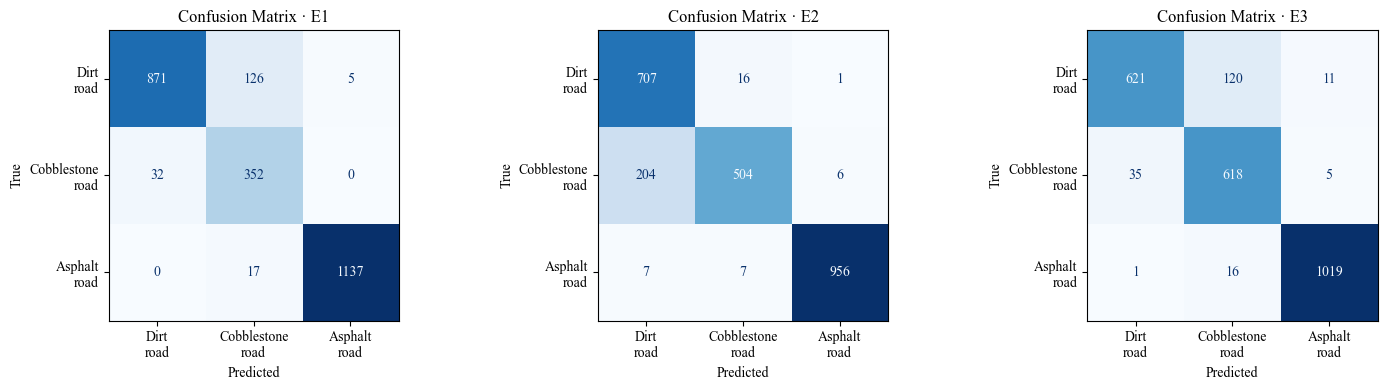

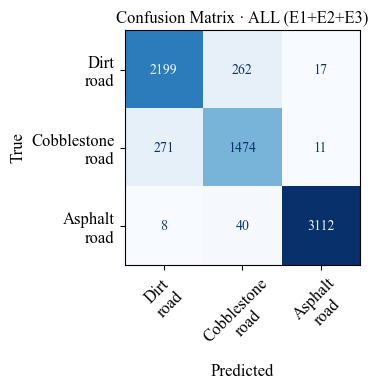

In [111]:
# Cell 11: Confusion matrices (per-exp và tổng)

LABEL_NAMES = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]
CLASS_IDS   = [0, 1, 2]

exps = ["E1", "E2", "E3"]
y_tests, y_preds = {}, {}

# Tái huấn luyện + dự đoán trên test cho từng exp để vẽ CM
for exp in exps:
    print(f"[CM] Refit & predict on {exp}")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = LGBMClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_tests[exp] = y_test
    y_preds[exp] = y_pred

# --- Hình 1: 1 hàng 3 cột (E1/E2/E3) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, exp in enumerate(exps):
    ax = axes[idx]
    cm = confusion_matrix(y_tests[exp], y_preds[exp], labels=CLASS_IDS)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix · {exp}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# --- Hình 2: Tổng (gộp E1+E2+E3) ---
y_all_true = np.concatenate([y_tests[e] for e in exps], axis=0)
y_all_pred = np.concatenate([y_preds[e] for e in exps], axis=0)
cm_all = confusion_matrix(y_all_true, y_all_pred, labels=CLASS_IDS)

fig2, ax2 = plt.subplots(1, 1, figsize=(4, 4))
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=LABEL_NAMES)
disp_all.plot(ax=ax2, values_format='d', cmap="Blues", colorbar=False)
ax2.set_title("Confusion Matrix · ALL (E1+E2+E3)")
ax2.set_xlabel("Predicted", fontsize=12)
ax2.set_ylabel("True", fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 12 — Classification report

In [112]:
# Cell 12: Classification reports (per-exp và tổng)

exps = ["E1", "E2", "E3"]

# for exp in exps:
#     print(f"\n===== Classification Report · {exp} =====")
#     print(classification_report(
#         y_tests[exp],
#         y_preds[exp],
#         labels=[0,1,2],
#         target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
#         digits=4
#     ))

print("\n===== Classification Report · ALL (E1+E2+E3) =====")
print(classification_report(
    y_all_true,
    y_all_pred,
    labels=[0,1,2],
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))



===== Classification Report · ALL (E1+E2+E3) =====
                  precision    recall  f1-score   support

       Dirt road     0.8874    0.8874    0.8874      2478
Cobblestone road     0.8300    0.8394    0.8347      1756
    Asphalt road     0.9911    0.9848    0.9879      3160

        accuracy                         0.9176      7394
       macro avg     0.9028    0.9039    0.9033      7394
    weighted avg     0.9181    0.9176    0.9178      7394



## Cell 13 — Huấn luyện trên toàn bộ PVS và xuất mã C

In [113]:
# Cell 13: Huấn luyện trên toàn bộ PVS và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_LGBM = LGBMClassifier(**BEST_PARAMS, random_state=42)
final_clf_LGBM.fit(X_all, y_all)

# Xuất mô hình sang header C/C++ bằng m2cgen
header_file = "m2cgen_PVS_LGBM.h"

try:
    c_cpp_code = export_to_c(final_clf_LGBM)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60180
[LightGBM] [Info] Number of data points in the train set: 7180, number of used features: 236
[LightGBM] [Info] Start training from score -1.280154
[LightGBM] [Info] Start training from score -1.231269
[LightGBM] [Info] Start training from score -0.843776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


✅ Exported to 'm2cgen_PVS_LGBM.h'
📦 Header size: 811.99 KB (0.793 MB)
